In [36]:
from casadi import *
from casadi.tools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

# Keller's model

> In his original 1974 paper, Keller proposed a model to determine "how a runner should vary his speed $v(t)$ during a race of distance $D$ in order to run it in the shortest time". 

$$D = \int_0^T v(t) dt$$

> The velocity satisfies the equation of motion:

$$\frac{dv}{dt} + \frac{v}{\tau} = f(t)$$

> $v/\tau$ is a resistive force per unit mass, $\tau$ is a given constant, $f(t)$ is the propulsive force per unit mass, controlled by the runner. Furthermore, $\forall t \ f(t)\leq F$, where $F$ is a maximum value.  

> The force affects the quantity $E(t)$ of available oxygen in the muscles per unit mass (oxygen is consumed in reactions which release the energy used in running). Energy is used at the rate $f v$, the oxygen is supplied at a rate $\sigma$. The oxygen balance equation is:

$$\frac{d E}{d t} = \sigma - f v$$

> Eventually, Keller found $v(t)$, $f(t)$ and $E(t)$ that minimized the total running time $T$. 

> Let's use this model in our optimization problem of the rat running on a treadmill. Let's work entirely in the frame of the laboratory. 

> Taking $f$ as the control parameter, the state can be written as:

$$x = \begin{pmatrix}
x_0(t)\\
x_1(t)
\end{pmatrix}=
\begin{pmatrix}
\textrm{position}\\
\textrm{velocity}
\end{pmatrix}$$

$$\dot{x} = \begin{pmatrix}
x_1(t)\\
u - \frac{(x_1(t)-v_t)}{\tau}
\end{pmatrix}=
\begin{pmatrix}
\textrm{velocity}\\
\textrm{acceleration}
\end{pmatrix}$$

> The cost that we will minimize is:

$$E(x(t),u(t))=\int_0^T \frac{d E}{d t}=\int_0^T \left[\sigma - u\left(x_1(t) - v_t\right)\right] dt$$

> We know (from paper ***) that $v_{max}=\tau \times F$, so the only unknown parameters are $\tau$ and $\sigma$. These can be estimated using values computed for human beings. The influence of these parameters on the optimal trajectories is discussed in the following sections.

$$0.0 \leq x_0(t) \leq L_{tread}$$
$$-0.6 \leq x_1(t) \leq 0.1$$ 

The rat should only run against the treadmill with an absolute velocity $|v_{max}|=0.7$ m/s.

$$-\frac{|v_{max}|}{\tau} \leq f(t) \leq \frac{|v_{max}|}{\tau}$$

In [61]:
def penalty_function(x,t,mux,mut,kxpenalty,steepnesst,vtapis):
    '''This function generates a spatio-temporal energy barrier: spatially centered around x = 'mux', with steepness 'kxpenalty'
    and temporally centered around t = 'mut', with steepness 'steepnesst'.'''
    kTt = mut/steepnesst
    max_height=.4                   # cost of running 10s at the velocity of the treadmill (max penalty)
    amplitude = max_height/(1+np.exp((t-mut)/kTt))  # penalty maximum at t=mut...
    kTx = mux/kxpenalty
    return(10*amplitude/(1+np.exp((x-mux)/kTx)))       # ...and x=mux


def reward_function(x,t,mux,mut,steepnesst):
    '''This function generates a spatio-temporal energy valley: spatially centered around x = mux (gaussian
    with variance sigma2), and starting temporally at t = mut with a slope determined by steepnesst'''
    sigma1 = 3.0        #temporal variance (of associated gaussian)
    kT = mut/steepnesst
    amplitude = -np.exp(-(t-mut)**2/2/sigma1**2)/(1+np.exp((-(t-mut))/kT))  #asymmetric time evolution (x=0)
    sigma2=0.01
    return(10*amplitude*np.exp(-(x-mux)**2/2/sigma2**2))                   #spatio-temporal evolution


def heaviside(x,k,mu,amp):
    return(amp/(1+np.exp(-2*k*(x-mu))))

def reward_function2(t,dt,reward_max,x,sigma_x,mu_x):
    mu=7.0 #the reward peak is centered around this value
    coeff_rwd_decrease = (-0.38*reward_max+reward_max)/(15.0-mu) #experimental coefficient for the linear decrease of the reward
    amplitude = heaviside(x=t,k=100,mu=mu+dt,amp=reward_max/dt+coeff_rwd_decrease)+heaviside(x=t,k=100,mu=mu-dt,amp=-reward_max/dt)
    return(amplitude*np.exp(-(x-mu_x)**2/2/sigma_x**2))   

def penalty2(t,mut,kt,height,x,mux,kx):
    amplitude = heaviside(-t,kt,-mut,height)
    return(amplitude/(1+np.exp(2*(x-mux)*kx)))


def optimal_trajectory(tau_res,sigma,x0,xf,tf,vtapis,kxpenalty,reward_max):
    '''This function takes parameters a, b, initial position x0 and final position xf and 
    computes the OC problem assuming either a linear cost (cost='linear', Int_0^T a+b*v dt), 
    or a quadratic one (cost='quadratic',Int_0^T a+b*v*v dt). It returns respectively the 
    optimal trajectory, the associated time array, the optimal 
    velocity and its associated time array.'''
    Ltread=0.9
    nk = 1000
    mu=0.1    # Control discretization
    kT=mu/1
    
    
    # Declare variables
    t  = SX.sym("t")    # time
    u  = SX.sym("u")    # control

    states = struct_symSX([
            entry('x',shape=2),    #  states
            entry('L')             #  helper state: Langrange integrand
         ])

    # Create a structure for the right hand side
    rhs = struct_SX(states)
    x = states['x']
    rhs["x"] = vertcat(x[1], u -(x[1]-vtapis)/tau_res)
    rhs["L"] = sigma - u*(x[1]-vtapis)+reward_function2(t=t,dt=0.1,reward_max=reward_max,x=x[0],sigma_x=0.1,mu_x=0.1)+penalty2(t=t,mut=7.0,kt=100,height=1.0,x=x[0],mux=0.1,kx=100)#+penalty_function(x=x[0],t=t,mux=0.1,mut=3.5,kxpenalty=kxpenalty,steepnesst=5,vtapis=vtapis)+reward_function(x=x[0],t=t,mux=0.1,mut=6.95,steepnesst=1000)
    
    # ODE right hand side function
    f = Function('f', [t,states,u],[rhs])

    # Objective function (meyer term)
    m = Function('m', [t,states,u],[states["L"]])

    # Control bounds
    u_min = -0.7/tau_res
    u_max = -u_min
    u_init = 0.0

    u_lb = np.array([u_min])
    u_ub = np.array([u_max])
    u_init = np.array([u_init])

    # State bounds and initial guess
    x_min =  [0.0,   vtapis-0.7, -inf]
    x_max =  [Ltread,vtapis,  inf]
    xi_min = [x0,  vtapis-0.7,  -inf]
    xi_max = [x0,  vtapis,  inf]
    xf_min = [xf,  vtapis-0.7, -inf]
    xf_max = [xf,  vtapis,  inf]
    x_init = [ 0.0,  0.0,  0.0]

    # Dimensions
    nx = 3
    nu = 1

    # Choose collocation points
    tau_root = [0] + collocation_points(3,"radau")

    # Degree of interpolating polynomial
    d = len(tau_root)-1

    # Size of the finite elements
    h = tf/nk

    # Coefficients of the collocation equation
    C = np.zeros((d+1,d+1))

    # Coefficients of the continuity equation
    D = np.zeros(d+1)

    # Dimensionless time inside one control interval
    tau = SX.sym("tau")

    # All collocation time points
    T = np.zeros((nk,d+1))
    for k in range(nk):
        for j in range(d+1):
            T[k,j] = h*(k + tau_root[j])

    # For all collocation points
    for j in range(d+1):
    # Construct Lagrange polynomials to get the polynomial basis at the collocation point
        L = 1
        for r in range(d+1):
            if r != j:
                L *= (tau-tau_root[r])/(tau_root[j]-tau_root[r])

        # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
        lfcn = Function('lfcn', [tau],[L])
        D[j] = lfcn(1.0)

        # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
        tfcn = Function('tfcn', [tau],[tangent(L,tau)])
        for r in range(d+1):
            C[j,r] = tfcn(tau_root[r])

    # Structure holding NLP variables
    V = struct_symMX([
      (
       entry("X",repeat=[nk+1,d+1],struct=states),
       entry("U",repeat=[nk],shape=nu)
      )
    ])

    vars_lb   = V()
    vars_ub   = V()
    vars_init = V()

    # Set states and its bounds
    vars_init["X",:,:] = repeated(repeated(x_init))
    vars_lb["X",:,:]   = repeated(repeated(x_min))
    vars_ub["X",:,:]   = repeated(repeated(x_max))

    # Set controls and its bounds
    vars_init["U",:] = repeated(u_init)
    vars_lb["U",:]   = repeated(u_min)
    vars_ub["U",:]   = repeated(u_max)

    # State at initial time
    vars_lb["X",0,0] = xi_min
    vars_ub["X",0,0] = xi_max

    # State at end time
    vars_lb["X",-1,0] = xf_min
    vars_ub["X",-1,0] = xf_max

    # Constraint function for the NLP
    g = []
    lbg = []
    ubg = []

    # For all finite elements
    for k in range(nk):

        # For all collocation points
        for j in range(1,d+1):

        # Get an expression for the state derivative at the collocation point
            xp_jk = 0
            for r in range (d+1):
                xp_jk += C[r,j]*V["X",k,r]

            # Add collocation equations to the NLP
            fk = f(T[k][j], V["X",k,j], V["U",k])
            g.append(h*fk - xp_jk)
            lbg.append(np.zeros(nx)) # equality constraints
            ubg.append(np.zeros(nx)) # equality constraints

        # Get an expression for the state at the end of the finite element
        xf_k = 0
        for r in range(d+1):
            xf_k += D[r]*V["X",k,r]

        # Add continuity equation to NLP
        g.append(V["X",k+1,0] - xf_k)
        lbg.append(np.zeros(nx))
        ubg.append(np.zeros(nx))

    # Concatenate constraints
    g = vertcat(*g)

    # Objective function
    f = m(T[nk-1][d],V["X",nk,0],V["U",nk-1])

    # NLP
    nlp = {'x':V, 'f':f, 'g':g}

    ## ----
    ## SOLVE THE NLP
    ## ----

    # Set options
    opts = {}
    opts["expand"] = True
    #opts["ipopt.max_iter"] = 4

    # Allocate an NLP solver
    solver = nlpsol("solver", "ipopt", nlp, opts)
    arg = {}

    # Initial condition
    arg["x0"] = vars_init

    # Bounds on x
    arg["lbx"] = vars_lb
    arg["ubx"] = vars_ub

    # Bounds on g
    arg["lbg"] = np.concatenate(lbg)
    arg["ubg"] = np.concatenate(ubg)

    # Solve the problem
    res = solver(**arg)

    # Print the optimal cost
    print("optimal cost: ", float(res["f"]))

    # Retrieve the solution
    opt = V(res["x"])

    # Get values at the beginning of each finite element
    x0_opt = opt["X",:,0,"x",0]
    x1_opt = opt["X",:,0,"x",1]
    x2_opt = opt["X",:,0,"L"]

    u_opt = opt["U",:,0]

    tgrid = np.linspace(0,tf,nk+1)
    tgrid_u = np.linspace(0,tf,nk)
    
    return(x0_opt,x1_opt,tgrid,u_opt,tgrid_u)


In [62]:
# PARAMETERS FOR THE COMPUTATION
vtapis = 0.1
kxpenalty=100  # steepness of penalty cost (the higher the steeper: 100 very steep, 3 slightly, 1 very diffused)
x0 = 0.0     # initial position
xf = 0.1     # final position 
tf = 10.     # final time (duration of experiment)
reward_max = 10.0
sigma = 1.708
tau = 0.1
xk,xdotk,tk,acck,tak = optimal_trajectory(tau_res=tau,sigma=sigma,x0=x0,xf=xf,tf=tf,vtapis=vtapis,kxpenalty=kxpenalty,reward_max=reward_max)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    56996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6000

Total number of variables............................:    13010
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     9006
                     variables with only upper bounds:        0
Total number of equality constraints.................:    12000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  77 -2.3485504e+006 1.64e-003 1.41e-001  -5.7 4.27e+005  -9.2 5.70e-002 1.88e-001f  1
  78 -2.4475814e+006 1.46e-003 9.66e-002  -5.7 9.14e+005  -9.7 2.36e-001 1.08e-001f  1
  79 -2.4475817e+006 1.24e-003 6.05e-002  -5.7 6.24e+000  -3.9 2.77e-001 1.53e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -2.4475835e+006 8.61e-004 7.50e-002  -5.7 6.98e+000  -4.3 4.87e-002 3.21e-001f  1
  81 -2.4475836e+006 8.51e-004 6.49e-002  -5.7 1.65e+001  -4.8 8.98e-002 1.10e-002f  1
  82 -2.4475862e+006 8.07e-004 6.34e-002  -5.7 4.95e+001  -5.3 3.47e-002 5.22e-002f  1
  83 -2.4476202e+006 6.22e-004 6.72e-002  -5.7 1.48e+002  -5.8 5.10e-002 2.29e-001f  1
  84 -2.4480595e+006 8.77e-004 7.47e-002  -5.7 4.45e+002  -6.3 2.34e-001 9.87e-001f  1
  85 -2.4481036e+006 8.58e-004 7.44e-002  -5.7 1.34e+003  -6.7 2.98e-003 3.30e-002f  1
  86 -2.4494655e+006 5.90e-004 1.42e-002  -5.7 4.01e+003  -7.2 8.10e-001 3.40e-001f  1
  87 -2.4593578e+006 1.08e-004 1.39e-002  -5.7 1.

 163 -1.0095239e+007 1.84e-004 2.06e-001  -5.7 2.01e+004  -7.9 9.68e-002 9.87e-001f  1
 164 -1.0123302e+007 2.79e-004 1.10e-001  -5.7 5.99e+004  -8.4 4.50e-001 4.69e-001f  1
 165 -1.0243092e+007 4.03e-004 2.93e-001  -5.7 1.20e+005  -8.9 1.81e-002 1.00e+000f  1
 166 -1.0398467e+007 3.80e-004 7.71e-001  -5.7 1.55e+005  -9.3 8.61e-001 1.00e+000f  1
 167 -1.0408199e+007 3.67e-004 6.88e-001  -5.7 9.32e+004  -9.8 2.50e-001 1.04e-001f  1
 168 -1.0479127e+007 3.02e-004 5.63e-001  -5.7 3.96e+005  -9.4 1.65e-001 1.79e-001f  1
 169 -1.0481315e+007 3.01e-004 5.60e-001  -5.7 9.25e+005  -9.9 2.82e-002 2.36e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -1.0490181e+007 3.02e-004 1.90e+002  -5.7 1.77e+005  -9.4 3.27e-007 5.02e-002f  1
 171 -1.0490188e+007 3.02e-004 1.90e+002  -5.7 1.06e+005  -9.9 1.49e-005 6.67e-005f  1
 172 -1.0513841e+007 7.01e-004 3.57e+002  -5.7 3.49e+005 -10.4 2.51e-007 6.78e-002f  1
 173 -1.0869417e+007 1.78e-004 5.46e-001  -5.7 3.

 251 -1.6127174e+007 5.86e-005 2.48e-002  -5.7 1.04e+005  -8.7 1.00e+000 1.00e+000f  1
 252 -1.7147310e+007 1.76e-005 7.22e-004  -5.7 1.02e+006  -9.6 1.00e+000 1.00e+000f  1
 253 -1.7195141e+007 5.67e-008 2.56e-004  -5.7 4.78e+004  -8.3 1.00e+000 1.00e+000f  1
 254 -1.7213077e+007 5.67e-008 2.50e-004  -5.7 1.79e+004  -7.9 1.00e+000 1.00e+000f  1
 255 -1.7266887e+007 5.40e-008 2.50e-004  -5.7 5.38e+004  -8.3 1.00e+000 1.00e+000f  1
 256 -1.7287066e+007 5.14e-008 2.50e-004  -5.7 2.02e+004  -7.9 1.00e+000 1.00e+000f  1
 257 -1.7294633e+007 6.25e-008 2.50e-004  -5.7 7.57e+003  -7.5 1.00e+000 1.00e+000f  1
 258 -1.7365138e+007 3.95e-004 1.35e-001  -5.7 1.60e+005  -8.4 3.51e-001 4.39e-001f  1
 259 -1.7365138e+007 3.91e-004 1.33e-001  -5.7 6.24e+000  -4.4 2.14e-001 9.17e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 -1.7365157e+007 2.32e-004 1.92e-002  -5.7 1.87e+001  -4.9 1.00e+000 1.00e+000f  1
 261 -1.7365213e+007 2.17e-005 3.19e-004  -5.7 5.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 -2.5089424e+007 4.15e-004 1.87e-001  -5.7 3.56e+005  -9.7 3.69e-002 3.96e-002f  1
 341 -2.5118324e+007 4.06e-004 1.83e-001  -5.7 1.30e+006  -9.7 2.41e-001 2.23e-002f  1
 342 -2.5119063e+007 4.02e-004 1.82e-001  -5.7 9.40e+004  -9.3 1.48e-003 7.86e-003f  1
 343 -2.5155558e+007 3.24e-004 2.10e-001  -5.7 1.76e+005  -9.8 1.17e-002 2.07e-001f  1
 344 -2.5156631e+007 3.19e-004 2.06e-001  -5.7 6.14e+004  -8.4 4.28e-003 1.75e-002f  1
 345 -2.5158964e+007 2.96e-004 5.72e+002  -5.7 2.56e+004  -8.0 8.85e-007 9.10e-002f  1
 346 -2.5164545e+007 4.42e-004 2.40e+002  -5.7 9.62e+003  -7.6 4.07e-004 5.80e-001f  1
 347 -2.5169708e+007 3.63e-004 2.54e+002  -5.7 2.89e+004  -8.1 2.23e-006 1.79e-001f  1
 348 -2.5256261e+007 1.58e-005 1.67e+004  -5.7 8.66e+004  -8.5 2.14e-006 1.00e+000f  1
 349 -2.5442142e+007 3.74e-005 2.34e-001  -5.7 1.86e+005  -9.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 -3.7701838e+007 1.39e-007 2.50e-004  -5.7 1.24e+005  -8.7 1.00e+000 1.00e+000f  1
 431 -3.8270254e+007 5.39e-005 3.33e-001  -5.7 5.68e+005  -9.6 1.00e+000 1.00e+000f  1
 432 -3.8378279e+007 6.08e-004 3.62e-001  -5.7 2.96e+005 -10.1 4.12e-001 3.65e-001f  1
 433 -3.8389427e+007 5.61e-004 3.24e-001  -5.7 1.43e+005  -9.7 2.05e-004 7.77e-002f  1
 434 -3.8448158e+007 5.44e-004 2.54e-002  -5.7 5.87e+004  -8.4 1.00e+000 1.00e+000f  1
 435 -3.8470180e+007 4.88e-005 3.55e-004  -5.7 2.20e+004  -7.9 8.00e-001 1.00e+000f  1
 436 -3.8536256e+007 1.17e-007 2.50e-004  -5.7 6.61e+004  -8.4 1.00e+000 1.00e+000f  1
 437 -3.8610565e+007 1.44e-007 3.55e-004  -5.7 7.43e+004  -8.5 1.00e+000 1.00e+000f  1
 438 -3.8833335e+007 1.31e-007 1.47e-003  -5.7 2.23e+005  -9.0 1.00e+000 1.00e+000f  1
 439 -3.8916721e+007 1.31e-007 1.34e-003  -5.7 8.34e+004  -8.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

 517 -4.3985782e+007 1.75e-004 7.06e-002  -5.7 1.59e+000  -3.6 8.83e-001 4.70e-001f  1
 518 -4.3985784e+007 1.14e-004 6.04e-002  -5.7 3.08e+000  -4.1 9.36e-002 8.48e-001f  1
 519 -4.3985786e+007 9.28e-005 1.66e-002  -5.7 9.23e+000  -4.6 9.14e-001 2.10e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520 -4.3985814e+007 2.32e-006 2.50e-004  -5.7 2.76e+001  -5.0 1.00e+000 1.00e+000f  1
 521 -4.3985897e+007 1.61e-007 2.50e-004  -5.7 8.29e+001  -5.5 1.00e+000 1.00e+000f  1
 522 -4.3986146e+007 1.33e-007 2.50e-004  -5.7 2.49e+002  -6.0 1.00e+000 1.00e+000f  1
 523 -4.3986892e+007 1.32e-007 2.50e-004  -5.7 7.46e+002  -6.5 1.00e+000 1.00e+000f  1
 524 -4.3989131e+007 1.37e-007 2.50e-004  -5.7 2.24e+003  -7.0 1.00e+000 1.00e+000f  1
 525 -4.3995850e+007 1.37e-007 2.50e-004  -5.7 6.72e+003  -7.4 1.00e+000 1.00e+000f  1
 526 -4.4016004e+007 1.44e-007 2.51e-004  -5.7 2.02e+004  -7.9 1.00e+000 1.00e+000f  1
 527 -4.4023562e+007 1.26e-007 2.50e-004  -5.7 7.

 603 -5.3067315e+007 8.31e-005 8.09e-001  -5.7 2.38e+000  -4.0 1.00e+000 2.48e-001f  1
 604 -5.3067322e+007 5.73e-005 7.45e-004  -5.7 7.11e+000  -4.5 1.00e+000 1.00e+000f  1
 605 -5.3067343e+007 5.06e-007 2.50e-004  -5.7 2.13e+001  -4.9 1.00e+000 1.00e+000f  1
 606 -5.3067407e+007 1.45e-007 2.50e-004  -5.7 6.39e+001  -5.4 1.00e+000 1.00e+000f  1
 607 -5.3067599e+007 1.37e-007 2.50e-004  -5.7 1.92e+002  -5.9 1.00e+000 1.00e+000f  1
 608 -5.3068174e+007 1.37e-007 2.50e-004  -5.7 5.75e+002  -6.4 1.00e+000 1.00e+000f  1
 609 -5.3069899e+007 1.41e-007 2.50e-004  -5.7 1.73e+003  -6.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610 -5.3075074e+007 1.37e-007 2.50e-004  -5.7 5.18e+003  -7.3 1.00e+000 1.00e+000f  1
 611 -5.3090600e+007 1.65e-007 2.55e-004  -5.7 1.55e+004  -7.8 1.00e+000 1.00e+000f  1
 612 -5.3137175e+007 1.37e-007 2.96e-004  -5.7 4.66e+004  -8.3 1.00e+000 1.00e+000f  1
 613 -5.3276909e+007 1.37e-007 2.50e-004  -5.7 1.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 -5.9489717e+007 9.66e-005 6.91e+001  -5.7 4.37e+005  -9.2 1.89e-007 7.57e-002f  1
 691 -5.9503590e+007 9.18e-005 6.21e+001  -5.7 1.64e+005  -8.8 5.76e-006 8.46e-002f  1
 692 -5.9507129e+007 8.70e-005 5.00e+001  -5.7 6.15e+004  -8.4 3.66e-007 5.75e-002f  1
 693 -5.9507247e+007 8.74e-005 7.11e+001  -5.7 2.31e+004  -8.0 1.67e-007 5.12e-003f  1
 694 -5.9512859e+007 8.31e-005 1.01e+002  -5.7 6.92e+004  -8.4 1.99e-007 8.11e-002f  1
 695 -5.9515178e+007 7.97e-005 9.17e+001  -5.7 2.59e+004  -8.0 4.62e-006 8.94e-002f  1
 696 -5.9519905e+007 7.66e-005 5.65e+001  -5.7 7.79e+004  -8.5 3.68e-007 6.07e-002f  1
 697 -5.9521129e+007 7.80e-005 7.07e+001  -5.7 1.73e+005  -9.0 1.78e-007 7.09e-003f  1
 698 -5.9553051e+007 7.59e-005 1.22e+002  -5.7 3.83e+005  -9.4 2.14e-007 8.35e-002f  1
 699 -5.9570088e+007 7.42e-005 1.13e+002  -5.7 2.33e+005  -9.0 3.68e-006 7.32e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

 778 -6.3132933e+007 2.26e-007 2.52e-004  -5.7 2.41e+004  -8.0 1.00e+000 1.00e+000f  1
 779 -6.3205153e+007 1.97e-007 6.26e-004  -5.7 7.22e+004  -8.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780 -6.3286420e+007 1.91e-007 2.50e-004  -5.7 8.13e+004  -8.5 1.00e+000 1.00e+000f  1
 781 -6.3530222e+007 1.82e-007 2.50e-004  -5.7 2.44e+005  -9.0 1.00e+000 1.00e+000f  1
 782 -6.5667881e+007 8.92e-005 6.41e-002  -5.7 2.14e+006  -9.9 1.00e+000 1.00e+000f  1
 783 -6.5986340e+007 1.00e-003 7.37e-001  -5.7 9.89e+005  -9.1 2.09e-001 4.24e-001H  1
 784 -6.5986340e+007 1.00e-003 7.36e-001  -5.7 3.17e+001  -4.2 4.99e-002 1.42e-003f  1
 785 -6.5986341e+007 9.50e-004 6.93e-001  -5.7 1.06e+001  -4.6 2.51e-002 5.86e-002f  1
 786 -6.5986344e+007 8.46e-004 6.13e-001  -5.7 3.18e+001  -5.1 3.16e-004 1.15e-001f  1
 787 -6.5986353e+007 7.80e-004 2.74e+002  -5.7 9.54e+001  -5.6 6.18e-007 9.38e-002f  1
 788 -6.5986435e+007 5.67e-004 1.96e+002  -5.7 2.

 865 -7.2316430e+007 2.75e-007 2.50e-004  -5.7 8.59e+005  -9.5 1.00e+000 1.00e+000f  1
 866 -7.2855036e+007 8.43e-005 1.57e-001  -5.7 9.13e+005 -10.5 1.00e+000 5.90e-001f  1
 867 -7.3045335e+007 7.79e-004 3.01e-001  -5.7 2.35e+005  -9.2 6.27e-001 8.11e-001f  1
 868 -7.3063415e+007 7.25e-004 2.75e-001  -5.7 2.23e+005  -9.6 1.18e-004 8.11e-002f  1
 869 -7.3218674e+007 4.84e-004 1.76e-001  -5.7 3.65e+005  -9.2 3.05e-001 4.25e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 870 -7.3237779e+007 8.63e-005 1.61e-002  -5.7 1.91e+004  -7.9 7.44e-001 1.00e+000f  1
 871 -7.3295031e+007 4.58e-006 8.63e-004  -5.7 5.73e+004  -8.4 1.00e+000 1.00e+000f  1
 872 -7.3466976e+007 2.50e-007 2.65e-004  -5.7 1.72e+005  -8.8 1.00e+000 1.00e+000f  1
 873 -7.3531456e+007 2.54e-007 2.50e-004  -5.7 6.45e+004  -8.4 1.00e+000 1.00e+000f  1
 874 -7.3555636e+007 2.92e-007 2.50e-004  -5.7 2.42e+004  -8.0 1.00e+000 1.00e+000f  1
 875 -7.3564703e+007 2.88e-007 2.50e-004  -5.7 9.

 953 -7.6859583e+007 9.67e-004 1.01e+003  -5.7 5.21e+005  -9.4 3.52e-008 1.46e-001f  1
 954 -7.6980474e+007 8.93e-004 8.47e+002  -5.7 7.36e+005  -9.9 5.62e-007 1.64e-001f  1
 955 -7.6980529e+007 9.24e-004 8.42e+002  -5.7 1.06e+004  -7.6 4.49e-007 5.20e-003f  1
 956 -7.6980901e+007 9.19e-004 8.32e+002  -5.7 3.19e+004  -8.1 4.50e-007 1.16e-002f  1
 957 -7.6982185e+007 8.87e-004 8.03e+002  -5.7 3.59e+004  -8.2 2.18e-006 3.57e-002f  1
 958 -7.6982388e+007 8.75e-004 7.91e+002  -5.7 1.35e+004  -7.7 1.82e-002 1.51e-002f  1
 959 -7.6984317e+007 8.29e-004 7.49e+002  -5.7 3.65e+004  -8.2 1.57e-006 5.28e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960 -7.6988263e+007 8.03e-004 7.24e+002  -5.7 1.21e+005  -8.7 5.94e-004 3.25e-002f  1
 961 -7.6996807e+007 7.84e-004 7.01e+002  -5.7 2.62e+005  -9.2 6.98e-006 3.26e-002f  1
 962 -7.7021082e+007 7.74e-004 6.91e+002  -5.7 1.66e+006 -10.1 8.88e-003 1.46e-002f  1
 963 -7.7039207e+007 8.58e-004 6.64e+002  -5.7 4.

1043 -8.5279414e+007 5.17e-004 1.48e-001  -5.7 4.75e+005 -10.0 6.34e-001 7.03e-001f  1
1044 -8.5326128e+007 4.69e-004 1.77e-001  -5.7 3.97e+005  -9.6 1.91e-004 1.18e-001f  1
1045 -8.5353186e+007 4.03e-004 1.42e-001  -5.7 1.37e+005  -8.7 1.00e+000 1.98e-001f  1
1046 -8.5404496e+007 2.38e-004 8.03e-002  -5.7 5.13e+004  -8.3 3.65e-001 1.00e+000f  1
1047 -8.5558328e+007 1.48e-005 1.54e-003  -5.7 1.54e+005  -8.8 1.00e+000 1.00e+000f  1
1048 -8.6782871e+007 2.18e-005 1.02e-001  -5.7 1.22e+006  -9.7 1.00e+000 1.00e+000f  1
1049 -8.6998837e+007 1.27e-003 6.09e-001  -5.7 2.22e+005 -10.2 4.61e-001 9.75e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1050 -8.7111808e+007 9.86e-004 3.90e-001  -5.7 4.43e+005 -10.7 2.26e-001 2.55e-001f  1
1051 -8.7130810e+007 8.94e-004 3.65e-001  -5.7 2.02e+005  -9.4 7.00e-001 9.40e-002f  1
1052 -8.7242996e+007 1.76e-004 5.17e-001  -5.7 1.12e+005  -9.8 6.50e-002 1.00e+000f  1
1053 -8.7481051e+007 5.02e-004 7.96e-001  -5.7 6.

1132 -9.8646204e+007 4.29e-004 2.07e+002  -5.7 8.70e+003  -7.5 8.00e-004 3.56e-001f  1
1133 -9.8672291e+007 8.35e-007 1.15e+003  -5.7 2.61e+004  -8.0 3.32e-006 1.00e+000f  1
1134 -9.8699047e+007 1.56e-006 7.55e+002  -5.7 7.83e+004  -8.5 4.80e-002 3.42e-001f  1
1135 -9.8927432e+007 7.80e-007 9.90e+002  -5.7 2.35e+005  -9.0 4.10e-006 9.73e-001f  1
1136 -9.9312268e+007 1.20e-004 1.15e+004  -5.7 6.08e+005  -9.4 1.30e-006 6.33e-001f  1
1137 -9.9323227e+007 9.86e-005 7.67e+003  -5.7 3.30e+004  -8.1 3.59e-006 3.32e-001f  1
1138 -9.9370210e+007 6.16e-005 8.56e+002  -5.7 9.79e+004  -8.6 2.34e-006 4.80e-001f  1
1139 -9.9407355e+007 1.51e-005 1.06e+003  -5.7 3.71e+004  -8.2 4.12e-006 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1140 -9.9412901e+007 9.13e-006 6.38e+002  -5.7 1.39e+004  -7.7 4.96e-001 3.98e-001f  1
1141 -9.9454689e+007 2.96e-007 1.13e+003  -5.7 4.18e+004  -8.2 8.04e-006 1.00e+000f  1
1142 -9.9497118e+007 3.74e-007 1.10e+002  -5.7 4.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1220 -1.0477880e+008 2.86e-007 2.73e-004  -5.7 1.47e+005  -8.8 1.00e+000 1.00e+000f  1
1221 -1.0494439e+008 2.86e-007 2.50e-004  -5.7 1.66e+005  -8.8 1.00e+000 1.00e+000f  1
1222 -1.0495215e+008 2.70e-007 2.50e-004  -5.7 7.76e+003  -7.5 1.00e+000 1.00e+000f  1
1223 -1.0497544e+008 3.10e-007 2.50e-004  -5.7 2.33e+004  -8.0 1.00e+000 1.00e+000f  1
1224 -1.0504530e+008 2.86e-007 2.55e-004  -5.7 6.99e+004  -8.4 1.00e+000 1.00e+000f  1
1225 -1.0507149e+008 2.60e-007 2.51e-004  -5.7 2.62e+004  -8.0 1.00e+000 1.00e+000f  1
1226 -1.0523611e+008 2.75e-004 4.47e-001  -5.7 1.65e+005  -9.0 1.00e+000 1.00e+000f  1
1227 -1.0550247e+008 6.02e-006 4.94e-001  -5.7 2.66e+005  -9.5 1.00e+000 1.00e+000f  1
1228 -1.0550455e+008 6.91e-006 4.86e-001  -5.7 1.37e+005  -9.9 2.13e-001 1.52e-002f  1
1229 -1.0558227e+008 8.85e-006 4.72e-001  -5.7 6.08e+005  -9.5 1.25e-001 1.28e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

1308 -1.1043720e+008 7.23e-004 1.25e+000  -5.7 7.55e+005 -11.2 2.21e-002 1.06e-002f  1
1309 -1.1046928e+008 6.72e-004 1.16e+000  -5.7 4.49e+005 -11.7 8.50e-003 7.15e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1310 -1.1046928e+008 6.22e-004 1.20e+002  -5.7 3.04e+000  -3.8 1.59e-005 7.73e-002f  1
1311 -1.1046928e+008 6.15e-004 1.19e+002  -5.7 4.94e+000  -4.3 1.78e-005 1.08e-002f  1
1312 -1.1046928e+008 6.09e-004 1.55e+003  -5.7 1.93e+001  -4.8 2.87e-007 1.09e-002f  1
1313 -1.1046928e+008 6.08e-004 1.54e+003  -5.7 4.44e+001  -5.2 6.36e-008 2.14e-003f  1
1314 -1.1046928e+008 6.04e-004 6.21e+003  -5.7 1.33e+002  -5.7 4.03e-008 7.11e-003f  1
1315 -1.1046940e+008 4.68e-004 4.40e+003  -5.7 3.99e+002  -6.2 1.18e-002 2.91e-001f  1
1316 -1.1046940e+008 4.50e-004 4.23e+003  -5.7 2.52e+000  -4.0 3.76e-001 3.94e-002f  1
1317 -1.1046940e+008 4.11e-004 3.80e+003  -5.7 1.19e+001  -4.4 2.80e-004 9.96e-002f  1
1318 -1.1046942e+008 3.56e-004 1.61e-001  -5.7 2.

1396 -1.1985805e+008 2.78e-004 1.49e-002  -5.7 2.73e+004  -8.0 1.00e+000 1.00e+000f  1
1397 -1.2010396e+008 2.27e-005 3.23e-004  -5.7 2.46e+005  -9.0 1.00e+000 1.00e+000f  1
1398 -1.2128719e+008 1.43e-005 2.87e-001  -5.7 1.18e+006  -9.9 1.00e+000 1.00e+000f  1
1399 -1.2151131e+008 4.55e-004 3.17e-001  -5.7 2.89e+006 -10.9 1.02e-001 7.74e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400 -1.2151392e+008 3.79e-004 2.60e-001  -5.7 1.46e+004  -7.8 1.25e-003 1.79e-001f  1
1401 -1.2151422e+008 3.77e-004 2.58e-001  -5.7 4.38e+004  -8.2 1.95e-003 6.93e-003f  1
1402 -1.2151671e+008 3.33e-004 2.19e-001  -5.7 1.64e+004  -7.8 9.82e-001 1.52e-001f  1
1403 -1.2158228e+008 3.52e-004 3.79e-001  -5.7 9.37e+005  -8.8 8.22e-002 7.00e-002f  1
1404 -1.2158228e+008 3.51e-004 3.78e-001  -5.7 1.35e+001  -4.7 1.14e-002 2.00e-003f  1
1405 -1.2158228e+008 3.83e-004 3.59e-001  -5.7 4.08e+001  -5.2 3.31e-003 5.18e-002f  1
1406 -1.2158228e+008 3.81e-004 3.57e-001  -5.7 1.

1488 -1.3499941e+008 5.55e-004 1.08e-001  -5.7 9.56e+000  -4.6 1.67e-003 6.81e-003f  1
1489 -1.3499942e+008 5.31e-004 1.03e-001  -5.7 2.87e+001  -5.1 2.24e-003 5.04e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1490 -1.3499950e+008 1.09e-003 3.34e-002  -5.7 8.59e+001  -5.5 2.41e-002 1.00e+000f  1
1491 -1.3499950e+008 1.06e-003 3.26e-002  -5.7 4.03e+000  -4.2 1.00e+000 2.62e-002f  1
1492 -1.3499951e+008 9.10e-005 5.58e-004  -5.7 1.21e+001  -4.7 1.00e+000 1.00e+000f  1
1493 -1.3499955e+008 5.36e-007 2.50e-004  -5.7 3.62e+001  -5.2 1.00e+000 1.00e+000f  1
1494 -1.3499966e+008 5.39e-007 2.50e-004  -5.7 1.09e+002  -5.6 1.00e+000 1.00e+000f  1
1495 -1.3499998e+008 4.20e-007 2.50e-004  -5.7 3.26e+002  -6.1 1.00e+000 1.00e+000f  1
1496 -1.3500096e+008 4.33e-007 2.50e-004  -5.7 9.78e+002  -6.6 1.00e+000 1.00e+000f  1
1497 -1.3500390e+008 4.16e-007 2.50e-004  -5.7 2.93e+003  -7.1 1.00e+000 1.00e+000f  1
1498 -1.3501270e+008 5.48e-007 2.50e-004  -5.7 8.

1579 -1.4218850e+008 4.88e-004 2.59e-001  -5.7 2.49e+005  -9.2 1.00e+000 4.19e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1580 -1.4226124e+008 4.10e-004 4.07e-001  -5.7 3.05e+005  -9.6 1.00e+000 2.39e-001f  1
1581 -1.4228802e+008 3.93e-004 3.74e-001  -5.7 6.43e+005 -10.1 1.96e-002 4.16e-002f  1
1582 -1.4228827e+008 3.92e-004 3.73e-001  -5.7 1.88e+005  -9.7 1.41e-001 1.35e-003f  1
1583 -1.4235429e+008 3.65e-004 3.58e-001  -5.7 9.41e+005 -10.6 9.56e-002 7.01e-002f  1
1584 -1.4252557e+008 2.18e-006 1.12e+002  -5.7 1.71e+005 -10.2 3.20e-004 1.00e+000f  1
1585 -1.4290963e+008 2.37e-003 1.81e+001  -5.7 4.58e+005 -10.7 3.57e-001 8.39e-001f  1
1586 -1.4295627e+008 2.19e-003 1.66e+001  -5.7 5.64e+005  -9.4 6.44e-005 8.27e-002f  1
1587 -1.4295627e+008 1.72e-003 1.30e+001  -5.7 1.58e-001  -1.5 1.67e-001 2.17e-001h  1
1588 -1.4295627e+008 1.01e-003 7.66e+000  -5.7 1.87e-001  -2.0 3.25e-001 4.11e-001f  1
1589 -1.4295627e+008 8.63e-006 9.78e-003  -5.7 2.

1668 -1.5603499e+008 8.59e-004 6.65e-001  -5.7 8.52e+004 -10.2 7.49e-001 1.00e+000f  1
1669 -1.5605658e+008 7.16e-004 5.47e-001  -5.7 1.22e+005  -8.9 1.00e+000 1.77e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1670 -1.5612552e+008 2.76e-005 8.81e-003  -5.7 6.89e+004  -8.4 9.25e-001 1.00e+000f  1
1671 -1.5633232e+008 3.64e-006 2.80e-004  -5.7 2.07e+005  -8.9 1.00e+000 1.00e+000f  1
1672 -1.5819335e+008 5.47e-007 5.55e-004  -5.7 1.86e+006  -9.9 1.00e+000 1.00e+000f  1
1673 -1.5820426e+008 5.09e-007 2.50e-004  -5.7 1.09e+004  -7.6 1.00e+000 1.00e+000f  1
1674 -1.5823697e+008 5.05e-007 2.50e-004  -5.7 3.27e+004  -8.1 1.00e+000 1.00e+000f  1
1675 -1.5853141e+008 5.48e-007 2.66e-004  -5.7 2.94e+005  -9.1 1.00e+000 1.00e+000f  1
1676 -1.5863677e+008 9.79e-004 1.78e-001  -5.7 1.28e+007  -9.1 5.37e-003 8.24e-003f  1
1677 -1.5865943e+008 7.76e-004 1.20e-001  -5.7 1.00e+005  -8.7 2.82e-003 2.26e-001f  1
1678 -1.5866525e+008 3.98e-004 2.81e-002  -5.7 5.

1759 -1.6732993e+008 3.13e-004 2.38e-002  -5.7 1.10e+004  -7.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1760 -1.6736259e+008 2.10e-005 3.06e-003  -5.7 3.27e+004  -8.1 7.50e-001 1.00e+000f  1
1761 -1.6739955e+008 5.40e-007 2.50e-004  -5.7 3.70e+004  -8.2 1.00e+000 1.00e+000f  1
1762 -1.6751043e+008 5.46e-007 2.53e-004  -5.7 1.11e+005  -8.6 1.00e+000 1.00e+000f  1
1763 -1.6801185e+008 4.19e-004 1.31e-001  -5.7 9.03e+005  -9.6 8.49e-001 5.56e-001f  1
1764 -1.6801371e+008 3.07e-004 8.90e-002  -5.7 5.85e+003  -7.4 1.46e-003 3.19e-001f  1
1765 -1.6803125e+008 4.45e-004 1.92e-002  -5.7 1.75e+004  -7.8 9.58e-001 1.00e+000f  1
1766 -1.6808388e+008 2.84e-005 2.70e-004  -5.7 5.26e+004  -8.3 1.00e+000 1.00e+000f  1
1767 -1.6810360e+008 4.37e-007 6.40e-004  -5.7 1.97e+004  -7.9 1.00e+000 1.00e+000f  1
1768 -1.6811100e+008 5.41e-007 2.50e-004  -5.7 7.40e+003  -7.5 1.00e+000 1.00e+000f  1
1769 -1.6813320e+008 6.46e-007 2.50e-004  -5.7 2.

1849 -1.7365802e+008 5.48e-007 2.50e-004  -5.7 2.93e+004  -8.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1850 -1.7374600e+008 5.48e-007 2.58e-004  -5.7 8.80e+004  -8.5 1.00e+000 1.00e+000f  1
1851 -1.7383161e+008 4.11e-004 1.72e-001  -5.7 2.73e+005  -8.6 2.30e-001 3.14e-001f  1
1852 -1.7383161e+008 4.11e-004 1.72e-001  -5.7 3.91e+001  -4.6 2.27e-002 1.03e-003f  1
1853 -1.7383163e+008 3.32e-004 8.03e-002  -5.7 2.72e+001  -5.0 6.48e-001 5.32e-001f  1
1854 -1.7383168e+008 1.26e-004 2.78e-002  -5.7 8.16e+001  -5.5 2.29e-002 6.51e-001f  1
1855 -1.7383192e+008 2.66e-005 1.12e-003  -5.7 2.45e+002  -6.0 1.00e+000 1.00e+000f  1
1856 -1.7383266e+008 5.91e-007 2.50e-004  -5.7 7.34e+002  -6.5 1.00e+000 1.00e+000f  1
1857 -1.7383486e+008 5.36e-007 2.50e-004  -5.7 2.20e+003  -6.9 1.00e+000 1.00e+000f  1
1858 -1.7384147e+008 4.84e-007 2.50e-004  -5.7 6.61e+003  -7.4 1.00e+000 1.00e+000f  1
1859 -1.7390092e+008 5.57e-007 2.50e-004  -5.7 5.

1938 -1.7960031e+008 5.34e-007 2.50e-004  -5.7 2.33e+004  -8.0 1.00e+000 1.00e+000f  1
1939 -1.7960903e+008 5.25e-007 2.50e-004  -5.7 8.73e+003  -7.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1940 -1.7963521e+008 5.48e-007 2.50e-004  -5.7 2.62e+004  -8.0 1.00e+000 1.00e+000f  1
1941 -1.7966466e+008 5.31e-007 2.50e-004  -5.7 2.94e+004  -8.1 1.00e+000 1.00e+000f  1
1942 -1.7992967e+008 4.87e-007 2.74e-004  -5.7 2.65e+005  -9.0 1.00e+000 1.00e+000f  1
1943 -1.8022783e+008 5.64e-007 2.50e-004  -5.7 2.98e+005  -9.1 1.00e+000 1.00e+000f  1
1944 -1.8026976e+008 5.48e-007 2.50e-004  -5.7 4.19e+004  -8.2 1.00e+000 1.00e+000f  1
1945 -1.8028549e+008 5.48e-007 2.50e-004  -5.7 1.57e+004  -7.8 1.00e+000 1.00e+000f  1
1946 -1.8042699e+008 5.48e-007 2.50e-004  -5.7 1.42e+005  -8.8 1.00e+000 1.00e+000f  1
1947 -1.8063072e+008 3.49e-004 4.18e-001  -5.7 3.10e+005  -8.8 5.53e-001 6.58e-001f  1
1948 -1.8063072e+008 3.32e-004 3.97e-001  -5.7 1.

2025 -1.8889213e+008 6.58e-004 1.42e+000  -5.7 2.86e+001  -4.6 3.10e-002 1.52e-003f  1
2026 -1.8889215e+008 5.07e-004 4.70e-001  -5.7 2.74e+001  -5.0 3.06e-001 6.69e-001f  1
2027 -1.8889218e+008 3.51e-004 3.25e-001  -5.7 8.22e+001  -5.5 7.12e-003 3.08e-001f  1
2028 -1.8889243e+008 7.43e-005 2.50e-003  -5.7 2.47e+002  -6.0 1.00e+000 1.00e+000f  1
2029 -1.8889317e+008 5.14e-007 2.50e-004  -5.7 7.40e+002  -6.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2030 -1.8889539e+008 5.28e-007 2.50e-004  -5.7 2.22e+003  -6.9 1.00e+000 1.00e+000f  1
2031 -1.8890205e+008 5.45e-007 2.50e-004  -5.7 6.66e+003  -7.4 1.00e+000 1.00e+000f  1
2032 -1.8896200e+008 5.38e-007 2.50e-004  -5.7 5.99e+004  -8.4 1.00e+000 1.00e+000f  1
2033 -1.8902944e+008 5.24e-007 2.50e-004  -5.7 6.74e+004  -8.4 1.00e+000 1.00e+000f  1
2034 -1.8923177e+008 5.24e-007 2.50e-004  -5.7 2.02e+005  -8.9 1.00e+000 1.00e+000f  1
2035 -1.8924125e+008 5.67e-007 2.50e-004  -5.7 9.

2113 -1.9997630e+008 5.28e-007 2.50e-004  -5.7 5.35e+002  -6.3 1.00e+000 1.00e+000f  1
2114 -1.9997791e+008 6.44e-007 2.50e-004  -5.7 1.61e+003  -6.8 1.00e+000 1.00e+000f  1
2115 -1.9998272e+008 6.44e-007 2.50e-004  -5.7 4.82e+003  -7.3 1.00e+000 1.00e+000f  1
2116 -2.0002607e+008 5.61e-007 2.50e-004  -5.7 4.33e+004  -8.2 1.00e+000 1.00e+000f  1
2117 -2.0041580e+008 5.24e-007 1.14e-003  -5.7 3.90e+005  -9.2 1.00e+000 1.00e+000f  1
2118 -2.0085466e+008 5.90e-007 2.50e-004  -5.7 4.39e+005  -9.2 1.00e+000 1.00e+000f  1
2119 -2.0439777e+008 9.89e-005 1.70e-001  -5.7 3.54e+006 -10.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2120 -2.0453643e+008 5.97e-004 2.83e-001  -5.7 1.39e+005  -8.9 4.66e-001 1.00e+000f  1
2121 -2.0454511e+008 1.81e-004 5.44e-003  -5.7 8.68e+003  -7.5 1.00e+000 1.00e+000f  1
2122 -2.0457115e+008 9.61e-007 2.50e-004  -5.7 2.60e+004  -8.0 1.00e+000 1.00e+000f  1
2123 -2.0464905e+008 5.48e-007 1.38e-003  -5.7 7.

2201 -2.1195255e+008 1.48e-003 3.27e-001  -5.7 6.23e+005 -10.4 3.18e-001 1.90e-001f  1
2202 -2.1201219e+008 1.22e-003 2.67e-001  -5.7 3.17e+005  -9.9 3.74e-004 1.88e-001f  1
2203 -2.1201929e+008 1.18e-003 2.56e-001  -5.7 1.78e+005 -10.4 2.09e-001 4.00e-002f  1
2204 -2.1203339e+008 1.13e-003 2.44e-001  -5.7 3.10e+005  -9.1 9.34e-004 4.56e-002f  1
2205 -2.1203396e+008 1.13e-003 2.43e-001  -5.7 1.15e+005  -8.7 5.15e-004 4.93e-003f  1
2206 -2.1204382e+008 1.07e-003 2.29e-001  -5.7 2.02e+005  -9.1 5.20e-001 4.87e-002f  1
2207 -2.1235276e+008 2.87e-003 5.35e-001  -5.7 8.89e+005  -9.6 1.71e-002 3.47e-001f  1
2208 -2.1238341e+008 2.52e-003 4.81e-001  -5.7 1.81e+005 -10.1 1.12e-001 1.69e-001f  1
2209 -2.1240400e+008 2.47e-003 4.70e-001  -5.7 9.28e+005 -10.6 1.39e-001 2.22e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2210 -2.1243127e+008 2.16e-003 4.09e-001  -5.7 2.15e+005 -10.1 1.36e-003 1.27e-001f  1
2211 -2.1244656e+008 2.07e-003 3.89e-001  -5.7 3.

2297 -2.1483994e+008 3.45e-003 3.21e-001  -5.7 1.04e+005  -8.6 3.89e-010 4.06e-005f  1
2298 -2.1483995e+008 3.47e-003 3.21e-001  -5.7 1.74e+005  -9.1 4.21e-010 4.13e-005f  1
2299 -2.1483995e+008 3.50e-003 3.21e-001  -5.7 9.18e+004  -8.7 4.48e-010 4.16e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300 -2.1483996e+008 3.51e-003 3.21e-001  -5.7 1.48e+005  -9.1 4.87e-010 4.22e-005f  1
2301 -2.1483997e+008 3.53e-003 3.21e-001  -5.7 2.22e+005  -9.6 5.20e-010 4.24e-005f  1
2302 -2.1483997e+008 3.55e-003 3.21e-001  -5.7 1.54e+005  -9.2 5.68e-010 4.30e-005f  1
2303 -2.1483999e+008 3.57e-003 3.21e-001  -5.7 3.94e+005  -9.7 6.09e-010 4.32e-005f  1
2304 -2.1484009e+008 3.58e-003 3.21e-001  -5.7 2.23e+006 -10.6 6.68e-010 4.37e-005f  1
2305 -2.1484009e+008 3.60e-003 3.21e-001  -5.7 1.02e+005 -11.1 7.19e-010 4.39e-005f  1
2306 -2.1484016e+008 3.61e-003 3.21e-001  -5.7 1.57e+006 -12.1 7.91e-010 4.44e-005f  1
2307 -2.1484017e+008 3.62e-003 3.21e-001  -5.7 2.

2385 -2.1484076e+008 3.72e-003 3.19e-001  -5.7 4.51e+005 -11.1 1.73e-005 5.21e-005f  1
2386 -2.1484110e+008 3.72e-003 3.19e-001  -5.7 6.62e+006 -11.2 2.16e-005 5.19e-005f  1
2387 -2.1484111e+008 3.72e-003 3.19e-001  -5.7 8.07e+004 -11.7 1.75e-005 5.06e-005f  1
2388 -2.1484111e+008 3.72e-003 3.19e-001  -5.7 1.39e+005 -12.1 3.04e-005 5.15e-005f  1
2389 -2.1484114e+008 3.72e-003 3.19e-001  -5.7 3.87e+005 -10.8 2.40e-005 5.40e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2390 -2.1484114e+008 3.72e-003 3.19e-001  -5.7 8.19e+004 -11.3 3.58e-005 5.41e-005f  1
2391 -2.1484115e+008 3.72e-003 3.19e-001  -5.7 1.74e+005 -11.8 2.04e-005 5.13e-005f  1
2392 -2.1484115e+008 3.72e-003 3.19e-001  -5.7 9.86e+004 -12.2 3.81e-005 5.13e-005f  1
2393 -2.1484122e+008 3.72e-003 3.19e-001  -5.7 1.32e+006 -12.3 2.39e-005 5.18e-005f  1
2394 -2.1484124e+008 3.72e-003 3.19e-001  -5.7 4.34e+005 -12.3 4.32e-005 5.24e-005f  1
2395 -2.1484138e+008 3.72e-003 3.19e-001  -5.7 2.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2480 -2.1543756e+008 6.44e-007 5.85e-004  -5.7 2.78e+005  -9.0 1.00e+000 1.00e+000f  1
2481 -2.1575097e+008 6.85e-007 2.57e-004  -5.7 3.13e+005  -9.1 1.00e+000 1.00e+000f  1
2482 -2.1608557e+008 3.46e-006 6.49e-002  -5.7 3.35e+005  -9.1 1.00e+000 1.00e+000f  1
2483 -2.1610210e+008 3.11e-006 2.51e-004  -5.7 1.65e+004  -7.8 1.00e+000 1.00e+000f  1
2484 -2.1615168e+008 8.82e-007 2.50e-004  -5.7 4.96e+004  -8.3 1.00e+000 1.00e+000f  1
2485 -2.1620746e+008 7.69e-007 2.50e-004  -5.7 5.58e+004  -8.3 1.00e+000 1.00e+000f  1
2486 -2.1622838e+008 7.77e-007 2.50e-004  -5.7 2.09e+004  -7.9 1.00e+000 1.00e+000f  1
2487 -2.1629111e+008 7.87e-007 4.87e-004  -5.7 6.27e+004  -8.4 1.00e+000 1.00e+000f  1
2488 -2.1636170e+008 8.82e-007 2.50e-004  -5.7 7.06e+004  -8.5 1.00e+000 1.00e+000f  1
2489 -2.1655938e+008 2.83e-004 2.72e-001  -5.7 1.69e+008  -9.4 1.64e-003 1.17e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

2568 -2.2490830e+008 5.75e-004 4.45e-001  -5.7 5.02e+005 -11.6 1.56e-001 1.45e-002f  1
2569 -2.2491147e+008 5.76e-004 4.45e-001  -5.7 1.37e+006 -12.1 5.58e-004 2.31e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2570 -2.2500678e+008 4.58e-004 4.17e-001  -5.7 4.30e+005 -12.6 4.32e-003 2.21e-001f  1
2571 -2.2501037e+008 4.56e-004 4.14e-001  -5.7 7.94e+005 -13.5 9.73e-004 4.52e-003f  1
2572 -2.2501919e+008 4.45e-004 5.69e+000  -5.7 3.54e+005 -14.0 2.35e-005 2.49e-002f  1
2573 -2.2504255e+008 4.38e-004 5.55e+000  -5.7 1.22e+006 -14.5 4.37e-003 1.91e-002f  1
2574 -2.2505593e+008 4.35e-004 5.42e+000  -5.7 5.83e+005 -11.3 7.39e-002 2.30e-002f  1
2575 -2.2511264e+008 4.63e-004 4.77e+000  -5.7 5.45e+005 -11.8 2.23e-003 1.04e-001f  1
2576 -2.2511958e+008 5.33e-004 4.59e+000  -5.7 1.86e+005 -11.4 2.08e-002 3.73e-002f  1
2577 -2.2514247e+008 4.88e-004 4.19e+000  -5.7 2.61e+005 -11.0 6.72e-003 8.78e-002f  1
2578 -2.2524693e+008 7.83e-004 2.67e+000  -5.7 2.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2660 -2.3306974e+008 1.63e-003 1.68e-001  -5.7 2.84e+004  -8.1 1.47e-001 2.10e-001f  1
2661 -2.3315507e+008 1.02e-003 5.39e-003  -5.7 8.53e+004  -8.5 2.26e-001 1.00e+000f  1
2662 -2.3392306e+008 7.77e-007 2.50e-004  -5.7 7.68e+005  -9.5 1.00e+000 1.00e+000f  1
2663 -2.3415110e+008 4.10e-004 1.73e-001  -5.7 1.74e+006 -10.4 2.02e-001 1.31e-001f  1
2664 -2.3417626e+008 3.91e-004 1.76e-001  -5.7 4.31e+005 -10.5 2.69e-004 5.84e-002f  1
2665 -2.3420635e+008 4.12e-004 5.94e-002  -5.7 4.56e+004  -8.3 6.71e-001 6.61e-001f  1
2666 -2.3428128e+008 2.72e-005 9.66e-002  -5.7 7.49e+004  -8.7 7.91e-001 1.00e+000f  1
2667 -2.3436597e+008 6.38e-006 2.54e-001  -5.7 8.47e+004  -9.2 1.00e+000 1.00e+000f  1
2668 -2.3437744e+008 5.38e-006 1.03e-001  -5.7 1.92e+004  -7.9 1.00e+000 5.97e-001f  1
2669 -2.3443510e+008 2.88e-006 2.55e-004  -5.7 5.77e+004  -8.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

2752 -2.4770473e+008 1.10e-003 9.34e-001  -5.7 2.37e+005 -10.4 1.07e-004 1.00e-001f  1
2753 -2.4773278e+008 2.87e-003 3.52e+002  -5.7 9.80e+004 -10.9 2.57e-005 2.86e-001f  1
2754 -2.4774092e+008 2.30e-003 2.82e+002  -5.7 4.07e+004  -8.2 5.92e-004 2.00e-001f  1
2755 -2.4774849e+008 1.43e-003 1.42e+002  -5.7 1.53e+004  -7.8 7.22e-001 4.97e-001f  1
2756 -2.4779424e+008 1.57e-004 1.01e-002  -5.7 4.57e+004  -8.3 6.90e-001 1.00e+000f  1
2757 -2.4793150e+008 9.92e-007 2.63e-004  -5.7 1.37e+005  -8.7 1.00e+000 1.00e+000f  1
2758 -2.4860860e+008 1.68e-004 1.84e-001  -5.7 6.77e+005  -9.7 1.00e+000 1.00e+000f  1
2759 -2.4877790e+008 2.37e-005 3.85e-001  -5.7 1.69e+005  -9.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2760 -2.4888213e+008 1.18e-006 3.53e-001  -5.7 1.04e+005  -9.7 1.00e+000 1.00e+000f  1
2761 -2.4897192e+008 1.23e-004 2.18e-001  -5.7 8.98e+004 -10.2 1.00e+000 1.00e+000f  1
2762 -2.4898546e+008 1.75e-004 2.15e-001  -5.7 2.

2846 -2.6359008e+008 1.54e-005 2.50e-004  -5.7 2.45e+004  -8.0 1.00e+000 1.00e+000f  1
2847 -2.6366366e+008 7.59e-007 3.49e-004  -5.7 7.36e+004  -8.5 1.00e+000 1.00e+000f  1
2848 -2.6388444e+008 7.87e-007 2.60e-004  -5.7 2.21e+005  -8.9 1.00e+000 1.00e+000f  1
2849 -2.6413280e+008 7.87e-007 3.07e-004  -5.7 2.48e+005  -9.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2850 -2.6441079e+008 6.85e-007 1.52e-003  -5.7 2.78e+005  -9.0 1.00e+000 1.00e+000f  1
2851 -2.6472513e+008 7.51e-007 2.85e-004  -5.7 3.14e+005  -9.1 1.00e+000 1.00e+000f  1
2852 -2.6484298e+008 7.87e-007 4.64e-004  -5.7 1.18e+005  -8.7 1.00e+000 1.00e+000f  1
2853 -2.6519629e+008 6.98e-007 2.36e-003  -5.7 3.53e+005  -9.2 1.00e+000 1.00e+000f  1
2854 -2.6532871e+008 8.14e-007 3.55e-003  -5.7 1.32e+005  -8.7 1.00e+000 1.00e+000f  1
2855 -2.6533493e+008 6.44e-007 2.50e-004  -5.7 6.22e+003  -7.4 1.00e+000 1.00e+000f  1
2856 -2.6535358e+008 7.98e-007 2.51e-004  -5.7 1.

2933 -2.7646954e+008 2.70e-005 4.00e-001  -5.7 1.04e+005  -8.6 1.00e+000 2.88e-001f  1
2934 -2.7650899e+008 1.77e-006 5.49e-004  -5.7 3.94e+004  -8.2 1.00e+000 1.00e+000f  1
2935 -2.7652379e+008 8.82e-007 2.50e-004  -5.7 1.48e+004  -7.8 1.00e+000 1.00e+000f  1
2936 -2.7656818e+008 8.23e-007 2.50e-004  -5.7 4.44e+004  -8.2 1.00e+000 1.00e+000f  1
2937 -2.7675157e+008 5.90e-004 8.49e-001  -5.7 1.30e+007  -9.2 1.14e-002 1.41e-002f  1
2938 -2.7675232e+008 5.67e-004 8.15e-001  -5.7 1.87e+004  -7.9 9.58e-001 4.02e-002f  1
2939 -2.7680811e+008 3.33e-004 2.55e-002  -5.7 5.58e+004  -8.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2940 -2.7686747e+008 4.80e-005 4.19e-002  -5.7 5.94e+004  -8.4 1.00e+000 1.00e+000f  1
2941 -2.7689117e+008 2.98e-006 2.51e-004  -5.7 2.37e+004  -8.0 1.00e+000 1.00e+000f  1
2942 -2.7691784e+008 1.05e-006 2.50e-004  -5.7 2.67e+004  -8.0 1.00e+000 1.00e+000f  1
2943 -2.7715782e+008 8.63e-007 2.50e-004  -5.7 2.

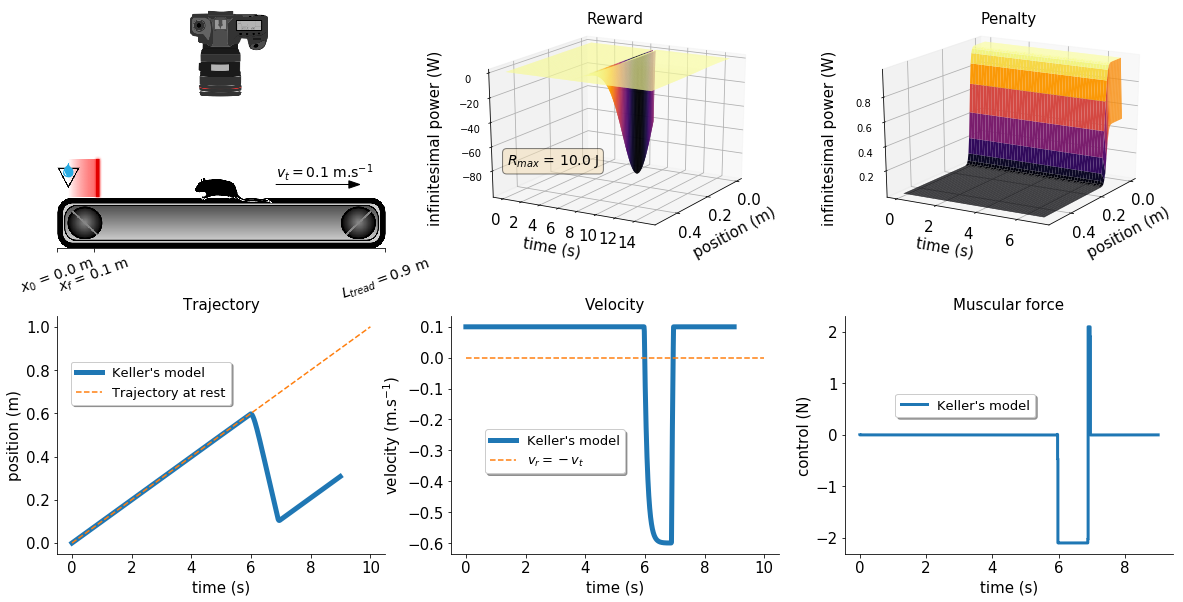

In [63]:
limit=900

#GENERATE FIGURE
fig3 = plt.figure(figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=2)
gs = fig3.add_gridspec(6, 6)

# SCHEME OF THE TASK
f3_ax1 = fig3.add_subplot(gs[:3, :2])
img1 = mpimg.imread('experimental_setup.png')
f3_ax1.imshow(img1,aspect='auto')
f3_ax1.spines['top'].set_visible(False)
f3_ax1.spines['right'].set_visible(False) 
f3_ax1.spines['left'].set_visible(False) 
f3_ax1.set_yticks([])
f3_ax1.set_xticks([x0*1000,xf*1000,900])
plt.xticks(rotation=20)
f3_ax1.set_xticklabels([r'$x_0$ = '+str(x0)+' m',r'$x_f$ = '+str(xf)+' m',r'$L_{tread} = 0.9$ m'],size=14)
plt.arrow(600,470,200,0,head_width=20.0,color='black')
plt.text(600,450,r'$v_t = $'+str(vtapis)+' m.s$^{-1}$',size=14)


#REWARD FUNCTION
f3_ax2 = fig3.add_subplot(gs[:3, 2:4],projection="3d")
f3_ax2.set_title('Reward',size=15)
t = np.linspace(0,15,100)
x = np.linspace(0.0,0.50,100)
X,T = np.meshgrid(x,t)
Z = reward_function2(t=T,dt=0.1,reward_max=reward_max,x=X,sigma_x=0.1,mu_x=0.1)
f3_ax2.plot_surface(X, T, Z, rstride=1, cstride=1,cmap='inferno', edgecolor='none')
plt.xlabel('position (m)',size=15,labelpad=10)
plt.xticks(np.arange(0, 0.5, step=0.2))
plt.ylabel('time (s)',size=15,labelpad=10)
f3_ax2.zaxis.set_rotate_label(False) 
f3_ax2.set_zlabel('infinitesimal power (W)',size=15,labelpad=10,rotation=90)
#f3_ax2.set_zticks(np.linspace(0,-10.0,5))
f3_ax2.view_init(20, 30)
plt.xticks(size = 15)
plt.yticks(size = 15)
f3_ax2.text2D(0.17, 0.35, r"$R_{max}$ = "+str(reward_max)+' J', transform=f3_ax2.transAxes,size=14,bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

#PENALTY FUNCTION
f3_ax3 = fig3.add_subplot(gs[:3, 4:],projection='3d')
f3_ax3.set_title('Penalty',size=15)
x = np.linspace(0.0,0.5,100)
t = np.linspace(0.0,7.0)
X,T = np.meshgrid(x,t)
Z = penalty2(t=T,mut=7.0,kt=100,height=1.0,x=X,mux=0.1,kx=100)
f3_ax3.plot_surface(X, T, Z, rstride=1, cstride=1,cmap='inferno', edgecolor='none')
plt.xlabel('position (m)',size=15,labelpad=10)
plt.xticks(np.arange(0, 0.5, step=0.2))
plt.yticks(np.arange(0, 7, step=2))
plt.ylabel('time (s)',size=15,labelpad=10)
f3_ax3.zaxis.set_rotate_label(False) 
f3_ax3.set_zlabel('infinitesimal power (W)',size=15,labelpad=10,rotation=90)
#f3_ax3.set_zticks(np.linspace(0,4,5))
f3_ax3.view_init(20, 30)
plt.xticks(size = 15)
plt.yticks(size = 15)


#TRAJECTORY
f3_ax4 = fig3.add_subplot(gs[3:,:2])
f3_ax4.set_title('Trajectory',size=15)
plt.plot(tk[:limit],xk[:limit],label="Keller's model",linewidth=5.0,alpha=1.0)
plt.plot(tk,[0.1*t for t in tk],'--',label='Trajectory at rest')
f3_ax4.spines['top'].set_visible(False)
f3_ax4.spines['right'].set_visible(False) 
f3_ax4.legend(fontsize=13,bbox_to_anchor=(.55, .6),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylabel('position (m)',size=15)
plt.xlabel('time (s)',size=15)


#VELOCITY
f3_ax5 = fig3.add_subplot(gs[3:, 2:4])
f3_ax5.set_title('Velocity',size=15)
plt.plot(tk[:limit],xdotk[:limit],label="Keller's model",linewidth=5.0)
plt.plot(tk,[0.0 for t in tk],'--',label=r'$v_r=-v_t$')
plt.ylabel(r'velocity (m.s$^{-1}$)',size=15)
plt.xlabel('time (s)',size = 15)
f3_ax5.spines['top'].set_visible(False)
f3_ax5.spines['right'].set_visible(False) 
f3_ax5.legend(fontsize=13,bbox_to_anchor=(.55, .55),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)


#Muscular force
f3_ax6 = fig3.add_subplot(gs[3:, 4:])
f3_ax6.set_title('Muscular force',size=15)
plt.step(tak[:limit],[0.3*f for f in acck][:limit],label="Keller's model",linewidth=3.0)
plt.ylabel(r'control (N)',size=15)
plt.xlabel('time (s)',size=15)
f3_ax6.spines['top'].set_visible(False)
f3_ax6.spines['right'].set_visible(False) 
f3_ax6.legend(fontsize=13,bbox_to_anchor=(.6, .7),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.savefig('Results_tau'+str(tau)+'sigma_'+str(sigma)+'.pdf')
plt.show()

# Testing $\tau$'s influence

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    56996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6000

Total number of variables............................:    13010
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     9006
                     variables with only upper bounds:        0
Total number of equality constraints.................:    12000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  89 -4.2406299e+009 1.07e-005 2.50e-004  -5.7 1.05e+009 -12.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -4.6345028e+009 1.60e-005 2.50e-004  -5.7 3.94e+008 -12.2 1.00e+000 1.00e+000f  1
  91 -4.6364563e+009 5.68e-005 8.33e-001  -5.7 1.95e+006 -13.2 1.00e+000 1.00e+000f  1
  92 -5.1626546e+009 2.78e-003 4.19e-001  -5.7 7.34e+008 -13.6 1.00e+000 7.17e-001f  1
  93 -9.1349670e+009 1.11e-003 1.80e-002  -5.7 3.97e+009 -13.2 1.00e+000 1.00e+000f  1
  94 -1.0625880e+010 7.62e-004 5.44e-003  -5.7 1.49e+009 -12.8 1.00e+000 1.00e+000f  1
  95 -1.0628476e+010 2.10e-004 3.09e-001  -5.7 2.60e+006 -10.1 1.00e+000 1.00e+000f  1
  96 -1.0638334e+010 3.13e-005 2.53e-004  -5.7 9.86e+006 -10.6 1.00e+000 1.00e+000f  1
  97 -1.0667908e+010 3.36e-005 2.50e-004  -5.7 2.96e+007 -11.1 1.00e+000 1.00e+000f  1
  98 -1.0756629e+010 3.74e-005 2.50e-004  -5.7 8.87e+007 -11.6 1.00e+000 1.00e+000f  1
  99 -1.0765354e+010 6.69e-004 7.82e+000  -5.7 8.

 178 -3.0759667e+010 9.84e-005 2.50e-004  -5.7 1.67e+008 -11.8 1.00e+000 1.00e+000f  1
 179 -3.0822240e+010 9.84e-005 2.50e-004  -5.7 6.26e+007 -11.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -3.0822378e+010 9.71e-005 2.50e-004  -5.7 1.37e+005  -8.7 1.00e+000 1.00e+000f  1
 181 -3.0822790e+010 9.84e-005 2.50e-004  -5.7 4.12e+005  -9.2 1.00e+000 1.00e+000f  1
 182 -3.0824027e+010 1.15e-004 2.50e-004  -5.7 1.24e+006  -9.7 1.00e+000 1.00e+000f  1
 183 -3.0827740e+010 1.01e-004 2.50e-004  -5.7 3.71e+006 -10.2 1.00e+000 1.00e+000f  1
 184 -3.0838876e+010 8.47e-005 2.50e-004  -5.7 1.11e+007 -10.6 1.00e+000 1.00e+000f  1
 185 -3.0872286e+010 9.12e-005 2.50e-004  -5.7 3.34e+007 -11.1 1.00e+000 1.00e+000f  1
 186 -3.0972515e+010 1.15e-004 2.50e-004  -5.7 1.00e+008 -11.6 1.00e+000 1.00e+000f  1
 187 -3.1273203e+010 1.10e-004 2.52e-004  -5.7 3.01e+008 -12.1 1.00e+000 1.00e+000f  1
 188 -3.1274748e+010 8.47e-005 4.20e-001  -5.7 1.

 272 -5.6997475e+010 1.62e-002 6.45e-001  -5.7 2.30e+009 -16.1 1.79e-001 3.78e-001f  1
 273 -5.7439532e+010 3.80e-002 4.07e-001  -5.7 7.10e+008 -16.5 1.65e-001 6.22e-001f  1
 274 -5.7440245e+010 3.58e-002 3.75e-001  -5.7 1.25e+007 -17.5 6.76e-002 5.68e-002f  1
 275 -5.7440248e+010 3.54e-002 4.70e-001  -5.7 2.53e+005 -16.2 2.42e-001 1.22e-002f  1
 276 -5.8307649e+010 4.84e-002 4.91e+000  -5.7 1.87e+009 -16.6 2.61e-003 4.64e-001f  1
 277 -5.8307739e+010 2.28e-002 1.64e+000  -5.7 1.35e+005 -16.2 4.05e-001 6.69e-001f  1
 278 -5.8307885e+010 8.56e-003 9.69e+003  -5.7 2.23e+005 -14.9 5.20e-006 6.57e-001f  1
 279 -6.0297960e+010 1.28e-002 4.64e+003  -5.7 3.82e+009 -15.4 3.96e-001 5.21e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -6.0298811e+010 8.64e-003 3.14e+003  -5.7 2.63e+006 -16.3 1.00e+000 3.23e-001f  1
 281 -6.0736992e+010 1.22e-003 3.97e-002  -5.7 4.38e+008 -12.3 9.86e-001 1.00e+000f  1
 282 -6.0738169e+010 1.90e-004 8.40e-001  -5.7 1.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370 -7.3010974e+010 1.87e-003 2.83e+004  -5.7 3.07e+009 -13.1 7.14e-006 1.87e-001f  1
 371 -7.3092073e+010 1.44e-003 2.74e+004  -5.7 2.71e+009 -13.6 6.87e-003 3.00e-002f  1
 372 -7.3092078e+010 1.43e-003 2.72e+004  -5.7 9.19e+005 -14.0 4.35e-002 6.41e-003f  1
 373 -7.3092094e+010 1.11e-003 1.41e+004  -5.7 6.66e+004 -14.5 7.95e-007 2.27e-001f  1
 374 -7.3094510e+010 1.11e-003 1.40e+004  -5.7 1.26e+009 -15.0 8.95e-008 1.91e-003f  1
 375 -7.3132871e+010 9.36e-004 1.47e+004  -5.7 1.09e+009 -13.7 8.39e-007 3.51e-002f  1
 376 -7.3135630e+010 9.21e-004 1.47e+004  -5.7 4.17e+009 -14.1 7.25e-009 6.61e-004f  1
 377 -7.3148111e+010 8.89e-004 1.03e+004  -5.7 6.52e+008 -12.8 1.30e-007 1.91e-002f  1
 378 -7.3148996e+010 8.83e-004 1.03e+004  -5.7 1.20e+009 -13.3 2.65e-009 7.36e-004f  1
 379 -7.3162378e+010 7.46e-004 2.49e+004  -5.7 3.50e+008 -13.8 7.08e-008 3.83e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

 461 -7.6983386e+010 4.10e-003 7.72e+003  -5.7 4.71e+009 -16.4 1.44e-002 4.33e-006f  1
 462 -7.7191310e+010 2.67e-003 5.00e+003  -5.7 5.91e+008 -16.9 3.99e-004 3.52e-001f  1
 463 -7.7194517e+010 2.82e-003 5.00e+003  -5.7 5.03e+009 -13.8 1.91e-001 6.38e-004f  1
 464 -7.7209391e+010 2.75e-003 4.97e+003  -5.7 2.05e+009 -13.4 8.96e-002 7.26e-003f  1
 465 -7.7247454e+010 2.69e-003 4.87e+003  -5.7 1.94e+009 -12.9 2.55e-002 1.96e-002f  1
 466 -7.7247529e+010 2.63e-003 4.87e+003  -5.7 2.04e+009 -13.4 6.92e-003 3.66e-005f  1
 467 -7.7265563e+010 2.75e-003 4.84e+003  -5.7 3.32e+009 -13.9 4.08e-005 5.44e-003f  1
 468 -7.7475623e+010 2.39e-003 4.27e+003  -5.7 1.77e+009 -13.5 8.13e-004 1.19e-001f  1
 469 -7.7480203e+010 2.39e-003 4.26e+003  -5.7 3.29e+009 -13.9 6.08e-003 1.39e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470 -7.7601709e+010 2.33e-003 4.10e+003  -5.7 3.19e+009 -13.5 1.40e-003 3.80e-002f  1
 471 -7.7606154e+010 2.46e-003 4.00e+003  -5.7 1.

 549 -9.4427918e+010 2.79e-004 2.53e-004  -5.7 1.46e+008 -11.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550 -9.4429307e+010 2.51e-004 8.44e-001  -5.7 1.39e+006 -11.8 1.00e+000 1.00e+000f  1
 551 -9.4491082e+010 2.51e-004 4.21e-004  -5.7 6.18e+007 -11.4 1.00e+000 1.00e+000f  1
 552 -9.4676408e+010 2.51e-004 2.50e-004  -5.7 1.85e+008 -11.9 1.00e+000 1.00e+000f  1
 553 -9.5232387e+010 2.79e-004 2.50e-004  -5.7 5.56e+008 -12.3 1.00e+000 1.00e+000f  1
 554 -9.5440879e+010 2.98e-004 2.51e-004  -5.7 2.08e+008 -11.9 1.00e+000 1.00e+000f  1
 555 -9.6066268e+010 2.51e-004 5.24e-004  -5.7 6.25e+008 -12.4 1.00e+000 1.00e+000f  1
 556 -9.7942698e+010 2.51e-004 2.50e-004  -5.7 1.88e+009 -12.9 1.00e+000 1.00e+000f  1
 557 -9.7943903e+010 2.51e-004 5.13e-001  -5.7 1.20e+006 -12.9 1.00e+000 1.00e+000f  1
 558 -9.8384398e+010 3.47e-003 4.04e-001  -5.7 2.07e+009 -13.4 5.68e-001 2.13e-001f  1
 559 -9.8567713e+010 3.26e-003 2.51e-001  -5.7 4.

 639 -1.1501965e+011 3.73e-004 1.35e-003  -5.7 3.38e+008 -12.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640 -1.1514655e+011 3.92e-004 2.50e-004  -5.7 1.27e+008 -11.7 1.00e+000 1.00e+000f  1
 641 -1.1552726e+011 3.59e-004 2.50e-004  -5.7 3.81e+008 -12.2 1.00e+000 1.00e+000f  1
 642 -1.1567002e+011 3.59e-004 2.50e-004  -5.7 1.43e+008 -11.8 1.00e+000 1.00e+000f  1
 643 -1.1609807e+011 4.95e-004 4.49e-004  -5.7 4.28e+008 -12.2 1.00e+000 1.00e+000f  1
 644 -1.1610643e+011 3.99e-004 6.68e+000  -5.7 8.36e+006 -13.2 1.00e+000 1.00e+000f  1
 645 -1.1628700e+011 3.62e-004 1.23e-003  -5.7 1.81e+008 -11.9 1.00e+000 1.00e+000f  1
 646 -1.1628740e+011 3.73e-004 2.50e-004  -5.7 3.97e+005  -9.2 1.00e+000 1.00e+000f  1
 647 -1.1628859e+011 4.01e-004 2.50e-004  -5.7 1.19e+006  -9.7 1.00e+000 1.00e+000f  1
 648 -1.1629216e+011 3.73e-004 2.50e-004  -5.7 3.57e+006 -10.2 1.00e+000 1.00e+000f  1
 649 -1.1630288e+011 3.59e-004 2.50e-004  -5.7 1.

 726 -1.2682479e+011 3.73e-004 4.49e-004  -5.7 6.36e+008 -12.4 1.00e+000 1.00e+000f  1
 727 -1.2682988e+011 4.01e-004 4.23e+000  -5.7 5.10e+006 -12.5 1.00e+000 1.00e+000f  1
 728 -1.2897785e+011 4.66e-004 4.33e-004  -5.7 2.15e+009 -12.9 1.00e+000 1.00e+000f  1
 729 -1.2907854e+011 3.98e-004 2.50e-004  -5.7 1.01e+008 -11.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730 -1.2938060e+011 3.73e-004 2.53e-004  -5.7 3.02e+008 -12.1 1.00e+000 1.00e+000f  1
 731 -1.2938401e+011 3.73e-004 1.15e+000  -5.7 3.41e+006 -13.0 1.00e+000 1.00e+000f  1
 732 -1.2972388e+011 1.89e-003 2.63e-001  -5.7 3.40e+008 -12.6 1.00e+000 1.00e+000f  1
 733 -1.2981040e+011 2.32e-003 2.15e-001  -5.7 6.47e+008 -13.1 1.00e+000 1.34e-001f  1
 734 -1.2981369e+011 2.29e-003 2.13e-001  -5.7 5.43e+008 -12.7 2.80e-002 6.07e-003f  1
 735 -1.2981378e+011 2.28e-003 2.52e-001  -5.7 1.14e+007 -10.0 1.24e-001 7.18e-003f  1
 736 -1.2981525e+011 1.83e-003 4.02e-001  -5.7 7.

 818 -1.5289071e+011 4.95e-004 3.25e-004  -5.7 9.10e+008 -12.6 1.00e+000 1.00e+000f  1
 819 -1.5289907e+011 4.95e-004 6.32e+000  -5.7 8.36e+006 -12.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820 -1.5369666e+011 1.19e-001 2.76e+000  -5.7 1.41e+009 -13.1 1.18e-001 5.66e-001f  1
 821 -1.5384783e+011 9.51e-002 1.97e+000  -5.7 5.33e+008 -13.6 9.77e-006 2.83e-001f  1
 822 -1.5384896e+011 6.91e-002 3.33e-001  -5.7 1.13e+006 -14.5 1.00e+000 1.00e+000f  1
 823 -1.5433483e+011 5.85e-004 2.65e-004  -5.7 4.86e+008 -12.3 1.00e+000 1.00e+000f  1
 824 -1.5433645e+011 4.95e-004 1.08e+000  -5.7 1.62e+006 -11.4 1.00e+000 1.00e+000f  1
 825 -1.5453530e+011 1.82e-003 3.28e-002  -5.7 1.99e+008 -11.9 1.00e+000 1.00e+000f  1
 826 -1.5461217e+011 1.56e-003 5.78e-004  -5.7 7.69e+007 -11.5 1.00e+000 1.00e+000f  1
 827 -1.5484276e+011 5.24e-004 2.62e-004  -5.7 2.31e+008 -12.0 1.00e+000 1.00e+000f  1
 828 -1.5484476e+011 5.97e-004 1.37e+000  -5.7 2.

 904 -1.6586005e+011 7.11e-003 3.44e-001  -5.7 1.18e+006  -9.7 4.10e-005 1.87e-001f  1
 905 -1.6586095e+011 5.31e-003 2.57e-001  -5.7 3.58e+006 -10.2 1.58e-001 2.53e-001f  1
 906 -1.6586322e+011 4.19e-003 3.32e-001  -5.7 1.07e+007 -10.6 6.01e-001 2.11e-001f  1
 907 -1.6589540e+011 1.04e-003 2.94e-003  -5.7 3.22e+007 -11.1 9.91e-001 1.00e+000f  1
 908 -1.6599193e+011 5.06e-004 2.50e-004  -5.7 9.65e+007 -11.6 1.00e+000 1.00e+000f  1
 909 -1.6628154e+011 4.95e-004 2.50e-004  -5.7 2.90e+008 -12.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910 -1.6714729e+011 5.23e-004 4.94e-003  -5.7 8.66e+008 -12.5 1.00e+000 1.00e+000f  1
 911 -1.6747285e+011 6.03e-004 4.79e-004  -5.7 3.26e+008 -12.1 1.00e+000 1.00e+000f  1
 912 -1.6747389e+011 5.36e-004 4.97e-001  -5.7 1.05e+006 -11.3 1.00e+000 1.00e+000f  1
 913 -1.6760972e+011 1.78e-003 5.91e-003  -5.7 1.36e+008 -11.7 1.00e+000 1.00e+000f  1
 914 -1.6802207e+011 1.82e-003 3.56e-003  -5.7 4.

 991 -1.8093410e+011 5.22e-004 5.94e-001  -5.7 9.90e+005 -12.4 1.00e+000 1.00e+000f  1
 992 -1.8125166e+011 5.84e-003 3.48e-001  -5.7 7.62e+008 -12.8 2.85e-001 4.17e-001f  1
 993 -1.8133289e+011 5.72e-003 6.67e-003  -5.7 8.12e+007 -11.5 1.00e+000 1.00e+000f  1
 994 -1.8157654e+011 5.23e-004 2.95e-004  -5.7 2.44e+008 -12.0 1.00e+000 1.00e+000f  1
 995 -1.8230753e+011 4.95e-004 3.01e-004  -5.7 7.31e+008 -12.5 1.00e+000 1.00e+000f  1
 996 -1.8231071e+011 4.95e-004 9.59e-001  -5.7 3.17e+006 -13.4 1.00e+000 1.00e+000f  1
 997 -1.8454120e+011 1.58e-002 1.80e-001  -5.7 2.23e+009 -13.0 3.82e-001 1.00e+000f  1
 998 -1.8561151e+011 5.12e-002 2.81e-001  -5.7 4.84e+009 -13.5 6.05e-001 2.21e-001f  1
 999 -1.8566538e+011 5.05e-002 2.89e-001  -5.7 1.08e+009 -13.9 3.78e-001 4.99e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 -1.8566546e+011 4.71e-002 4.19e-001  -5.7 1.03e+006 -12.2 3.36e-005 6.82e-002f  1
1001 -1.8566557e+011 5.24e-002 2.68e-001  -5.7 3.

1089 -2.1202434e+011 6.04e-004 2.36e-003  -5.7 1.04e+009 -12.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1090 -2.1203170e+011 4.95e-004 5.38e+000  -5.7 7.41e+006 -13.6 1.00e+000 9.94e-001f  1
1091 -2.1220451e+011 2.63e-003 4.30e+000  -5.7 8.58e+008 -14.1 2.84e-001 2.01e-001f  1
1092 -2.1220457e+011 2.25e-003 3.81e+000  -5.7 4.82e+005 -14.5 2.56e-005 1.14e-001f  1
1093 -2.1326025e+011 1.43e-002 4.82e-001  -5.7 1.06e+009 -15.0 6.96e-001 9.97e-001f  1
1094 -2.1326106e+011 6.53e-003 5.24e-001  -5.7 1.48e+006 -16.0 9.50e-001 5.44e-001f  1
1095 -2.1327756e+011 6.39e-003 5.15e-001  -5.7 9.65e+008 -16.4 3.90e-001 1.71e-002f  1
1096 -2.1334831e+011 5.19e-003 4.13e-001  -5.7 3.88e+008 -16.9 4.81e-002 1.82e-001f  1
1097 -2.1361076e+011 4.55e-003 3.86e-001  -5.7 2.75e+009 -17.4 6.40e-002 9.53e-002f  1
1098 -2.1361076e+011 4.55e-003 4.35e-001  -5.7 5.43e+008 -17.9 9.32e-003 3.89e-006f  1
1099 -2.1361260e+011 4.54e-003 4.80e-001  -5.7 2.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180 -2.1702099e+011 8.43e-002 3.74e-001  -5.7 3.07e+007 -11.1 1.02e-001 6.32e-002f  1
1181 -2.1702199e+011 8.36e-002 4.27e-001  -5.7 9.21e+007 -11.6 2.05e-001 1.09e-002f  1
1182 -2.1708479e+011 6.46e-002 5.00e+001  -5.7 2.76e+008 -12.0 8.97e-005 2.27e-001f  1
1183 -2.1711825e+011 4.37e-002 3.39e+001  -5.7 1.04e+008 -11.6 8.93e-003 3.23e-001f  1
1184 -2.1720595e+011 3.17e-002 1.25e+004  -5.7 3.12e+008 -12.1 9.10e-007 2.81e-001f  1
1185 -2.1720894e+011 3.21e-002 1.23e+004  -5.7 4.37e+006 -11.7 1.73e-006 1.28e-002H  1
1186 -2.1721000e+011 3.18e-002 1.22e+004  -5.7 1.01e+008 -12.1 1.65e-002 1.05e-002f  1
1187 -2.1721001e+011 3.17e-002 1.21e+004  -5.7 6.25e+005 -10.8 2.01e-002 4.40e-003f  1
1188 -2.1721003e+011 3.13e-002 1.21e+004  -5.7 1.46e+006 -10.9 1.03e-006 1.44e-002f  1
1189 -2.1721003e+011 3.15e-002 1.21e+004  -5.7 6.87e+005 -11.8 3.73e-007 1.68e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

1266 -2.3168451e+011 7.65e-004 2.50e-004  -5.7 1.51e+009 -12.8 1.00e+000 1.00e+000f  1
1267 -2.3225234e+011 8.19e-004 3.24e-004  -5.7 5.68e+008 -12.4 1.00e+000 1.00e+000f  1
1268 -2.3246529e+011 7.39e-004 2.60e-004  -5.7 2.13e+008 -11.9 1.00e+000 1.00e+000f  1
1269 -2.3246870e+011 7.39e-004 1.20e+000  -5.7 3.40e+006 -12.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1270 -2.3441514e+011 3.00e-003 7.49e-001  -5.7 5.17e+009 -13.4 1.00e+000 3.76e-001f  1
1271 -2.3441515e+011 3.00e-003 7.49e-001  -5.7 2.88e+009 -13.8 4.60e-003 1.85e-006f  1
1272 -2.3441538e+011 3.24e-003 7.48e-001  -5.7 1.25e+009 -14.3 4.18e-003 1.83e-004f  1
1273 -2.3441633e+011 2.93e-003 7.48e-001  -5.7 1.39e+009 -14.8 1.82e-005 6.84e-004f  1
1274 -2.3443021e+011 3.00e-003 7.42e-001  -5.7 1.66e+009 -15.3 1.30e-001 8.38e-003f  1
1275 -2.3443386e+011 2.75e-003 7.40e-001  -5.7 1.35e+009 -15.7 2.40e-003 2.70e-003f  1
1276 -2.3443386e+011 3.24e-003 7.39e-001  -5.7 2.

1355 -2.3817141e+011 1.76e-003 9.47e+000  -5.7 1.09e+006 -15.6 1.00e+000 1.00e+000f  1
1356 -2.3875712e+011 1.37e-003 6.11e+000  -5.7 1.65e+009 -14.2 7.00e-001 3.55e-001f  1
1357 -2.3975629e+011 3.71e-002 1.12e+000  -5.7 1.22e+009 -12.9 1.35e-001 8.17e-001f  1
1358 -2.3975715e+011 2.93e-002 5.64e+000  -5.7 1.01e+006 -13.4 1.00e+000 8.52e-001f  1
1359 -2.3978690e+011 3.40e-002 1.55e+001  -5.7 1.57e+009 -13.9 2.36e-004 1.89e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1360 -2.3978761e+011 3.38e-002 1.55e+001  -5.7 2.58e+009 -13.4 5.83e-009 2.77e-004f  1
1361 -2.3978895e+011 3.35e-002 2.57e+004  -5.7 2.85e+008 -13.9 6.73e-008 4.69e-003f  1
1362 -2.3978922e+011 3.39e-002 2.57e+004  -5.7 1.17e+008 -11.7 1.89e-003 2.26e-003f  1
1363 -2.3979040e+011 3.37e-002 2.56e+004  -5.7 3.32e+008 -12.2 4.89e-003 3.55e-003f  1
1364 -2.3980708e+011 3.28e-003 4.62e+006  -5.7 1.67e+007 -10.8 5.52e-008 1.00e+000f  1
1365 -2.3985714e+011 7.39e-004 3.91e-004  -5.7 5.

1442 -2.5633934e+011 9.11e-002 1.64e+002  -5.7 6.33e+005 -16.4 4.18e-006 8.66e-002f  1
1443 -2.5634001e+011 9.09e-002 9.56e+001  -5.7 3.65e+008 -16.8 4.12e-008 1.86e-003f  1
1444 -2.5634005e+011 9.04e-002 1.31e+002  -5.7 2.47e+007 -11.0 1.80e-007 1.52e-003f  1
1445 -2.5634014e+011 9.04e-002 4.02e+002  -5.7 7.43e+007 -11.5 6.68e-009 1.21e-003f  1
1446 -2.5634074e+011 9.04e-002 4.02e+002  -5.7 1.56e+009 -12.0 2.37e-004 3.89e-004f  1
1447 -2.5691743e+011 1.41e-002 6.96e+001  -5.7 6.71e+008 -12.4 1.33e-002 8.59e-001f  1
1448 -2.5716846e+011 7.39e-004 7.19e-002  -5.7 2.51e+008 -12.0 5.88e-001 1.00e+000f  1
1449 -2.5726262e+011 7.39e-004 2.51e-004  -5.7 9.42e+007 -11.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1450 -2.5754508e+011 7.39e-004 2.53e-004  -5.7 2.82e+008 -12.1 1.00e+000 1.00e+000f  1
1451 -2.5755494e+011 7.26e-004 4.19e+000  -5.7 9.86e+006 -13.0 1.00e+000 1.00e+000f  1
1452 -2.5772945e+011 2.76e-003 3.83e+000  -5.7 2.

1534 -2.7635476e+011 5.25e-002 8.85e-001  -5.7 2.68e+006 -10.9 3.85e-004 2.92e-001f  1
1535 -2.7635476e+011 6.35e-002 8.74e-001  -5.7 1.42e+003  -5.1 2.42e-004 1.26e-002f  1
1536 -2.7635476e+011 5.93e-002 8.12e-001  -5.7 8.46e+001  -5.5 6.97e-002 7.07e-002f  1
1537 -2.7635476e+011 5.12e-002 6.72e-001  -5.7 2.54e+002  -6.0 4.60e-001 1.72e-001f  1
1538 -2.7635476e+011 3.50e-002 2.25e+003  -5.7 7.60e+002  -6.5 3.42e-005 1.00e+000f  1
1539 -2.7635476e+011 9.83e-004 2.50e-004  -5.7 2.28e+003  -7.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1540 -2.7635477e+011 8.20e-004 2.50e-004  -5.7 6.84e+003  -7.4 1.00e+000 1.00e+000f  1
1541 -2.7635479e+011 9.83e-004 2.50e-004  -5.7 2.05e+004  -7.9 1.00e+000 1.00e+000f  1
1542 -2.7635485e+011 9.70e-004 2.50e-004  -5.7 6.16e+004  -8.4 1.00e+000 1.00e+000f  1
1543 -2.7635503e+011 9.83e-004 2.50e-004  -5.7 1.85e+005  -8.9 1.00e+000 1.00e+000f  1
1544 -2.7635559e+011 9.83e-004 2.50e-004  -5.7 5.

1626 -2.8643098e+011 9.70e-004 2.70e-004  -5.7 2.00e+008 -11.9 1.00e+000 1.00e+000f  1
1627 -2.8643285e+011 1.07e-003 9.13e-001  -5.7 1.87e+006 -12.9 1.00e+000 1.00e+000f  1
1628 -2.8746436e+011 7.56e-002 6.11e-001  -5.7 1.90e+009 -13.3 1.06e-001 5.43e-001f  1
1629 -2.8746647e+011 7.69e-002 7.11e-001  -5.7 2.11e+006 -10.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1630 -2.8750207e+011 7.68e-004 2.84e-004  -5.7 3.56e+007 -11.2 1.00e+000 1.00e+000f  1
1631 -2.8760888e+011 1.01e-003 2.51e-004  -5.7 1.07e+008 -11.6 1.00e+000 1.00e+000f  1
1632 -2.8764894e+011 8.90e-004 2.50e-004  -5.7 4.01e+007 -11.2 1.00e+000 1.00e+000f  1
1633 -2.8776910e+011 9.70e-004 2.50e-004  -5.7 1.20e+008 -11.7 1.00e+000 1.00e+000f  1
1634 -2.8777229e+011 9.70e-004 2.08e+000  -5.7 3.19e+006 -10.8 1.00e+000 1.00e+000f  1
1635 -2.8782298e+011 8.37e-004 2.88e-004  -5.7 5.07e+007 -11.3 1.00e+000 1.00e+000f  1
1636 -2.8782522e+011 9.43e-004 1.11e+000  -5.7 2.

1719 -2.9388923e+011 1.62e-002 1.78e+003  -5.7 1.40e+008 -11.8 1.44e-009 2.00e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1720 -2.9388930e+011 1.67e-002 1.78e+003  -5.7 6.03e+009 -12.2 3.92e-009 1.25e-005f  1
1721 -2.9389075e+011 1.62e-002 1.78e+003  -5.7 1.12e+009 -12.7 1.74e-003 1.29e-003f  1
1722 -2.9389076e+011 1.62e-002 1.78e+003  -5.7 1.72e+012 -12.3 3.44e-011 5.20e-009f  1
1723 -2.9389337e+011 1.64e-002 1.47e+004  -5.7 9.99e+008 -12.8 3.26e-008 2.62e-003f  1
1724 -2.9421273e+011 5.63e-003 5.73e+003  -5.7 5.25e+008 -12.3 4.96e-003 6.08e-001f  1
1725 -2.9421296e+011 6.42e-003 5.73e+003  -5.7 7.97e+011 -12.8 1.44e-004 2.86e-007f  1
1726 -2.9451090e+011 1.38e-003 1.46e+003  -5.7 4.00e+008 -12.4 6.59e-004 7.45e-001f  1
1727 -2.9452174e+011 1.78e-003 1.46e+003  -5.7 1.71e+011 -12.0 3.94e-004 6.33e-005f  1
1728 -2.9452175e+011 1.58e-003 1.46e+003  -5.7 8.46e+007 -11.5 1.26e-004 4.77e-005f  1
1729 -2.9469279e+011 1.16e-003 4.79e+002  -5.7 2.

1808 -3.0495001e+011 2.53e-003 5.98e-001  -5.7 4.71e+008 -14.7 1.16e-004 2.70e-003f  1
1809 -3.0495572e+011 3.24e-003 5.96e-001  -5.7 7.93e+009 -14.3 2.36e-004 7.21e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1810 -3.0495573e+011 3.00e-003 5.96e-001  -5.7 1.99e+009 -14.8 1.10e-008 4.47e-006f  1
1811 -3.0495578e+011 3.00e-003 2.60e+000  -5.7 8.28e+008 -15.3 6.25e-008 5.46e-005f  1
1812 -3.0495579e+011 2.75e-003 6.21e+001  -5.7 2.59e+008 -15.7 5.32e-010 4.74e-005f  1
1813 -3.0495596e+011 2.75e-003 9.33e+001  -5.7 1.37e+009 -16.2 7.49e-009 1.27e-004f  1
1814 -3.0495609e+011 3.24e-003 9.33e+001  -5.7 1.63e+009 -16.7 8.83e-010 7.80e-005f  1
1815 -3.0495631e+011 3.00e-003 3.38e+001  -5.7 2.63e+009 -15.4 5.65e-009 8.38e-005f  1
1816 -3.0495641e+011 3.00e-003 4.07e+002  -5.7 5.52e+008 -14.9 7.07e-010 1.78e-004f  1
1817 -3.0495717e+011 2.75e-003 4.07e+002  -5.7 3.21e+009 -15.4 1.09e-008 2.36e-004f  1
1818 -3.0495729e+011 2.51e-003 1.84e+002  -5.7 8.

1894 -3.2355528e+011 1.03e-002 3.36e+000  -5.7 1.88e+009 -13.2 1.14e-003 1.01e-002f  1
1895 -3.2355590e+011 1.06e-002 1.27e+003  -5.7 1.04e+009 -12.8 1.67e-007 5.97e-004f  1
1896 -3.2355617e+011 1.07e-002 1.27e+003  -5.7 6.90e+007 -11.4 4.61e-003 3.88e-003f  1
1897 -3.2375982e+011 1.02e-003 1.42e+001  -5.7 2.04e+008 -11.9 1.32e-002 1.00e+000f  1
1898 -3.2382132e+011 9.83e-004 2.94e+000  -5.7 7.75e+007 -11.5 6.76e-001 7.94e-001f  1
1899 -3.2403189e+011 1.02e-003 2.76e+004  -5.7 2.26e+008 -12.0 9.40e-006 9.31e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900 -3.2451977e+011 2.00e-003 6.87e+003  -5.7 6.50e+008 -12.4 4.62e-001 7.51e-001f  1
1901 -3.2648616e+011 6.02e-003 1.37e-001  -5.7 1.97e+009 -12.9 1.00e+000 1.00e+000f  1
1902 -3.2648735e+011 1.89e-003 5.36e-001  -5.7 1.19e+006 -10.3 5.76e-001 1.00e+000f  1
1903 -3.2650114e+011 1.19e-003 2.52e-004  -5.7 1.38e+007 -10.7 1.00e+000 1.00e+000f  1
1904 -3.2654252e+011 1.23e-003 2.50e-004  -5.7 4.

1985 -3.6022424e+011 2.97e-003 4.03e+000  -5.7 4.37e+008 -12.2 2.44e-002 4.45e-002f  1
1986 -3.6036924e+011 1.69e-003 2.06e+000  -5.7 2.06e+008 -11.8 7.35e-002 7.02e-001f  1
1987 -3.6037231e+011 1.23e-003 3.98e+002  -5.7 3.37e+006 -12.8 6.28e-004 9.13e-001f  1
1988 -3.6065691e+011 1.17e-003 1.85e+002  -5.7 5.33e+008 -12.3 9.15e-001 5.34e-001f  1
1989 -3.6114223e+011 7.88e-003 1.24e+002  -5.7 1.47e+009 -12.8 8.85e-001 3.30e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1990 -3.6118462e+011 6.86e-003 1.09e+002  -5.7 3.48e+008 -13.3 2.80e-005 1.22e-001f  1
1991 -3.6125672e+011 1.18e-002 1.03e+002  -5.7 1.33e+009 -13.8 1.10e-001 5.40e-002f  1
1992 -3.6136074e+011 1.69e-002 9.48e+001  -5.7 1.26e+009 -14.3 1.10e-001 8.28e-002f  1
1993 -3.6147916e+011 1.59e-002 8.67e+001  -5.7 1.32e+009 -14.7 2.58e-005 8.95e-002f  1
1994 -3.6147964e+011 1.52e-002 1.23e+002  -5.7 4.57e+008 -15.2 1.77e-006 1.05e-003f  1
1995 -3.6148141e+011 1.55e-002 1.22e+002  -5.7 2.

2077 -3.7307841e+011 5.53e-003 3.38e-001  -5.7 5.91e+008 -12.6 2.74e-003 1.67e-002f  1
2078 -3.7307841e+011 5.51e-003 3.36e-001  -5.7 1.49e+003  -6.8 2.30e-002 3.10e-003f  1
2079 -3.7307841e+011 5.46e-003 2.22e+000  -5.7 4.47e+003  -7.3 2.87e-006 8.07e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2080 -3.7307841e+011 5.46e-003 2.22e+000  -5.7 1.34e+004  -7.7 1.88e-009 6.39e-005f  1
2081 -3.7307841e+011 5.41e-003 3.75e+002  -5.7 4.02e+004  -8.2 3.09e-008 9.08e-003f  1
2082 -3.7307841e+011 5.41e-003 3.75e+002  -5.7 1.21e+005  -8.7 5.92e-010 1.06e-004f  1
2083 -3.7307842e+011 5.36e-003 5.31e+000  -5.7 3.62e+005  -9.2 3.37e-008 9.86e-003f  1
2084 -3.7307842e+011 5.36e-003 5.31e+000  -5.7 1.09e+006  -9.6 6.68e-010 1.45e-004f  1
2085 -3.7307845e+011 5.30e-003 3.70e+002  -5.7 3.26e+006 -10.1 3.66e-008 1.06e-002f  1
2086 -3.7307845e+011 5.30e-003 3.70e+002  -5.7 9.77e+006 -10.6 7.91e-010 1.87e-004f  1
2087 -3.7307879e+011 5.24e-003 9.24e+000  -5.7 2.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2170 -3.9158192e+011 1.06e-003 2.60e-004  -5.7 1.31e+008 -11.7 1.00e+000 1.00e+000f  1
2171 -3.9197343e+011 9.83e-004 5.60e-004  -5.7 3.92e+008 -12.2 1.00e+000 1.00e+000f  1
2172 -3.9212039e+011 9.70e-004 2.50e-004  -5.7 1.47e+008 -11.8 1.00e+000 1.00e+000f  1
2173 -3.9256127e+011 9.83e-004 2.54e-004  -5.7 4.41e+008 -12.2 1.00e+000 1.00e+000f  1
2174 -3.9272660e+011 9.83e-004 2.50e-004  -5.7 1.65e+008 -11.8 1.00e+000 1.00e+000f  1
2175 -3.9322256e+011 9.83e-004 2.81e-004  -5.7 4.96e+008 -12.3 1.00e+000 1.00e+000f  1
2176 -3.9322637e+011 1.07e-003 8.69e-001  -5.7 3.80e+006 -13.3 1.00e+000 1.00e+000f  1
2177 -3.9360353e+011 2.51e-003 8.41e-001  -5.7 7.86e+009 -13.7 9.20e-002 4.80e-002f  1
2178 -3.9360862e+011 3.17e-003 8.39e-001  -5.7 2.00e+009 -13.3 6.04e-006 2.55e-003f  1
2179 -3.9361592e+011 2.59e-003 8.22e-001  -5.7 3.55e+008 -13.8 9.43e-003 2.06e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

2257 -4.1538334e+011 1.06e-003 4.12e-004  -5.7 6.55e+008 -12.4 1.00e+000 1.00e+000f  1
2258 -4.1538795e+011 1.38e-003 2.15e+000  -5.7 4.61e+006 -11.6 1.00e+000 1.00e+000f  1
2259 -4.1542250e+011 9.83e-004 1.15e-003  -5.7 3.45e+007 -11.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2260 -4.1552614e+011 1.21e-003 2.50e-004  -5.7 1.04e+008 -11.6 1.00e+000 1.00e+000f  1
2261 -4.1583708e+011 1.23e-003 2.51e-004  -5.7 3.11e+008 -12.1 1.00e+000 1.00e+000f  1
2262 -4.1595245e+011 1.23e-003 2.35e-003  -5.7 1.15e+008 -11.7 1.00e+000 1.00e+000f  1
2263 -4.1596877e+011 1.23e-003 1.36e+001  -5.7 2.99e+007 -12.6 1.00e+000 5.45e-001f  1
2264 -4.1601798e+011 1.47e-003 1.22e+000  -5.7 4.92e+007 -11.3 2.34e-001 1.00e+000f  1
2265 -4.1601846e+011 1.21e-003 1.25e+000  -5.7 4.99e+007 -11.8 1.10e-001 9.65e-003f  1
2266 -4.1646118e+011 1.09e-003 8.95e+000  -5.7 4.43e+008 -12.2 1.06e-001 1.00e+000f  1
2267 -4.1646227e+011 1.01e-003 2.96e+000  -5.7 1.

2351 -4.2197860e+011 6.53e-003 8.96e+003  -5.7 5.44e+004  -8.3 5.19e-006 2.21e-003f  1
2352 -4.2197861e+011 6.28e-003 8.61e+003  -5.7 1.61e+005  -8.8 7.12e-006 3.85e-002f  1
2353 -4.2197861e+011 6.61e-003 8.59e+003  -5.7 6.02e+004  -8.4 1.19e-004 1.98e-003f  1
2354 -4.2197861e+011 6.84e-003 8.59e+003  -5.7 2.25e+004  -8.0 1.00e-007 5.25e-005f  1
2355 -4.2197861e+011 6.72e-003 8.58e+003  -5.7 6.78e+004  -8.4 3.37e-006 1.73e-003f  1
2356 -4.2197865e+011 6.20e-003 7.88e+003  -5.7 6.02e+005  -9.4 7.56e-006 8.09e-002f  1
2357 -4.2197865e+011 6.32e-003 7.73e+003  -5.7 1.53e+002  -4.4 9.63e-005 1.85e-002f  1
2358 -4.2197865e+011 6.61e-003 7.71e+003  -5.7 1.70e+002  -4.9 1.38e-006 2.81e-003f  1
2359 -4.2197865e+011 6.40e-003 7.71e+003  -5.7 7.30e+001  -5.4 1.24e-006 8.05e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2360 -4.2197865e+011 6.90e-003 7.70e+003  -5.7 1.88e+002  -5.9 2.88e-007 4.71e-004f  1
2361 -4.2197865e+011 6.08e-003 7.69e+003  -5.7 5.

2446 -4.2197958e+011 2.42e-003 5.19e+000  -5.7 1.42e+004  -7.8 7.60e-006 5.82e-004f  1
2447 -4.2197959e+011 2.40e-003 5.04e+000  -5.7 4.19e+004  -8.2 4.57e-005 2.86e-002f  1
2448 -4.2197965e+011 1.23e-003 2.97e+000  -5.7 1.15e+005  -8.7 5.48e-003 5.97e-001f  1
2449 -4.2197966e+011 1.21e-003 2.88e+000  -5.7 4.74e+004  -8.3 2.69e-004 3.32e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2450 -4.2197966e+011 1.21e-003 2.31e+000  -5.7 1.43e+005  -8.8 2.22e-006 1.48e-004f  1
2451 -4.2197966e+011 1.29e-003 2.80e+001  -5.7 1.33e+005  -8.8 4.14e-006 2.36e-002f  1
2452 -4.2197966e+011 1.29e-003 2.80e+001  -5.7 7.56e+003  -7.5 3.90e-007 4.45e-004f  1
2453 -4.2197966e+011 1.22e-003 2.08e+001  -5.7 6.80e+004  -8.4 3.05e-007 3.94e-004f  1
2454 -4.2197970e+011 1.46e-003 1.92e+001  -5.7 5.36e+005  -9.4 2.36e-003 7.77e-002f  1
2455 -4.2197979e+011 1.06e-003 1.82e+001  -5.7 1.84e+006  -9.9 2.46e-004 5.04e-002f  1
2456 -4.2197981e+011 1.21e-003 2.04e+002  -5.7 3.

2539 -4.3634300e+011 2.89e-003 1.37e+000  -5.7 9.10e+008 -14.2 8.36e-004 4.16e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2540 -4.3758542e+011 1.13e-001 3.82e-001  -5.7 1.24e+009 -14.7 5.63e-003 1.00e+000f  1
2541 -4.3758552e+011 1.28e-001 1.05e+000  -5.7 1.20e+005 -15.2 1.00e+000 8.74e-001f  1
2542 -4.3837407e+011 1.30e-002 7.30e-001  -5.7 7.89e+008 -15.7 2.11e-001 1.00e+000f  1
2543 -4.3852975e+011 1.16e-002 6.69e-001  -5.7 9.96e+008 -16.1 6.35e-001 1.56e-001f  1
2544 -4.3886028e+011 2.37e-002 7.01e-001  -5.7 8.09e+009 -16.6 7.82e-002 4.09e-002f  1
2545 -4.3886042e+011 1.83e-002 1.34e+000  -5.7 6.66e+005 -17.1 7.77e-001 2.10e-001f  1
2546 -4.3992969e+011 3.26e-002 4.95e-001  -5.7 1.62e+009 -16.7 5.53e-001 6.62e-001f  1
2547 -4.3993207e+011 8.42e-002 2.39e+000  -5.7 2.89e+006 -11.3 7.90e-001 8.24e-001f  1
2548 -4.3993412e+011 7.50e-002 2.13e+000  -5.7 1.87e+007 -10.9 6.31e-002 1.10e-001f  1
2549 -4.3997874e+011 1.49e-002 7.02e-001  -5.7 5.

2631 -4.5169856e+011 2.51e-003 1.13e+001  -5.7 2.51e+008 -18.0 2.85e-004 5.75e-006f  1
2632 -4.5169857e+011 2.93e-003 1.13e+001  -5.7 5.66e+008 -18.5 3.44e-006 1.67e-005f  1
2633 -4.5169857e+011 2.90e-003 1.13e+001  -5.7 2.41e+008 -19.0 5.48e-005 3.10e-005f  1
2634 -4.5169878e+011 3.00e-003 1.13e+001  -5.7 4.70e+008 -19.4 3.06e-004 4.32e-004f  1
2635 -4.5169885e+011 2.02e-003 1.13e+001  -5.7 5.43e+008 -19.9 8.72e-004 1.39e-004f  1
2636 -4.5170011e+011 2.34e-003 1.02e+001  -5.7 1.30e+007 -17.3 4.47e-003 9.69e-002f  1
2637 -4.5170419e+011 2.25e-003 1.01e+001  -5.7 4.18e+008 -16.9 2.11e-003 9.77e-003f  1
2638 -4.5171305e+011 2.60e-003 1.00e+001  -5.7 1.38e+009 -17.3 1.49e-004 6.42e-003f  1
2639 -4.5171498e+011 2.26e-003 1.00e+001  -5.7 4.10e+009 -16.0 9.07e-004 4.69e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2640 -4.5171598e+011 2.22e-003 1.00e+001  -5.7 3.84e+008 -16.5 1.50e-002 2.60e-003f  1
2641 -4.5171736e+011 2.32e-003 9.97e+000  -5.7 4.

2721 -4.6536270e+011 3.00e-003 8.39e+002  -5.7 1.64e+009 -12.8 1.08e-005 2.14e-002f  1
2722 -4.6537608e+011 2.97e-003 7.93e+002  -5.7 2.42e+008 -13.3 6.02e-003 5.53e-002f  1
2723 -4.6537614e+011 2.51e-003 7.93e+002  -5.7 7.64e+009 -13.8 5.75e-002 8.06e-006f  1
2724 -4.6544427e+011 1.99e-003 7.19e+002  -5.7 7.29e+008 -12.5 3.40e-003 9.34e-002f  1
2725 -4.6545425e+011 2.60e-003 6.93e+002  -5.7 2.78e+008 -12.0 2.81e-002 3.60e-002f  1
2726 -4.6547464e+011 2.26e-003 6.74e+002  -5.7 7.23e+008 -12.5 2.25e-002 2.82e-002f  1
2727 -4.6547893e+011 2.35e-003 6.00e+002  -5.7 3.90e+007 -11.2 2.39e-002 1.10e-001f  1
2728 -4.6549082e+011 2.09e-003 5.38e+002  -5.7 1.16e+008 -11.7 3.37e-001 1.03e-001f  1
2729 -4.6550428e+011 1.50e-003 3.72e+002  -5.7 4.37e+007 -11.2 2.30e-001 3.08e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2730 -4.6556161e+011 1.61e-003 1.79e+002  -5.7 1.10e+008 -11.7 1.00e+000 5.20e-001f  1
2731 -4.6587790e+011 1.70e-003 3.48e+001  -5.7 3.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2810 -4.9424981e+011 1.29e-003 9.75e-004  -5.7 7.41e+008 -12.5 1.00e+000 1.00e+000f  1
2811 -4.9452618e+011 1.38e-003 9.92e-003  -5.7 2.76e+008 -12.0 1.00e+000 1.00e+000f  1
2812 -4.9463038e+011 1.72e-003 2.50e-004  -5.7 1.04e+008 -11.6 1.00e+000 1.00e+000f  1
2813 -4.9463090e+011 1.43e-003 3.32e-001  -5.7 5.20e+005 -12.6 1.00e+000 1.00e+000f  1
2814 -4.9509038e+011 3.00e-003 2.24e-001  -5.7 1.41e+009 -13.1 9.82e-001 3.25e-001f  1
2815 -4.9511576e+011 3.32e-003 2.10e-001  -5.7 4.15e+008 -12.6 1.81e-001 6.11e-002f  1
2816 -4.9566110e+011 4.33e-003 1.61e-001  -5.7 2.13e+009 -13.1 5.78e-002 2.56e-001f  1
2817 -4.9566110e+011 4.30e-003 1.60e-001  -5.7 1.02e+003  -5.3 1.30e-002 6.49e-003f  1
2818 -4.9566110e+011 2.49e-003 9.30e-002  -5.7 1.36e+002  -5.7 1.00e+000 4.21e-001f  1
2819 -4.9566110e+011 1.50e-003 4.69e-004  -5.7 4.08e+002  -6.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

2897 -5.0463496e+011 5.73e-002 8.84e-001  -5.7 2.33e+009 -13.7 6.06e-002 2.53e-001f  1
2898 -5.0761812e+011 4.35e-002 1.63e+000  -5.7 2.98e+009 -14.2 2.45e-001 1.00e+000f  1
2899 -5.0831668e+011 4.14e-002 1.55e+000  -5.7 1.45e+010 -13.8 3.82e-001 4.81e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900 -5.0834937e+011 2.55e-002 9.57e-001  -5.7 8.51e+007 -11.5 7.87e-001 3.84e-001f  1
2901 -5.0860475e+011 3.15e-002 1.03e-002  -5.7 2.55e+008 -12.0 6.82e-001 1.00e+000f  1
2902 -5.0870052e+011 1.70e-003 2.51e-004  -5.7 9.58e+007 -11.6 1.00e+000 1.00e+000f  1
2903 -5.0898783e+011 1.72e-003 2.50e-004  -5.7 2.87e+008 -12.1 1.00e+000 1.00e+000f  1
2904 -5.0898990e+011 1.72e-003 6.79e-001  -5.7 2.07e+006 -12.1 1.00e+000 1.00e+000f  1
2905 -5.0995607e+011 1.72e-003 2.42e-003  -5.7 9.66e+008 -12.6 1.00e+000 1.00e+000f  1
2906 -5.0995765e+011 1.70e-003 6.88e-001  -5.7 1.59e+006 -13.5 1.00e+000 1.00e+000f  1
2907 -5.1014945e+011 3.49e-003 5.87e-001  -5.7 1.

2986 -5.2986616e+011 1.38e-003 2.50e-004  -5.7 5.40e+008 -12.3 1.00e+000 1.00e+000f  1
2987 -5.2986745e+011 1.99e-003 9.87e-001  -5.7 1.29e+006 -12.4 1.00e+000 1.00e+000f  1
2988 -5.3009540e+011 1.50e-003 2.81e-004  -5.7 2.28e+008 -12.0 1.00e+000 1.00e+000f  1
2989 -5.3009835e+011 1.42e-003 1.84e+000  -5.7 2.95e+006 -12.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2990 -5.3019452e+011 1.70e-003 4.65e-004  -5.7 9.62e+007 -11.6 1.00e+000 1.00e+000f  1
2991 -5.3048303e+011 1.38e-003 2.50e-004  -5.7 2.89e+008 -12.1 1.00e+000 1.00e+000f  1
2992 -5.3134857e+011 1.60e-003 2.50e-004  -5.7 8.66e+008 -12.5 1.00e+000 1.00e+000f  1
2993 -5.3167315e+011 1.70e-003 2.50e-004  -5.7 3.25e+008 -12.1 1.00e+000 1.00e+000f  1
2994 -5.3179486e+011 1.24e-003 2.50e-004  -5.7 1.22e+008 -11.7 1.00e+000 1.00e+000f  1
2995 -5.3216001e+011 1.58e-003 2.50e-004  -5.7 3.65e+008 -12.2 1.00e+000 1.00e+000f  1
2996 -5.3229694e+011 1.38e-003 2.50e-004  -5.7 1.

  54 -3.4681745e+003 5.68e-004 7.24e-002  -5.7 1.60e+002  -5.8 1.00e+000 5.13e-002f  1
  55 -3.5372422e+003 4.86e-004 6.21e-002  -5.7 4.81e+002  -6.3 5.26e-002 1.44e-001f  1
  56 -4.1012321e+003 2.96e-004 4.41e-002  -5.7 1.44e+003  -6.8 7.43e-002 3.91e-001f  1
  57 -8.4291982e+003 4.15e-004 4.60e-002  -5.7 4.33e+003  -7.2 1.88e-001 1.00e+000f  1
  58 -1.0072648e+004 6.90e-004 4.02e-002  -5.7 1.30e+004  -7.7 1.76e-001 1.27e-001f  1
  59 -4.9024044e+004 1.29e-006 2.52e-004  -5.7 3.90e+004  -8.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -3.9958785e+005 3.89e-009 2.50e-004  -5.7 3.51e+005  -9.1 1.00e+000 1.00e+000f  1
  61 -4.9315476e+005 1.21e-005 1.67e-001  -5.7 2.39e+005  -9.2 1.00e+000 3.91e-001f  1
  62 -1.2000220e+006 1.96e-005 3.83e-001  -5.7 7.07e+005 -10.2 1.40e-001 1.00e+000f  1
  63 -1.2239259e+006 1.86e-005 3.65e-001  -5.7 4.99e+005  -9.3 7.69e-002 4.79e-002f  1
  64 -1.2369589e+006 2.42e-005 2.97e-001  -5.7 7.

 144 -2.1790283e+007 3.40e-005 2.89e+000  -5.7 9.64e+002  -5.4 5.57e-003 7.27e-004f  1
 145 -2.1790336e+007 2.54e-005 2.16e+000  -5.7 2.09e+002  -5.9 8.72e-001 2.52e-001f  1
 146 -2.1790460e+007 3.55e-004 1.73e+000  -5.7 6.27e+002  -6.4 4.85e-001 1.98e-001f  1
 147 -2.1792339e+007 2.56e-006 5.61e-004  -5.7 1.88e+003  -6.9 9.95e-001 1.00e+000f  1
 148 -2.1797978e+007 1.41e-007 2.50e-004  -5.7 5.64e+003  -7.4 1.00e+000 1.00e+000f  1
 149 -2.1814894e+007 6.60e-008 2.62e-004  -5.7 1.69e+004  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -2.1865501e+007 7.17e-008 1.20e-003  -5.7 5.06e+004  -8.3 1.00e+000 1.00e+000f  1
 151 -2.1922594e+007 8.25e-008 2.50e-004  -5.7 5.71e+004  -8.4 1.00e+000 1.00e+000f  1
 152 -2.2093866e+007 6.67e-008 3.30e-004  -5.7 1.71e+005  -8.8 1.00e+000 1.00e+000f  1
 153 -2.2101895e+007 6.07e-008 2.50e-004  -5.7 8.03e+003  -7.5 1.00e+000 1.00e+000f  1
 154 -2.2125981e+007 7.06e-008 2.50e-004  -5.7 2.

 238 -3.3903661e+007 1.31e-007 6.11e-004  -5.7 1.22e+006  -9.7 1.00e+000 1.00e+000f  1
 239 -3.5279633e+007 1.00e-007 2.58e-004  -5.7 1.38e+006  -9.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 -3.7146481e+007 2.58e-005 5.36e-001  -5.7 4.02e+006 -10.7 1.74e-001 4.65e-001f  1
 241 -3.7153420e+007 2.34e-005 4.85e-001  -5.7 7.26e+004  -8.5 7.17e-001 9.56e-002f  1
 242 -3.7186088e+007 1.89e-005 3.96e-001  -5.7 1.74e+005  -8.9 3.42e-002 1.88e-001f  1
 243 -3.7189969e+007 1.80e-005 3.77e-001  -5.7 8.16e+004  -8.5 3.59e-002 4.76e-002f  1
 244 -3.7281803e+007 2.25e-006 4.35e+002  -5.7 9.18e+004  -8.6 1.32e-005 1.00e+000f  1
 245 -3.7556023e+007 1.41e-007 7.02e-003  -5.7 2.74e+005  -9.0 1.00e+000 1.00e+000f  1
 246 -3.7865946e+007 1.22e-007 2.70e-004  -5.7 3.10e+005  -9.1 1.00e+000 1.00e+000f  1
 247 -3.7871491e+007 1.86e-005 5.13e-001  -5.7 1.44e+004  -9.1 1.44e-001 3.85e-001f  1
 248 -3.7985043e+007 9.80e-005 6.76e-002  -5.7 1.

 336 -4.8115743e+007 1.29e-007 2.52e-004  -5.7 5.54e+004  -8.3 1.00e+000 1.00e+000f  1
 337 -4.8178014e+007 1.41e-007 6.47e-004  -5.7 6.23e+004  -8.4 1.00e+000 1.00e+000f  1
 338 -4.8201346e+007 1.45e-007 8.32e-004  -5.7 2.33e+004  -8.0 1.00e+000 1.00e+000f  1
 339 -4.8260645e+007 3.59e-006 5.34e-002  -5.7 3.70e+005  -8.9 4.34e-001 1.60e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 -4.8260645e+007 3.57e-006 5.30e-002  -5.7 1.93e+001  -4.9 4.79e-002 7.06e-003f  1
 341 -4.8260703e+007 6.36e-006 1.95e+000  -5.7 5.78e+001  -5.4 1.36e-002 1.00e+000f  1
 342 -4.8260710e+007 1.26e-005 1.87e+000  -5.7 1.73e+002  -5.8 3.27e-001 4.19e-002f  1
 343 -4.8260719e+007 1.28e-007 1.18e-003  -5.7 8.12e+000  -4.5 9.24e-001 1.00e+000f  1
 344 -4.8260743e+007 1.46e-007 2.50e-004  -5.7 2.44e+001  -5.0 1.00e+000 1.00e+000f  1
 345 -4.8260816e+007 1.21e-007 2.50e-004  -5.7 7.31e+001  -5.5 1.00e+000 1.00e+000f  1
 346 -4.8261035e+007 1.25e-007 2.50e-004  -5.7 2.

 425 -5.5648122e+007 4.89e-004 1.22e-003  -5.7 2.32e+001  -5.0 7.27e-001 1.00e+000f  1
 426 -5.5648192e+007 6.90e-005 2.50e-004  -5.7 6.95e+001  -5.4 1.00e+000 1.00e+000f  1
 427 -5.5648400e+007 6.06e-005 2.50e-004  -5.7 2.09e+002  -5.9 1.00e+000 1.00e+000f  1
 428 -5.5649026e+007 2.22e-007 2.50e-004  -5.7 6.26e+002  -6.4 1.00e+000 1.00e+000f  1
 429 -5.5650903e+007 1.81e-007 2.50e-004  -5.7 1.88e+003  -6.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 -5.5656536e+007 2.00e-007 2.50e-004  -5.7 5.63e+003  -7.4 1.00e+000 1.00e+000f  1
 431 -5.5707218e+007 2.00e-007 2.80e-004  -5.7 5.07e+004  -8.3 1.00e+000 1.00e+000f  1
 432 -5.6163111e+007 1.67e-007 4.92e-004  -5.7 4.56e+005  -9.3 1.00e+000 1.00e+000f  1
 433 -5.6473049e+007 4.10e-006 1.85e-001  -5.7 7.56e+005 -10.2 1.53e-001 4.10e-001f  1
 434 -5.6490266e+007 4.29e-004 1.48e-001  -5.7 9.73e+004  -8.9 2.42e-002 1.77e-001f  1
 435 -5.6490284e+007 2.50e-004 6.70e-004  -5.7 1.

 511 -6.5714947e+007 4.15e-004 3.60e-001  -5.7 1.85e+005 -10.0 7.10e-001 1.03e-001f  1
 512 -6.6224439e+007 6.66e-006 5.93e-001  -5.7 5.09e+005  -9.5 2.17e-001 1.00e+000f  1
 513 -6.6236946e+007 4.59e-006 4.09e-001  -5.7 4.02e+004  -8.2 7.37e-001 3.11e-001f  1
 514 -6.6316268e+007 1.61e-003 1.40e-001  -5.7 1.21e+005  -8.7 7.33e-001 6.57e-001f  1
 515 -6.6452005e+007 3.60e-004 3.83e-004  -5.7 1.36e+005  -8.7 1.00e+000 1.00e+000f  1
 516 -6.6502864e+007 1.12e-006 5.31e-004  -5.7 5.09e+004  -8.3 1.00e+000 1.00e+000f  1
 517 -6.6889040e+007 2.97e-004 7.29e-002  -5.7 3.86e+005  -9.3 1.00e+000 1.00e+000f  1
 518 -6.6930173e+007 2.89e-004 7.22e-002  -5.7 7.55e+005 -10.2 6.19e-001 5.45e-002f  1
 519 -6.7509960e+007 7.53e-007 5.49e-003  -5.7 5.80e+005  -9.4 4.39e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520 -6.7592180e+007 1.74e-004 5.22e-004  -5.7 2.17e+005  -8.9 1.00e+000 3.78e-001f  1
 521 -6.7765825e+007 1.60e-004 2.22e-001  -5.7 1.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 -8.8905910e+007 1.98e-006 2.52e-004  -5.7 8.72e+004  -8.5 1.00e+000 1.00e+000f  1
 601 -8.8938623e+007 2.60e-007 2.50e-004  -5.7 3.27e+004  -8.1 1.00e+000 1.00e+000f  1
 602 -8.9233042e+007 2.62e-007 2.50e-004  -5.7 2.94e+005  -9.1 1.00e+000 1.00e+000f  1
 603 -8.9564263e+007 2.60e-007 2.52e-004  -5.7 3.31e+005  -9.1 1.00e+000 1.00e+000f  1
 604 -8.9579789e+007 2.65e-007 2.50e-004  -5.7 1.55e+004  -7.8 1.00e+000 1.00e+000f  1
 605 -8.9626367e+007 2.29e-007 2.50e-004  -5.7 4.66e+004  -8.3 1.00e+000 1.00e+000f  1
 606 -8.9766101e+007 2.77e-007 2.50e-004  -5.7 1.40e+005  -8.7 1.00e+000 1.00e+000f  1
 607 -9.0185262e+007 2.77e-007 5.44e-004  -5.7 4.19e+005  -9.2 1.00e+000 1.00e+000f  1
 608 -9.0383482e+007 3.62e-004 5.90e-002  -5.7 3.30e+005  -9.3 6.20e-001 6.01e-001f  1
 609 -9.1798287e+007 9.06e-005 1.65e-003  -5.7 1.41e+006  -9.8 5.83e-002 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

 688 -1.0613111e+008 8.19e-005 6.34e-002  -5.7 5.78e+000  -4.4 1.00e+000 4.80e-001f  1
 689 -1.0613112e+008 1.21e-004 3.61e-002  -5.7 1.73e+001  -4.8 1.00e+000 3.70e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 -1.0613117e+008 3.33e-007 2.50e-004  -5.7 5.20e+001  -5.3 1.00e+000 1.00e+000f  1
 691 -1.0613133e+008 2.89e-007 2.50e-004  -5.7 1.56e+002  -5.8 1.00e+000 1.00e+000f  1
 692 -1.0613180e+008 2.68e-007 2.50e-004  -5.7 4.68e+002  -6.3 1.00e+000 1.00e+000f  1
 693 -1.0613320e+008 2.77e-007 2.50e-004  -5.7 1.40e+003  -6.7 1.00e+000 1.00e+000f  1
 694 -1.0613741e+008 2.82e-007 2.50e-004  -5.7 4.21e+003  -7.2 1.00e+000 1.00e+000f  1
 695 -1.0617530e+008 2.51e-007 2.50e-004  -5.7 3.79e+004  -8.2 1.00e+000 1.00e+000f  1
 696 -1.0628895e+008 2.74e-007 2.55e-004  -5.7 1.14e+005  -8.7 1.00e+000 1.00e+000f  1
 697 -1.0633158e+008 2.77e-007 2.50e-004  -5.7 4.26e+004  -8.2 1.00e+000 1.00e+000f  1
 698 -1.0670820e+008 4.69e-007 9.87e-003  -5.7 3.

 777 -1.2616295e+008 5.33e-006 1.16e+000  -5.7 7.21e+003  -7.5 8.45e-001 9.65e-002f  1
 778 -1.2616295e+008 8.33e-005 1.14e+000  -5.7 8.96e+001  -5.2 7.35e-002 1.53e-002f  1
 779 -1.2616305e+008 2.86e-004 2.39e-001  -5.7 1.27e+002  -5.7 3.13e-001 7.91e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780 -1.2616343e+008 3.59e-005 2.50e-004  -5.7 3.80e+002  -6.2 1.00e+000 1.00e+000f  1
 781 -1.2616457e+008 2.50e-005 2.50e-004  -5.7 1.14e+003  -6.7 1.00e+000 1.00e+000f  1
 782 -1.2616800e+008 4.55e-007 2.50e-004  -5.7 3.42e+003  -7.1 1.00e+000 1.00e+000f  1
 783 -1.2617827e+008 4.55e-007 2.50e-004  -5.7 1.03e+004  -7.6 1.00e+000 1.00e+000f  1
 784 -1.2620908e+008 3.99e-007 2.55e-004  -5.7 3.08e+004  -8.1 1.00e+000 1.00e+000f  1
 785 -1.2630153e+008 3.79e-007 2.51e-004  -5.7 9.24e+004  -8.6 1.00e+000 1.00e+000f  1
 786 -1.2640554e+008 3.71e-007 2.50e-004  -5.7 1.04e+005  -8.6 1.00e+000 1.00e+000f  1
 787 -1.2644454e+008 3.79e-007 2.50e-004  -5.7 3.

 873 -1.3856017e+008 4.98e-007 2.50e-004  -5.7 2.45e+004  -8.0 1.00e+000 1.00e+000f  1
 874 -1.3863352e+008 4.59e-007 2.50e-004  -5.7 7.34e+004  -8.5 1.00e+000 1.00e+000f  1
 875 -1.3866103e+008 4.55e-007 2.50e-004  -5.7 2.75e+004  -8.0 1.00e+000 1.00e+000f  1
 876 -1.3890859e+008 4.67e-007 2.50e-004  -5.7 2.48e+005  -9.0 1.00e+000 1.00e+000f  1
 877 -1.3900142e+008 4.59e-007 2.79e-004  -5.7 9.28e+004  -8.6 1.00e+000 1.00e+000f  1
 878 -1.3903624e+008 4.94e-007 2.52e-004  -5.7 3.48e+004  -8.1 1.00e+000 1.00e+000f  1
 879 -1.3914039e+008 4.54e-007 1.36e-003  -5.7 1.04e+005  -8.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880 -1.3945115e+008 4.98e-007 1.01e-002  -5.7 3.11e+005  -9.1 1.00e+000 1.00e+000f  1
 881 -1.4227102e+008 4.55e-007 2.50e-004  -5.7 2.82e+006 -10.1 1.00e+000 1.00e+000f  1
 882 -1.4234197e+008 6.83e-006 1.25e-001  -5.7 1.39e+006  -9.2 1.36e-001 5.10e-002f  1
 883 -1.4234197e+008 6.81e-006 1.25e-001  -5.7 3.

 964 -1.5145201e+008 5.26e-007 2.57e-004  -5.7 2.49e+005  -9.0 1.00e+000 1.00e+000f  1
 965 -1.5367517e+008 1.05e-006 1.59e-002  -5.7 2.22e+006 -10.0 1.00e+000 1.00e+000f  1
 966 -1.5512915e+008 9.24e-006 3.23e-001  -5.7 1.59e+006 -10.0 3.23e-001 9.17e-001f  1
 967 -1.5515036e+008 4.93e-004 2.89e-001  -5.7 2.27e+005  -9.6 1.28e-002 9.34e-002f  1
 968 -1.5519461e+008 4.31e-004 1.11e-003  -5.7 4.42e+004  -8.2 1.17e-002 1.00e+000f  1
 969 -1.5519461e+008 3.99e-004 9.38e-003  -5.7 3.24e+001  -5.1 1.00e+000 1.15e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 970 -1.5519471e+008 8.86e-006 1.86e-002  -5.7 9.72e+001  -5.6 3.91e-001 1.00e+000f  1
 971 -1.5519494e+008 1.37e-005 4.49e-003  -5.7 2.92e+002  -6.1 1.00e+000 8.05e-001f  1
 972 -1.5519582e+008 5.00e-007 7.80e-002  -5.7 8.75e+002  -6.5 4.85e-002 1.00e+000f  1
 973 -1.5519844e+008 5.10e-007 2.50e-004  -5.7 2.62e+003  -7.0 1.00e+000 1.00e+000f  1
 974 -1.5520632e+008 4.98e-007 2.50e-004  -5.7 7.

1054 -1.6751754e+008 7.46e-004 5.69e-002  -5.7 7.72e+001  -5.5 1.83e-002 1.04e-001f  1
1055 -1.6751754e+008 6.68e-004 5.03e-002  -5.7 2.89e+001  -5.1 1.00e+000 1.15e-001f  1
1056 -1.6751763e+008 7.70e-006 1.50e-001  -5.7 8.68e+001  -5.5 1.12e-001 1.00e+000f  1
1057 -1.6751785e+008 7.17e-006 2.14e-002  -5.7 2.60e+002  -6.0 1.00e+000 8.63e-001f  1
1058 -1.6751863e+008 6.73e-007 1.68e-001  -5.7 7.81e+002  -6.5 2.20e-002 1.00e+000f  1
1059 -1.6752098e+008 4.98e-007 2.50e-004  -5.7 2.34e+003  -7.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1060 -1.6752800e+008 5.75e-007 2.50e-004  -5.7 7.03e+003  -7.4 1.00e+000 1.00e+000f  1
1061 -1.6754909e+008 5.44e-007 2.50e-004  -5.7 2.11e+004  -7.9 1.00e+000 1.00e+000f  1
1062 -1.6773887e+008 4.98e-007 2.50e-004  -5.7 1.90e+005  -8.9 1.00e+000 1.00e+000f  1
1063 -1.6944690e+008 4.67e-007 2.80e-004  -5.7 1.71e+006  -9.8 1.00e+000 1.00e+000f  1
1064 -1.7127322e+008 2.25e-006 7.09e-002  -5.7 1.

1143 -1.8166666e+008 2.83e-005 3.36e+002  -5.7 3.53e+004  -8.1 7.90e-007 9.15e-003f  1
1144 -1.8169194e+008 3.19e-005 4.09e+002  -5.7 1.06e+005  -8.6 4.82e-007 2.39e-001f  1
1145 -1.8195040e+008 8.23e-005 1.50e+002  -5.7 2.58e+005  -9.1 1.65e-004 1.00e+000f  1
1146 -1.8224836e+008 9.45e-005 1.03e+002  -5.7 9.41e+005  -9.6 4.05e-001 3.17e-001f  1
1147 -1.8242019e+008 5.29e-005 6.97e+001  -5.7 3.71e+005 -10.1 9.93e-006 4.63e-001f  1
1148 -1.8324402e+008 1.67e-004 7.36e+003  -5.7 8.24e+005 -10.5 1.33e-006 1.00e+000f  1
1149 -1.8325752e+008 2.61e-004 7.12e+003  -5.7 4.04e+005 -11.0 4.42e-002 3.34e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1150 -1.8430226e+008 2.54e-004 6.93e+003  -5.7 7.61e+008 -10.6 1.08e-001 2.72e-002H  1
1151 -1.8430744e+008 2.50e-004 6.83e+003  -5.7 3.67e+005 -10.2 5.76e-001 1.41e-002f  1
1152 -1.8467817e+008 9.25e-005 2.53e+003  -5.7 5.89e+005 -10.6 1.93e-003 6.30e-001f  1
1153 -1.8515935e+008 2.76e-006 6.37e-001  -5.7 4.

1237 -1.9593231e+008 4.72e-005 7.61e-002  -5.7 8.56e+004  -8.6 5.84e-001 1.00e+000f  1
1238 -1.9593231e+008 1.28e-004 7.58e-002  -5.7 5.68e+002  -6.4 8.31e-003 4.51e-003f  1
1239 -1.9593402e+008 6.08e-006 2.50e-004  -5.7 1.70e+003  -6.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1240 -1.9593912e+008 2.76e-006 2.50e-004  -5.7 5.10e+003  -7.3 1.00e+000 1.00e+000f  1
1241 -1.9595443e+008 5.75e-007 2.51e-004  -5.7 1.53e+004  -7.8 1.00e+000 1.00e+000f  1
1242 -1.9600035e+008 6.24e-007 2.95e-004  -5.7 4.59e+004  -8.3 1.00e+000 1.00e+000f  1
1243 -1.9641372e+008 5.75e-007 2.51e-004  -5.7 4.13e+005  -9.2 1.00e+000 1.00e+000f  1
1244 -1.9643310e+008 5.75e-007 2.50e-004  -5.7 1.94e+004  -7.9 1.00e+000 1.00e+000f  1
1245 -1.9660749e+008 4.55e-007 2.50e-004  -5.7 1.74e+005  -8.8 1.00e+000 1.00e+000f  1
1246 -1.9661566e+008 5.29e-007 2.50e-004  -5.7 8.17e+003  -7.5 1.00e+000 1.00e+000f  1
1247 -1.9664019e+008 5.75e-007 2.50e-004  -5.7 2.

1327 -2.0306829e+008 5.26e-007 2.65e-004  -5.7 9.72e+004  -8.6 1.00e+000 1.00e+000f  1
1328 -2.0336044e+008 3.79e-006 5.98e-002  -5.7 4.35e+005  -9.5 2.52e-001 6.71e-001f  1
1329 -2.0336093e+008 1.03e-005 5.41e-002  -5.7 5.12e+003  -7.3 7.21e-001 9.61e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1330 -2.0336328e+008 8.74e-006 4.38e-002  -5.7 1.24e+004  -7.8 3.44e-002 1.89e-001f  1
1331 -2.0336515e+008 8.72e-006 4.14e-002  -5.7 3.57e+004  -8.3 3.62e-002 5.21e-002f  1
1332 -2.0350351e+008 5.05e-007 1.32e-001  -5.7 1.38e+005  -8.7 3.40e-002 1.00e+000f  1
1333 -2.0365917e+008 5.18e-007 2.60e-004  -5.7 1.56e+005  -8.8 1.00e+000 1.00e+000f  1
1334 -2.0489517e+008 3.13e-006 1.11e-001  -5.7 1.24e+006  -9.7 8.97e-001 1.00e+000f  1
1335 -2.0631482e+008 3.99e-005 9.92e-001  -5.7 1.42e+006  -9.8 1.00e+000 1.00e+000f  1
1336 -2.0641781e+008 2.87e-005 7.06e-001  -5.7 3.85e+005  -9.4 1.08e-001 2.68e-001f  1
1337 -2.0641781e+008 1.22e-004 6.42e-001  -5.7 5.

1413 -2.1896801e+008 2.74e-005 1.23e+000  -5.7 1.91e+006 -10.4 2.30e-001 4.18e-001f  1
1414 -2.1901998e+008 2.04e-005 8.94e-001  -5.7 2.03e+005 -10.9 5.84e-001 2.56e-001f  1
1415 -2.1902085e+008 1.93e-005 8.44e-001  -5.7 1.54e+004  -7.8 8.45e-001 5.63e-002f  1
1416 -2.1902085e+008 1.80e-004 7.01e-001  -5.7 1.19e+001  -4.7 2.15e-001 1.70e-001f  1
1417 -2.1902089e+008 6.64e-005 2.48e-002  -5.7 3.39e+001  -5.1 5.14e-001 1.00e+000f  1
1418 -2.1902090e+008 6.75e-005 2.57e-002  -5.7 1.02e+002  -5.6 5.05e-001 1.49e-001f  1
1419 -2.1902121e+008 2.31e-006 2.50e-004  -5.7 3.05e+002  -6.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1420 -2.1902212e+008 8.36e-007 2.50e-004  -5.7 9.16e+002  -6.6 1.00e+000 1.00e+000f  1
1421 -2.1902487e+008 7.37e-007 2.50e-004  -5.7 2.75e+003  -7.0 1.00e+000 1.00e+000f  1
1422 -2.1903311e+008 7.37e-007 2.50e-004  -5.7 8.24e+003  -7.5 1.00e+000 1.00e+000f  1
1423 -2.1910730e+008 7.59e-007 2.50e-004  -5.7 7.

1504 -2.3413592e+008 6.80e-006 1.47e-001  -5.7 5.34e+005  -9.4 6.25e-001 1.00e+000f  1
1505 -2.3436085e+008 3.21e-005 1.10e-001  -5.7 2.25e+005  -9.0 5.63e-001 1.00e+000f  1
1506 -2.3436387e+008 3.78e-004 1.05e-001  -5.7 9.19e+004  -9.5 1.24e-002 3.28e-002f  1
1507 -2.3440295e+008 2.88e-004 1.23e-001  -5.7 1.33e+005  -9.1 1.00e+000 2.94e-001f  1
1508 -2.3472114e+008 1.86e-006 2.33e-003  -5.7 3.18e+005  -9.1 7.94e-001 1.00e+000f  1
1509 -2.3472116e+008 3.66e-004 7.88e-004  -5.7 2.91e+001  -5.1 1.00e+000 6.82e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1510 -2.3472124e+008 6.50e-005 2.50e-004  -5.7 8.74e+001  -5.5 1.00e+000 1.00e+000f  1
1511 -2.3472151e+008 5.19e-005 2.50e-004  -5.7 2.62e+002  -6.0 1.00e+000 1.00e+000f  1
1512 -2.3472229e+008 7.37e-007 2.50e-004  -5.7 7.87e+002  -6.5 1.00e+000 1.00e+000f  1
1513 -2.3472465e+008 7.69e-007 2.50e-004  -5.7 2.36e+003  -7.0 1.00e+000 1.00e+000f  1
1514 -2.3473173e+008 7.85e-007 2.50e-004  -5.7 7.

1595 -2.4955584e+008 7.37e-007 3.71e-004  -5.7 8.41e+004  -8.5 1.00e+000 1.00e+000f  1
1596 -2.4958740e+008 7.37e-007 2.50e-004  -5.7 3.16e+004  -8.1 1.00e+000 1.00e+000f  1
1597 -2.4968208e+008 7.50e-007 2.50e-004  -5.7 9.47e+004  -8.6 1.00e+000 1.00e+000f  1
1598 -2.5027006e+008 4.41e-006 1.05e-001  -5.7 5.88e+005  -9.5 4.07e-001 1.00e+000f  1
1599 -2.5028664e+008 3.75e-004 1.04e-001  -5.7 1.91e+005 -10.0 1.19e-002 8.70e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600 -2.5028667e+008 5.76e-004 3.07e-002  -5.7 2.93e+001  -5.1 2.73e-001 7.06e-001f  1
1601 -2.5028670e+008 8.42e-004 5.55e-002  -5.7 8.78e+001  -5.5 1.45e-002 3.99e-001f  1
1602 -2.5028672e+008 8.05e-004 3.39e+000  -5.7 3.29e+001  -5.1 3.02e-003 6.35e-001f  1
1603 -2.5028682e+008 2.09e-004 4.51e-002  -5.7 9.87e+001  -5.6 3.25e-002 1.00e+000f  1
1604 -2.5028683e+008 3.39e-004 2.06e-002  -5.7 3.70e+001  -5.2 1.00e+000 3.94e-001f  1
1605 -2.5028695e+008 4.71e-006 4.05e+001  -5.7 1.

1685 -2.6420995e+008 7.69e-007 3.08e-004  -5.7 1.19e+004  -7.7 1.00e+000 1.00e+000f  1
1686 -2.6424561e+008 7.80e-007 2.50e-004  -5.7 3.57e+004  -8.2 1.00e+000 1.00e+000f  1
1687 -2.6435257e+008 7.37e-007 2.50e-004  -5.7 1.07e+005  -8.6 1.00e+000 1.00e+000f  1
1688 -2.6509533e+008 1.83e-005 2.26e-001  -5.7 7.43e+005  -9.6 5.45e-001 1.00e+000f  1
1689 -2.6513944e+008 2.89e-004 2.06e-001  -5.7 4.25e+005 -10.1 1.32e-002 1.04e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1690 -2.6513946e+008 5.05e-004 1.01e-001  -5.7 3.31e+001  -5.1 2.92e-001 5.10e-001f  1
1691 -2.6513949e+008 5.12e-004 7.20e-002  -5.7 9.92e+001  -5.6 5.42e-004 2.86e-001f  1
1692 -2.6513950e+008 5.13e-004 2.07e+002  -5.7 3.72e+001  -5.2 2.24e-005 2.90e-001f  1
1693 -2.6513952e+008 4.74e-004 1.63e+002  -5.7 1.12e+002  -5.6 1.15e-006 2.12e-001f  1
1694 -2.6513953e+008 4.57e-004 5.09e+003  -5.7 4.18e+001  -5.2 1.07e-006 1.83e-001f  1
1695 -2.6513955e+008 4.24e-004 4.37e+003  -5.7 1.

1775 -2.8095243e+008 9.32e-007 2.50e-004  -5.7 2.29e+004  -8.0 1.00e+000 1.00e+000f  1
1776 -2.8096103e+008 8.70e-007 2.50e-004  -5.7 8.59e+003  -7.5 1.00e+000 1.00e+000f  1
1777 -2.8098681e+008 7.37e-007 2.50e-004  -5.7 2.58e+004  -8.0 1.00e+000 1.00e+000f  1
1778 -2.8106414e+008 7.79e-007 2.50e-004  -5.7 7.73e+004  -8.5 1.00e+000 1.00e+000f  1
1779 -2.8109314e+008 9.11e-007 2.50e-004  -5.7 2.90e+004  -8.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1780 -2.8110402e+008 8.07e-007 2.50e-004  -5.7 1.09e+004  -7.6 1.00e+000 1.00e+000f  1
1781 -2.8112186e+008 1.18e-006 2.98e-002  -5.7 3.27e+005  -8.6 1.46e-001 5.46e-002f  1
1782 -2.8112186e+008 1.10e-006 2.98e-002  -5.7 8.17e+001  -5.5 3.76e-002 2.25e-004f  1
1783 -2.8112186e+008 6.94e-006 4.30e-003  -5.7 3.36e+000  -4.1 7.55e-001 1.00e+000f  1
1784 -2.8112187e+008 6.05e-006 3.41e-004  -5.7 1.01e+001  -4.6 9.08e-001 9.32e-001f  1
1785 -2.8112190e+008 1.16e-006 2.50e-004  -5.7 3.

1863 -2.8870611e+008 1.21e-006 2.50e-004  -5.7 8.63e+003  -7.5 1.00e+000 1.00e+000f  1
1864 -2.8873199e+008 9.88e-007 2.50e-004  -5.7 2.59e+004  -8.0 1.00e+000 1.00e+000f  1
1865 -2.8880961e+008 1.05e-006 5.23e-004  -5.7 7.76e+004  -8.5 1.00e+000 1.00e+000f  1
1866 -2.8904242e+008 9.75e-007 9.74e-004  -5.7 2.33e+005  -9.0 1.00e+000 1.00e+000f  1
1867 -2.8912979e+008 1.17e-006 2.53e-004  -5.7 8.74e+004  -8.5 1.00e+000 1.00e+000f  1
1868 -2.8922807e+008 9.82e-007 2.50e-004  -5.7 9.83e+004  -8.6 1.00e+000 1.00e+000f  1
1869 -2.9011266e+008 1.19e-006 2.50e-004  -5.7 8.85e+005  -9.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1870 -2.9044438e+008 1.01e-006 2.63e-004  -5.7 3.32e+005  -9.1 1.00e+000 1.00e+000f  1
1871 -2.9174650e+008 1.29e-005 2.42e-001  -5.7 1.71e+006 -10.1 2.85e-001 7.60e-001f  1
1872 -2.9178655e+008 4.05e-004 2.02e-001  -5.7 4.88e+005 -10.6 1.15e-002 8.20e-002f  1
1873 -2.9178655e+008 7.34e-004 1.91e-001  -5.7 1.

1953 -3.0312273e+008 1.06e-006 2.50e-004  -5.7 3.33e+005  -9.1 1.00e+000 1.00e+000f  1
1954 -3.0349747e+008 9.86e-007 2.50e-004  -5.7 3.75e+005  -9.2 1.00e+000 1.00e+000f  1
1955 -3.0391905e+008 9.96e-007 2.62e-004  -5.7 4.22e+005  -9.2 1.00e+000 1.00e+000f  1
1956 -3.0397834e+008 9.75e-007 2.50e-004  -5.7 5.93e+004  -8.4 1.00e+000 1.00e+000f  1
1957 -3.0400057e+008 1.01e-006 2.50e-004  -5.7 2.22e+004  -7.9 1.00e+000 1.00e+000f  1
1958 -3.0400891e+008 1.17e-006 2.50e-004  -5.7 8.34e+003  -7.5 1.00e+000 1.00e+000f  1
1959 -3.0403391e+008 1.21e-006 4.97e-004  -5.7 2.50e+004  -8.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1960 -3.0410889e+008 1.17e-006 7.36e-004  -5.7 7.50e+004  -8.5 1.00e+000 1.00e+000f  1
1961 -3.0413702e+008 9.75e-007 3.11e-004  -5.7 2.81e+004  -8.1 1.00e+000 1.00e+000f  1
1962 -3.0422140e+008 9.75e-007 4.27e-004  -5.7 8.44e+004  -8.5 1.00e+000 1.00e+000f  1
1963 -3.0431624e+008 9.32e-007 5.93e-004  -5.7 9.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2040 -3.2569273e+008 1.00e-006 6.00e-004  -5.7 4.76e+005  -9.3 1.00e+000 1.00e+000f  1
2041 -3.2587399e+008 3.62e-004 4.39e-002  -5.7 8.32e+005 -10.2 2.21e-001 2.18e-001f  1
2042 -3.2595844e+008 3.32e-004 5.49e-002  -5.7 1.02e+006 -11.2 6.74e-001 8.26e-002f  1
2043 -3.2603782e+008 8.96e-005 2.75e-001  -5.7 1.08e+005 -10.8 2.55e-001 7.33e-001f  1
2044 -3.2623869e+008 1.49e-006 2.62e-001  -5.7 2.01e+005 -11.2 5.44e-001 1.00e+000f  1
2045 -3.2682575e+008 7.17e-005 3.44e-001  -5.7 5.87e+005 -11.3 3.07e-001 1.00e+000f  1
2046 -3.2682575e+008 1.67e-005 6.58e-004  -5.7 6.99e-001  -3.4 1.00e+000 1.00e+000f  1
2047 -3.2682576e+008 5.25e-005 1.25e-003  -5.7 2.10e+000  -3.9 1.00e+000 4.78e-001f  1
2048 -3.2682576e+008 1.98e-005 1.19e-003  -5.7 6.29e+000  -4.4 5.42e-001 6.57e-001f  1
2049 -3.2682577e+008 1.14e-004 8.54e-004  -5.7 1.89e+001  -4.9 1.00e+000 7.49e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

2126 -3.3569735e+008 2.11e-004 4.97e+000  -5.7 6.13e+004  -8.4 2.05e-005 3.38e-003f  1
2127 -3.3569880e+008 1.98e-004 4.66e+000  -5.7 2.30e+004  -8.0 5.58e-006 6.28e-002f  1
2128 -3.3569893e+008 1.98e-004 5.98e+000  -5.7 6.89e+004  -8.4 1.21e-007 1.90e-003f  1
2129 -3.3569896e+008 1.97e-004 5.98e+000  -5.7 1.84e+005  -8.9 1.22e-007 1.79e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2130 -3.3569904e+008 1.97e-004 8.38e+000  -5.7 6.96e+004  -8.5 6.90e-009 1.17e-003f  1
2131 -3.3569925e+008 1.95e-004 8.33e+000  -5.7 3.01e+004  -8.1 5.18e-006 6.87e-003f  1
2132 -3.3570218e+008 1.89e-004 1.21e+001  -5.7 8.73e+004  -8.5 1.45e-007 3.36e-002f  1
2133 -3.3570264e+008 1.89e-004 1.21e+001  -5.7 9.82e+004  -8.6 1.68e-007 4.64e-003f  1
2134 -3.3570267e+008 1.87e-004 4.61e+000  -5.7 4.60e+003  -7.3 7.83e-008 6.65e-003f  1
2135 -3.3570274e+008 1.86e-004 4.59e+000  -5.7 1.38e+004  -7.7 5.82e-007 5.41e-003f  1
2136 -3.3570376e+008 1.82e-004 1.95e+001  -5.7 4.

2218 -3.3681431e+008 1.01e-006 2.81e-001  -5.7 3.05e+005  -9.8 1.00e+000 1.00e+000f  1
2219 -3.3692453e+008 1.08e-006 1.95e-001  -5.7 2.97e+005  -9.3 1.00e+000 3.71e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2220 -3.3731179e+008 7.05e-006 6.75e-001  -5.7 3.87e+005  -9.8 1.00e+000 1.00e+000f  1
2221 -3.3815157e+008 5.72e-006 4.03e+000  -5.7 8.40e+005 -10.3 7.45e-001 1.00e+000f  1
2222 -3.3959685e+008 1.66e-005 2.24e+000  -5.7 1.62e+006 -10.8 7.72e-001 8.92e-001f  1
2223 -3.4058192e+008 1.06e-005 8.50e-001  -5.7 9.85e+005 -11.3 1.69e-001 1.00e+000f  1
2224 -3.4065484e+008 3.04e-005 6.79e-001  -5.7 5.95e+005  -9.9 6.69e-001 1.23e-001f  1
2225 -3.4076631e+008 1.25e-006 4.11e-001  -5.7 1.11e+005 -10.4 3.17e-001 1.00e+000f  1
2226 -3.4077374e+008 1.97e-006 3.28e-001  -5.7 3.70e+004  -8.2 8.61e-001 2.01e-001f  1
2227 -3.4077374e+008 2.03e-006 3.28e-001  -5.7 4.86e+001  -5.0 1.43e-001 2.45e-003f  1
2228 -3.4077383e+008 5.66e-006 6.90e-003  -5.7 8.

2309 -3.4445251e+008 8.86e-004 3.74e+001  -5.7 1.61e+003  -6.8 3.47e-008 2.18e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2310 -3.4445550e+008 9.78e-004 3.89e+006  -5.7 4.82e+003  -7.3 4.88e-009 6.19e-001f  1
2311 -3.4446996e+008 4.56e-004 1.19e-002  -5.7 1.45e+004  -7.8 1.20e-002 1.00e+000f  1
2312 -3.4446997e+008 4.61e-004 1.98e-002  -5.7 8.48e+001  -5.5 3.37e-001 1.77e-002f  1
2313 -3.4447011e+008 2.13e-004 1.17e+002  -5.7 2.54e+002  -6.0 4.09e-006 5.50e-001f  1
2314 -3.4447048e+008 1.16e-004 1.54e+003  -5.7 7.63e+002  -6.5 3.73e-006 4.86e-001f  1
2315 -3.4447161e+008 6.41e-005 7.79e+002  -5.7 2.29e+003  -7.0 2.03e-006 4.94e-001f  1
2316 -3.4447498e+008 3.81e-005 4.18e+003  -5.7 6.87e+003  -7.4 1.79e-006 4.91e-001f  1
2317 -3.4448521e+008 2.51e-005 2.11e+003  -5.7 2.06e+004  -7.9 1.82e-006 4.97e-001f  1
2318 -3.4451884e+008 1.70e-005 4.16e+003  -5.7 6.09e+004  -8.4 1.81e-006 5.52e-001f  1
2319 -3.4452887e+008 1.41e-005 2.36e+003  -5.7 2.

2399 -3.5091528e+008 1.21e-006 2.50e-004  -5.7 3.30e+005  -9.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400 -3.5093076e+008 1.04e-006 2.50e-004  -5.7 1.55e+004  -7.8 1.00e+000 1.00e+000f  1
2401 -3.5097720e+008 1.07e-006 2.50e-004  -5.7 4.64e+004  -8.3 1.00e+000 1.00e+000f  1
2402 -3.5131576e+008 1.45e-006 3.34e-002  -5.7 3.39e+005  -9.2 6.63e-001 1.00e+000f  1
2403 -3.5132697e+008 4.02e-006 2.69e-002  -5.7 5.70e+004  -8.4 1.00e+000 1.97e-001f  1
2404 -3.5134375e+008 3.75e-006 4.05e-002  -5.7 2.20e+004  -7.9 1.02e-001 7.62e-001f  1
2405 -3.5140988e+008 1.21e-006 1.10e-003  -5.7 6.61e+004  -8.4 9.55e-001 1.00e+000f  1
2406 -3.5160824e+008 1.17e-006 2.50e-004  -5.7 1.98e+005  -8.9 1.00e+000 1.00e+000f  1
2407 -3.5183141e+008 9.78e-007 2.54e-004  -5.7 2.23e+005  -9.0 1.00e+000 1.00e+000f  1
2408 -3.5191509e+008 1.21e-006 2.50e-004  -5.7 8.37e+004  -8.5 1.00e+000 1.00e+000f  1
2409 -3.5194647e+008 1.14e-006 2.50e-004  -5.7 3.

2495 -3.6115934e+008 9.75e-007 2.50e-004  -5.7 5.31e+003  -7.3 1.00e+000 1.00e+000f  1
2496 -3.6117528e+008 1.17e-006 2.50e-004  -5.7 1.59e+004  -7.8 1.00e+000 1.00e+000f  1
2497 -3.6122280e+008 1.14e-006 1.47e-003  -5.7 4.75e+004  -8.3 1.00e+000 1.00e+000f  1
2498 -3.6124073e+008 1.05e-006 2.50e-004  -5.7 1.79e+004  -7.9 1.00e+000 1.00e+000f  1
2499 -3.6129452e+008 1.21e-006 2.50e-004  -5.7 5.38e+004  -8.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 -3.6145587e+008 1.11e-006 2.50e-004  -5.7 1.61e+005  -8.8 1.00e+000 1.00e+000f  1
2501 -3.6163738e+008 9.32e-007 2.50e-004  -5.7 1.82e+005  -8.9 1.00e+000 1.00e+000f  1
2502 -3.6183434e+008 9.75e-007 9.69e-003  -5.7 1.97e+005  -8.9 1.00e+000 1.00e+000f  1
2503 -3.6206408e+008 9.75e-007 2.50e-004  -5.7 2.30e+005  -9.0 1.00e+000 1.00e+000f  1
2504 -3.6275327e+008 9.75e-007 4.66e-004  -5.7 6.89e+005  -9.4 1.00e+000 1.00e+000f  1
2505 -3.6285019e+008 9.75e-007 2.50e-004  -5.7 9.

2581 -3.7176663e+008 6.10e-006 1.75e+003  -5.7 1.80e+004  -7.9 1.58e-006 4.32e-001f  1
2582 -3.7180816e+008 5.53e-006 5.30e+002  -5.7 5.40e+004  -8.3 2.83e-006 7.69e-001f  1
2583 -3.7181692e+008 6.59e-006 1.38e+003  -5.7 2.03e+004  -7.9 1.60e-006 4.33e-001f  1
2584 -3.7186366e+008 5.34e-006 5.27e+002  -5.7 6.08e+004  -8.4 2.84e-006 7.69e-001f  1
2585 -3.7195113e+008 6.59e-006 1.68e+003  -5.7 1.77e+005  -8.9 1.60e-006 4.95e-001f  1
2586 -3.7200537e+008 4.88e-006 5.62e+002  -5.7 6.82e+004  -8.4 2.84e-006 7.95e-001f  1
2587 -3.7201661e+008 6.83e-006 1.23e+003  -5.7 2.56e+004  -8.0 1.83e-006 4.39e-001f  1
2588 -3.7202403e+008 5.55e-006 5.07e+002  -5.7 9.61e+003  -7.6 2.93e-006 7.72e-001f  1
2589 -3.7206146e+008 6.80e-006 1.42e+003  -5.7 8.65e+004  -8.5 1.62e-006 4.33e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2590 -3.7283896e+008 2.09e-006 2.22e+001  -5.7 7.77e+005  -9.5 9.93e-005 1.00e+000f  1
2591 -3.7441307e+008 1.93e-006 7.18e+000  -5.7 2.

2673 -3.8498989e+008 9.75e-007 2.62e-004  -5.7 3.47e+006 -10.1 1.00e+000 1.00e+000f  1
2674 -3.8889477e+008 9.32e-007 2.50e-004  -5.7 3.90e+006 -10.2 1.00e+000 1.00e+000f  1
2675 -3.8907777e+008 1.04e-006 5.08e-004  -5.7 1.83e+005  -8.9 1.00e+000 1.00e+000f  1
2676 -3.8912333e+008 4.22e-006 1.09e-001  -5.7 3.44e+005  -8.9 2.60e-001 9.71e-002H  1
2677 -3.8912333e+008 4.20e-006 1.08e-001  -5.7 1.89e+001  -4.9 1.00e+000 6.83e-003f  1
2678 -3.8912339e+008 1.13e-006 2.38e-003  -5.7 5.66e+001  -5.4 7.22e-001 1.00e+000f  1
2679 -3.8912356e+008 1.05e-006 2.50e-004  -5.7 1.70e+002  -5.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2680 -3.8912407e+008 9.75e-007 2.50e-004  -5.7 5.09e+002  -6.3 1.00e+000 1.00e+000f  1
2681 -3.8912559e+008 1.21e-006 2.50e-004  -5.7 1.53e+003  -6.8 1.00e+000 1.00e+000f  1
2682 -3.8913018e+008 1.17e-006 2.50e-004  -5.7 4.58e+003  -7.3 1.00e+000 1.00e+000f  1
2683 -3.8914389e+008 1.14e-006 8.33e-004  -5.7 1.

2765 -4.1021296e+008 1.38e-006 2.50e-004  -5.7 2.91e+004  -8.1 1.00e+000 1.00e+000f  1
2766 -4.1030019e+008 9.75e-007 2.52e-004  -5.7 8.72e+004  -8.5 1.00e+000 1.00e+000f  1
2767 -4.1033291e+008 1.17e-006 2.50e-004  -5.7 3.27e+004  -8.1 1.00e+000 1.00e+000f  1
2768 -4.1039365e+008 5.09e-006 7.04e-002  -5.7 7.51e+005  -9.1 2.16e-001 8.09e-002f  1
2769 -4.1039365e+008 5.07e-006 7.01e-002  -5.7 2.70e+001  -5.0 8.70e-001 4.14e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2770 -4.1039366e+008 4.18e-006 5.79e-002  -5.7 1.01e+001  -4.6 7.51e-001 1.74e-001f  1
2771 -4.1039369e+008 1.35e-006 3.22e-002  -5.7 3.03e+001  -5.1 2.51e-001 1.00e+000f  1
2772 -4.1039378e+008 1.21e-006 2.50e-004  -5.7 9.10e+001  -5.6 1.00e+000 1.00e+000f  1
2773 -4.1039405e+008 1.21e-006 2.50e-004  -5.7 2.73e+002  -6.0 1.00e+000 1.00e+000f  1
2774 -4.1039487e+008 1.01e-006 2.50e-004  -5.7 8.19e+002  -6.5 1.00e+000 1.00e+000f  1
2775 -4.1039733e+008 1.14e-006 2.50e-004  -5.7 2.

2851 -4.2357307e+008 1.02e-006 2.50e-004  -5.7 8.76e+004  -8.5 1.00e+000 1.00e+000f  1
2852 -4.2431947e+008 9.75e-007 3.80e-002  -5.7 7.46e+005  -9.5 1.00e+000 1.00e+000f  1
2853 -4.2457974e+008 1.21e-006 6.94e-002  -5.7 2.60e+005  -9.1 1.00e+000 1.00e+000f  1
2854 -4.2460480e+008 5.47e-004 1.19e-001  -5.7 1.14e+005  -9.6 2.07e-002 2.20e-001f  1
2855 -4.2566323e+008 4.08e-004 4.28e-001  -5.7 2.89e+006 -10.5 1.00e+000 3.66e-001f  1
2856 -4.2577100e+008 2.21e-004 5.84e-001  -5.7 1.76e+005 -11.0 6.12e-001 6.12e-001f  1
2857 -4.2601921e+008 4.53e-006 5.59e-001  -5.7 2.48e+005 -11.5 3.56e-001 1.00e+000f  1
2858 -4.2701962e+008 2.43e-005 4.15e-001  -5.7 1.00e+006 -10.6 8.23e-001 1.00e+000f  1
2859 -4.2702151e+008 2.41e-005 4.10e-001  -5.7 1.78e+005  -8.9 1.11e-001 1.06e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2860 -4.2702266e+008 2.37e-005 4.03e-001  -5.7 6.66e+004  -8.4 1.07e-002 1.72e-002f  1
2861 -4.2703212e+008 1.47e-005 2.50e-001  -5.7 2.

2943 -4.3665754e+008 5.49e-004 1.45e+003  -5.7 5.94e+004  -8.4 1.67e-007 7.66e-002f  1
2944 -4.3666196e+008 4.41e-004 1.16e+003  -5.7 2.23e+004  -8.0 4.05e-006 1.99e-001f  1
2945 -4.3666198e+008 4.41e-004 1.16e+003  -5.7 6.69e+004  -8.4 5.50e-007 1.96e-004f  1
2946 -4.3666271e+008 4.30e-004 1.12e+003  -5.7 2.51e+004  -8.0 3.87e-007 2.91e-002f  1
2947 -4.3666588e+008 2.86e-004 7.46e+002  -5.7 9.40e+003  -7.6 7.43e-004 3.38e-001f  1
2948 -4.3667481e+008 1.97e-004 5.10e+002  -5.7 2.82e+004  -8.1 2.55e-006 3.16e-001f  1
2949 -4.3667490e+008 1.99e-004 5.05e+002  -5.7 8.46e+004  -8.5 6.91e-007 1.01e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2950 -4.3670670e+008 1.77e-004 4.36e+002  -5.7 2.35e+005  -9.0 7.10e-007 1.36e-001f  1
2951 -4.3676437e+008 1.24e-004 2.22e+002  -5.7 1.14e+005  -9.5 3.01e-004 5.04e-001f  1
2952 -4.3677276e+008 1.45e-004 2.13e+002  -5.7 2.13e+005 -10.0 6.07e-002 3.94e-002f  1
2953 -4.3677764e+008 2.54e-004 1.72e+002  -5.7 7.

   3 -3.3598644e+001 1.36e-002 3.79e-001  -1.0 2.49e+001  -5.0 1.00e+000 1.00e+000f  1
   4 -1.0077673e+002 2.29e-005 6.08e-004  -1.7 6.77e+001  -5.4 1.00e+000 1.00e+000f  1
   5 -3.0322829e+002 2.43e-006 9.14e+000  -3.8 2.02e+002  -5.9 9.55e-001 1.00e+000f  1
   6 -8.9605020e+002 4.58e-004 1.91e+000  -3.8 6.07e+002  -6.4 7.91e-001 9.76e-001f  1
   7 -2.7181453e+003 9.21e-004 2.10e-002  -3.8 1.82e+003  -6.9 1.00e+000 1.00e+000f  1
   8 -5.1142367e+003 5.55e-004 1.18e-002  -3.8 5.47e+003  -7.3 6.51e-001 4.38e-001f  1
   9 -2.1512660e+004 9.61e-005 2.03e-003  -3.8 1.64e+004  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -7.0707862e+004 4.86e-006 2.50e-004  -3.8 4.92e+004  -8.3 1.00e+000 1.00e+000f  1
  11 -1.2733105e+005 2.38e-004 1.76e-001  -5.7 1.48e+005  -8.8 4.98e-001 3.84e-001f  1
  12 -1.8680343e+005 2.14e-004 2.20e-001  -5.7 4.43e+005  -9.2 2.23e-001 1.34e-001f  1
  13 -3.2284125e+005 1.94e-004 2.41e-001  -5.7 1.

  93 -1.6868395e+007 4.06e-005 3.24e-001  -5.7 1.18e+006  -9.9 1.00e+000 1.00e+000f  1
  94 -1.6891691e+007 5.01e-006 8.50e-002  -5.7 2.33e+004  -8.2 1.00e+000 1.00e+000f  1
  95 -1.6998957e+007 2.91e-005 6.80e-002  -5.7 1.07e+005  -8.7 4.67e-001 1.00e+000f  1
  96 -1.7350253e+007 1.12e-005 2.52e-004  -5.7 3.51e+005  -9.1 1.00e+000 1.00e+000f  1
  97 -1.7558028e+007 3.13e-005 5.84e-002  -5.7 2.71e+005  -9.2 7.29e-001 7.67e-001f  1
  98 -1.8743654e+007 2.90e-005 2.51e-004  -5.7 1.19e+006  -9.7 1.00e+000 1.00e+000f  1
  99 -1.8856577e+007 4.19e-005 9.25e-002  -5.7 5.55e+005 -10.6 3.91e-001 2.03e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -1.9028118e+007 2.47e-005 1.51e-001  -5.7 4.15e+005  -9.3 1.00e+000 4.13e-001f  1
 101 -1.9031049e+007 1.84e-005 2.82e-004  -5.7 2.93e+003  -7.1 1.00e+000 1.00e+000f  1
 102 -1.9039841e+007 6.78e-007 2.50e-004  -5.7 8.79e+003  -7.5 1.00e+000 1.00e+000f  1
 103 -1.9066218e+007 6.95e-008 2.50e-004  -5.7 2.

 182 -3.2581828e+007 9.23e-005 8.58e+000  -5.7 2.79e+005  -9.0 3.75e-002 6.69e-002f  1
 183 -3.2685675e+007 2.58e-005 3.25e+001  -5.7 1.05e+005  -8.6 1.45e-005 9.94e-001f  1
 184 -3.2715339e+007 4.89e-005 2.94e+001  -5.7 3.14e+005  -9.1 3.46e-004 9.46e-002f  1
 185 -3.2722865e+007 4.53e-005 2.72e+001  -5.7 6.78e+004  -8.2 3.97e-006 7.54e-002H  1
 186 -3.2741432e+007 3.90e-005 2.34e+001  -5.7 1.32e+005  -8.7 5.95e-007 1.40e-001f  1
 187 -3.3038803e+007 2.08e-005 4.09e+002  -5.7 3.90e+005  -9.2 1.65e-006 7.62e-001f  1
 188 -3.3095405e+007 2.97e-005 3.86e+002  -5.7 1.01e+006  -9.7 3.49e-003 5.62e-002f  1
 189 -3.3115495e+007 2.01e-005 2.47e+002  -5.7 5.58e+004  -8.3 1.80e-006 3.60e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 -3.3134052e+007 1.86e-005 1.15e+002  -5.7 1.67e+005  -8.8 5.62e-007 1.11e-001f  1
 191 -3.3559074e+007 1.45e-005 1.62e+002  -5.7 5.02e+005  -9.3 3.23e-006 8.46e-001f  1
 192 -3.3577999e+007 2.56e-005 1.45e+002  -5.7 1.

 274 -4.5449140e+007 1.29e-007 2.50e-004  -5.7 7.98e+004  -8.5 1.00e+000 1.00e+000f  1
 275 -4.5479063e+007 1.09e-007 2.50e-004  -5.7 2.99e+004  -8.1 1.00e+000 1.00e+000f  1
 276 -4.5748369e+007 1.39e-007 2.53e-004  -5.7 2.69e+005  -9.0 1.00e+000 1.00e+000f  1
 277 -4.5907093e+007 1.76e-005 1.59e-001  -5.7 6.53e+005 -10.0 3.06e-001 2.43e-001f  1
 278 -4.6129232e+007 6.73e-005 1.96e-001  -5.7 5.50e+005 -10.9 6.75e-001 4.04e-001f  1
 279 -4.7102170e+007 1.19e-005 9.76e-003  -5.7 1.02e+006  -9.6 6.95e-002 9.52e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -4.7267763e+007 1.51e-005 1.21e-001  -5.7 3.80e+005  -9.7 1.00e+000 4.36e-001f  1
 281 -5.0718779e+007 7.82e-006 6.32e-004  -5.7 3.45e+006 -10.1 7.18e-002 1.00e+000f  1
 282 -5.0779441e+007 8.91e-005 2.53e-004  -5.7 6.07e+004  -8.4 8.00e-001 1.00e+000f  1
 283 -5.0847679e+007 8.22e-007 2.73e-004  -5.7 6.82e+004  -8.4 1.00e+000 1.00e+000f  1
 284 -5.1411189e+007 1.65e-006 5.78e-002  -5.7 5.

 364 -7.2862096e+007 5.26e-005 3.35e-003  -5.7 7.71e+004  -8.5 6.96e-001 1.00e+000f  1
 365 -7.3087686e+007 5.59e-007 8.02e-003  -5.7 2.26e+005  -9.0 1.00e+000 1.00e+000f  1
 366 -7.3218633e+007 2.42e-005 1.22e-001  -5.7 4.60e+005  -9.9 2.27e-001 2.84e-001f  1
 367 -7.3999233e+007 3.38e-005 3.15e-004  -5.7 7.81e+005  -9.5 1.00e+000 1.00e+000f  1
 368 -7.4291958e+007 2.58e-007 2.61e-004  -5.7 2.93e+005  -9.1 1.00e+000 1.00e+000f  1
 369 -7.5170128e+007 2.85e-007 2.04e-003  -5.7 8.78e+005  -9.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370 -7.5293614e+007 2.82e-007 2.86e-004  -5.7 1.23e+005  -8.7 1.00e+000 1.00e+000f  1
 371 -7.5310981e+007 2.50e-007 2.50e-004  -5.7 1.74e+004  -7.8 1.00e+000 1.00e+000f  1
 372 -7.5467131e+007 2.70e-007 6.13e-004  -5.7 1.56e+005  -8.8 1.00e+000 1.00e+000f  1
 373 -7.5936044e+007 2.70e-007 1.72e-003  -5.7 4.69e+005  -9.3 1.00e+000 1.00e+000f  1
 374 -7.6064458e+007 1.73e-005 1.01e-001  -5.7 3.

 454 -9.0352836e+007 2.77e-005 1.63e-001  -5.7 2.35e+008  -9.0 2.08e-004 2.60e-004f  1
 455 -9.0355574e+007 3.30e-005 1.58e-001  -5.7 9.80e+004  -8.6 2.78e-002 2.80e-002f  1
 456 -9.0392318e+007 6.27e-006 4.37e-002  -5.7 3.67e+004  -8.2 2.41e-001 1.00e+000f  1
 457 -9.0392343e+007 1.68e-005 1.80e-003  -5.7 2.69e+001  -5.0 7.04e-001 9.21e-001f  1
 458 -9.0392424e+007 7.02e-006 2.50e-004  -5.7 8.07e+001  -5.5 1.00e+000 1.00e+000f  1
 459 -9.0392666e+007 8.59e-006 2.50e-004  -5.7 2.42e+002  -6.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460 -9.0393392e+007 2.29e-007 2.50e-004  -5.7 7.27e+002  -6.5 1.00e+000 1.00e+000f  1
 461 -9.0395572e+007 2.49e-007 2.50e-004  -5.7 2.18e+003  -6.9 1.00e+000 1.00e+000f  1
 462 -9.0402112e+007 2.88e-007 2.50e-004  -5.7 6.54e+003  -7.4 1.00e+000 1.00e+000f  1
 463 -9.0421731e+007 2.48e-007 2.50e-004  -5.7 1.96e+004  -7.9 1.00e+000 1.00e+000f  1
 464 -9.0443802e+007 2.48e-007 2.50e-004  -5.7 2.

 541 -1.1703431e+008 3.76e-007 4.29e-003  -5.7 2.93e+005  -9.1 1.00e+000 1.00e+000f  1
 542 -1.1704815e+008 4.18e-007 2.50e-004  -5.7 1.38e+004  -7.7 1.00e+000 1.00e+000f  1
 543 -1.1708966e+008 3.68e-007 2.50e-004  -5.7 4.15e+004  -8.2 1.00e+000 1.00e+000f  1
 544 -1.1727113e+008 1.84e-005 8.16e-002  -5.7 2.68e+005  -9.2 8.87e-001 6.76e-001f  1
 545 -1.1828983e+008 6.00e-005 4.67e-001  -5.7 1.37e+006 -10.1 1.00e+000 7.42e-001f  1
 546 -1.1845443e+008 5.09e-005 3.93e-001  -5.7 1.04e+006 -10.6 6.46e-001 1.59e-001f  1
 547 -1.1861184e+008 2.80e-005 3.61e-001  -5.7 3.53e+005 -11.1 1.00e+000 4.47e-001f  1
 548 -1.1871345e+008 1.45e-005 2.60e-001  -5.7 2.09e+005 -11.6 1.00e+000 4.85e-001f  1
 549 -1.1884235e+008 1.91e-006 1.19e+000  -5.7 1.29e+005 -12.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550 -1.1932430e+008 5.56e-006 2.71e-001  -5.7 4.82e+005 -11.2 9.77e-001 1.00e+000f  1
 551 -1.2064286e+008 1.08e-005 7.11e-001  -5.7 1.

 642 -1.3791568e+008 1.18e-005 2.46e+001  -5.7 3.94e+003  -7.2 1.68e-005 1.00e+000f  1
 643 -1.3791650e+008 2.16e-005 2.29e+001  -5.7 1.18e+004  -7.7 2.78e-001 6.97e-002f  1
 644 -1.3793727e+008 1.01e-005 9.58e+001  -5.7 3.55e+004  -8.2 1.13e-005 5.85e-001f  1
 645 -1.3799509e+008 5.88e-006 3.51e+002  -5.7 1.06e+005  -8.6 4.00e-006 5.43e-001f  1
 646 -1.3803501e+008 3.45e-006 9.90e+002  -5.7 3.99e+004  -8.2 2.17e-006 1.00e+000f  1
 647 -1.3804092e+008 5.56e-006 5.99e+002  -5.7 1.50e+004  -7.8 9.55e-003 3.95e-001f  1
 648 -1.3806205e+008 4.01e-006 6.10e+001  -5.7 3.76e+004  -8.3 3.79e-006 5.61e-001f  1
 649 -1.3812582e+008 3.72e-006 3.41e+001  -5.7 1.28e+005  -8.7 3.81e-005 4.99e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650 -1.3820060e+008 4.90e-006 2.59e+002  -5.7 2.82e+005  -9.2 2.07e-006 2.65e-001f  1
 651 -1.3821519e+008 7.33e-006 5.95e+001  -5.7 1.89e+004  -7.9 1.80e-003 7.70e-001f  1
 652 -1.3824586e+008 6.70e-006 7.08e+002  -5.7 5.

 734 -1.5072517e+008 5.86e-007 2.52e-004  -5.7 3.17e+004  -8.1 1.00e+000 1.00e+000f  1
 735 -1.5082019e+008 5.53e-007 2.50e-004  -5.7 9.50e+004  -8.6 1.00e+000 1.00e+000f  1
 736 -1.5110527e+008 5.45e-007 1.75e-003  -5.7 2.85e+005  -9.1 1.00e+000 1.00e+000f  1
 737 -1.5156902e+008 1.93e-005 3.82e-001  -5.7 1.13e+006 -10.0 3.08e-001 4.11e-001f  1
 738 -1.5156902e+008 1.92e-005 3.81e-001  -5.7 2.35e+002  -6.0 6.15e-002 4.44e-003f  1
 739 -1.5156908e+008 1.72e-005 3.45e-001  -5.7 7.05e+002  -6.5 8.48e-005 9.41e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740 -1.5156917e+008 1.67e-005 3.31e-001  -5.7 2.11e+003  -6.9 5.14e-004 4.12e-002f  1
 741 -1.5156919e+008 1.67e-005 2.10e+000  -5.7 6.34e+003  -7.4 3.84e-007 3.37e-003f  1
 742 -1.5157023e+008 1.59e-005 1.98e+000  -5.7 1.90e+004  -7.9 3.02e-001 5.44e-002f  1
 743 -1.5162730e+008 1.43e-005 1.16e+001  -5.7 5.71e+004  -8.4 1.80e-004 1.00e+000f  1
 744 -1.5172732e+008 5.90e-006 4.81e+000  -5.7 1.

 828 -1.8543750e+008 6.06e-007 2.50e-004  -5.7 4.13e+004  -8.2 1.00e+000 1.00e+000f  1
 829 -1.8556375e+008 1.83e-005 3.20e-002  -5.7 2.37e+005  -9.2 6.01e-001 5.33e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830 -1.8638888e+008 3.81e-006 1.55e-001  -5.7 8.25e+005  -9.6 1.00e+000 1.00e+000f  1
 831 -1.8680432e+008 2.67e-005 1.89e-001  -5.7 5.57e+005  -9.7 9.27e-001 7.46e-001f  1
 832 -1.8726748e+008 4.57e-005 3.51e-002  -5.7 4.63e+005  -9.3 1.47e-001 1.00e+000f  1
 833 -1.8867765e+008 2.05e-005 2.51e-004  -5.7 1.41e+006  -9.8 1.00e+000 1.00e+000f  1
 834 -1.8874900e+008 3.34e-005 5.81e-002  -5.7 4.02e+005 -10.7 2.52e-001 1.77e-001f  1
 835 -1.8915449e+008 7.90e-005 2.90e-001  -5.7 8.03e+005 -10.3 1.00e+000 5.05e-001f  1
 836 -1.8917758e+008 1.67e-005 5.01e-002  -5.7 2.79e+004  -8.0 9.16e-002 8.28e-001f  1
 837 -1.8922677e+008 4.85e-005 2.08e-002  -5.7 8.37e+004  -8.5 8.48e-001 5.88e-001f  1
 838 -1.8934120e+008 8.49e-005 1.02e-001  -5.7 1.

 918 -2.1086408e+008 2.85e-006 4.55e-001  -5.7 5.02e+005 -10.8 8.74e-001 8.40e-001f  1
 919 -2.1138073e+008 4.75e-006 8.36e-001  -5.7 5.17e+005 -11.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920 -2.1176976e+008 4.21e-006 4.47e-001  -5.7 3.89e+005 -11.8 1.00e+000 1.00e+000f  1
 921 -2.1260252e+008 1.09e-005 6.45e-001  -5.7 8.33e+005 -12.2 1.00e+000 1.00e+000f  1
 922 -2.1371948e+008 9.67e-006 1.19e+000  -5.7 1.12e+006 -11.8 1.00e+000 1.00e+000f  1
 923 -2.1386093e+008 1.73e-006 7.66e-001  -5.7 1.41e+005 -11.4 1.00e+000 1.00e+000f  1
 924 -2.1489730e+008 6.42e-006 7.01e-001  -5.7 1.04e+006 -11.0 1.00e+000 1.00e+000f  1
 925 -2.1565818e+008 3.00e-006 2.45e-001  -5.7 7.61e+005 -11.0 1.00e+000 1.00e+000f  1
 926 -2.1571250e+008 2.82e-006 2.24e-001  -5.7 4.94e+005 -10.6 9.66e-001 1.10e-001f  1
 927 -2.1571943e+008 4.57e-006 1.97e-001  -5.7 5.68e+004  -8.4 2.71e-002 1.22e-001f  1
 928 -2.1578023e+008 2.50e-005 2.77e-001  -5.7 4.

1007 -2.3689458e+008 7.25e-007 2.50e-004  -5.7 9.49e+004  -8.6 1.00e+000 1.00e+000f  1
1008 -2.3691810e+008 1.85e-005 2.58e-002  -5.7 1.07e+005  -9.5 2.39e-001 2.20e-001f  1
1009 -2.3723839e+008 1.91e-005 2.91e-004  -5.7 3.20e+005  -9.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1010 -2.4012120e+008 7.77e-007 2.50e-004  -5.7 2.88e+006 -10.1 1.00e+000 1.00e+000f  1
1011 -2.4025633e+008 7.05e-007 2.50e-004  -5.7 1.35e+005  -8.7 1.00e+000 1.00e+000f  1
1012 -2.4029549e+008 1.82e-005 4.81e-002  -5.7 1.75e+005  -9.7 2.66e-001 2.24e-001f  1
1013 -2.4031687e+008 1.91e-005 2.51e-004  -5.7 2.14e+004  -7.9 1.00e+000 1.00e+000f  1
1014 -2.4050847e+008 8.80e-007 1.19e-003  -5.7 1.92e+005  -8.9 1.00e+000 1.00e+000f  1
1015 -2.4057685e+008 1.89e-005 5.57e-002  -5.7 2.96e+005  -9.8 2.53e-001 2.31e-001f  1
1016 -2.4122622e+008 2.07e-005 2.53e-004  -5.7 6.49e+005  -9.4 1.00e+000 1.00e+000f  1
1017 -2.4125666e+008 7.81e-007 2.53e-004  -5.7 3.

1096 -2.5071348e+008 7.68e-007 2.50e-004  -5.7 2.42e+004  -8.0 1.00e+000 1.00e+000f  1
1097 -2.5072254e+008 7.57e-007 2.50e-004  -5.7 9.06e+003  -7.6 1.00e+000 1.00e+000f  1
1098 -2.5080405e+008 7.38e-007 2.65e-004  -5.7 8.15e+004  -8.5 1.00e+000 1.00e+000f  1
1099 -2.5089574e+008 7.25e-007 2.75e-004  -5.7 9.17e+004  -8.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100 -2.5099571e+008 1.80e-005 1.14e-001  -5.7 3.36e+005  -9.5 3.45e-001 2.98e-001f  1
1101 -2.5111128e+008 1.77e-005 1.03e-003  -5.7 1.16e+005  -8.7 1.00e+000 1.00e+000f  1
1102 -2.5124184e+008 7.25e-007 2.50e-004  -5.7 1.31e+005  -8.7 1.00e+000 1.00e+000f  1
1103 -2.5141527e+008 1.80e-005 8.40e-002  -5.7 5.21e+005  -9.7 3.39e-001 3.33e-001f  1
1104 -2.5168854e+008 6.66e-005 2.19e-001  -5.7 6.05e+005 -10.6 7.58e-001 4.52e-001f  1
1105 -2.5177726e+008 1.22e-004 2.03e-001  -5.7 1.25e+006 -11.1 2.27e-002 7.09e-002f  1
1106 -2.5177890e+008 1.21e-004 2.02e-001  -5.7 5.

1188 -2.5662031e+008 1.02e-004 5.40e+001  -5.7 1.53e+005  -8.8 4.58e-008 4.05e-005f  1
1189 -2.5663094e+008 8.51e-005 5.75e+001  -5.7 5.75e+004  -8.4 1.48e-005 1.85e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1190 -2.5663097e+008 8.72e-005 5.75e+001  -5.7 2.64e+005  -8.8 2.87e-008 7.11e-005H  1
1191 -2.5663177e+008 8.83e-005 4.79e+001  -5.7 2.61e+005  -9.3 3.50e-007 3.06e-003f  1
1192 -2.5663183e+008 8.92e-005 4.79e+001  -5.7 1.55e+006  -9.8 5.27e-008 4.04e-005f  1
1193 -2.5723246e+008 6.32e-005 6.06e+001  -5.7 1.99e+006 -10.3 1.21e-005 3.02e-001f  1
1194 -2.5723246e+008 4.19e-006 3.90e-004  -5.7 6.66e+000  -4.4 1.00e+000 1.00e+000f  1
1195 -2.5723248e+008 7.25e-007 2.50e-004  -5.7 2.00e+001  -4.9 1.00e+000 1.00e+000f  1
1196 -2.5723254e+008 7.67e-007 2.50e-004  -5.7 5.99e+001  -5.4 1.00e+000 1.00e+000f  1
1197 -2.5723272e+008 7.56e-007 2.50e-004  -5.7 1.80e+002  -5.9 1.00e+000 1.00e+000f  1
1198 -2.5723326e+008 7.25e-007 2.50e-004  -5.7 5.

1277 -2.6251491e+008 5.79e-004 5.44e+002  -5.7 3.20e+004  -8.1 7.18e-008 1.25e-001f  1
1278 -2.6251492e+008 6.79e-004 5.44e+002  -5.7 9.61e+004  -8.6 1.30e-006 6.35e-005f  1
1279 -2.6253425e+008 6.59e-004 5.08e+002  -5.7 2.88e+005  -9.1 5.06e-007 6.71e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1280 -2.6254136e+008 6.74e-004 5.01e+002  -5.7 5.38e+005  -9.5 7.60e-003 1.32e-002f  1
1281 -2.6255668e+008 6.35e-004 4.63e+002  -5.7 2.01e+005  -9.1 4.29e-007 7.61e-002f  1
1282 -2.6255995e+008 6.40e-004 4.58e+002  -5.7 3.33e+005  -9.6 7.33e-006 9.81e-003f  1
1283 -2.6277606e+008 5.88e-004 3.49e+002  -5.7 9.09e+005 -10.1 2.97e-007 2.38e-001f  1
1284 -2.6286916e+008 6.53e-004 3.31e+002  -5.7 1.81e+006 -10.5 6.56e-004 5.15e-002f  1
1285 -2.6385620e+008 6.36e-004 3.09e+002  -5.7 1.45e+007 -11.0 4.23e-006 6.79e-002f  1
1286 -2.6430759e+008 6.38e-004 2.95e+002  -5.7 9.85e+006 -10.6 1.99e-006 4.58e-002f  1
1287 -2.6440715e+008 6.50e-004 2.87e+002  -5.7 3.

1364 -2.6875725e+008 7.77e-005 6.01e+000  -5.7 2.03e+005  -8.9 6.47e-006 6.83e-005f  1
1365 -2.6875727e+008 7.78e-005 1.95e+000  -5.7 1.22e+005  -9.4 3.30e-009 1.63e-004f  1
1366 -2.6875728e+008 7.81e-005 1.95e+000  -5.7 2.43e+005  -9.9 8.04e-006 5.23e-005f  1
1367 -2.6875795e+008 7.81e-005 1.01e+001  -5.7 3.54e+005  -9.4 2.30e-008 1.89e-003f  1
1368 -2.6875797e+008 7.78e-005 1.01e+001  -5.7 2.08e+005  -9.9 4.05e-006 7.61e-005f  1
1369 -2.6875800e+008 7.83e-005 3.46e+000  -5.7 9.65e+004  -8.6 4.85e-009 3.06e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1370 -2.6875800e+008 7.77e-005 3.45e+000  -5.7 3.62e+004  -8.2 3.00e-006 4.97e-005f  1
1371 -2.6875826e+008 7.78e-005 1.35e+001  -5.7 1.07e+005  -8.6 2.74e-008 2.41e-003f  1
1372 -2.6875827e+008 7.83e-005 1.35e+001  -5.7 2.34e+005  -9.1 2.34e-006 6.64e-005f  1
1373 -2.6875832e+008 7.83e-005 5.25e+000  -5.7 1.21e+005  -8.7 5.94e-009 4.11e-004f  1
1374 -2.6875834e+008 7.82e-005 5.25e+000  -5.7 3.

1451 -2.7504296e+008 2.70e-005 3.95e-001  -5.7 3.42e+005 -10.9 6.23e-001 6.54e-001f  1
1452 -2.7573501e+008 3.50e-005 2.76e+000  -5.7 7.91e+005 -10.5 1.00e+000 8.75e-001f  1
1453 -2.7582320e+008 3.16e-005 2.12e+000  -5.7 3.82e+005  -9.2 5.93e-002 2.31e-001f  1
1454 -2.7618700e+008 3.26e-005 9.58e-001  -5.7 6.71e+005  -9.7 7.72e-001 5.43e-001f  1
1455 -2.7628960e+008 2.24e-005 6.78e-001  -5.7 3.35e+005 -10.1 4.22e-001 3.06e-001f  1
1456 -2.7720921e+008 5.42e-006 1.44e+000  -5.7 9.20e+005 -10.6 8.33e-001 1.00e+000f  1
1457 -2.7721093e+008 5.27e-006 1.40e+000  -5.7 6.05e+004  -8.4 2.52e-001 2.83e-002f  1
1458 -2.7749332e+008 2.32e-006 5.76e-001  -5.7 4.78e+005  -9.3 4.76e-001 5.91e-001f  1
1459 -2.7891648e+008 1.09e-004 3.67e-001  -5.7 1.42e+006  -9.8 8.74e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1460 -2.8255100e+008 2.31e-005 2.38e+000  -5.7 3.63e+006 -10.3 1.00e+000 1.00e+000f  1
1461 -2.8272781e+008 2.79e-005 1.67e+000  -5.7 6.

1543 -2.8882886e+008 1.27e-004 2.77e-002  -5.7 5.76e+005 -11.3 3.89e-005 5.40e-005f  1
1544 -2.8882893e+008 1.26e-004 2.77e-002  -5.7 1.34e+006 -11.4 3.07e-005 5.39e-005f  1
1545 -2.8882898e+008 1.26e-004 2.77e-002  -5.7 8.09e+005 -10.5 3.90e-005 5.38e-005f  1
1546 -2.8882898e+008 1.27e-004 2.77e-002  -5.7 4.84e+004  -8.3 3.38e-005 5.31e-005f  1
1547 -2.8882902e+008 1.26e-004 2.77e-002  -5.7 4.56e+006  -8.4 2.42e-006 9.35e-006f  1
1548 -2.8882904e+008 1.26e-004 2.77e-002  -5.7 1.69e+005  -8.8 2.64e-002 1.27e-004f  1
1549 -2.8884083e+008 1.24e-004 2.95e-002  -5.7 9.00e+005  -9.8 4.15e-001 1.31e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1550 -2.8886552e+008 1.41e-004 2.58e-002  -5.7 2.73e+005 -10.7 2.00e-001 9.04e-002f  1
1551 -2.8935378e+008 9.01e-005 4.34e-001  -5.7 4.88e+005  -9.9 3.44e-001 1.00e+000f  1
1552 -2.8948846e+008 7.91e-005 4.35e-001  -5.7 4.31e+005 -10.4 6.08e-001 3.13e-001f  1
1553 -2.8989915e+008 2.20e-005 1.18e+000  -5.7 5.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1630 -3.0656890e+008 3.59e-005 6.64e-002  -5.7 2.10e+004  -7.9 3.63e-001 5.81e-001f  1
1631 -3.0663244e+008 1.91e-006 8.66e-004  -5.7 6.35e+004  -8.4 9.20e-001 1.00e+000f  1
1632 -3.0682306e+008 1.20e-006 2.50e-004  -5.7 1.91e+005  -8.9 1.00e+000 1.00e+000f  1
1633 -3.0703750e+008 1.03e-006 2.50e-004  -5.7 2.14e+005  -8.9 1.00e+000 1.00e+000f  1
1634 -3.0711792e+008 1.08e-006 2.54e-004  -5.7 8.04e+004  -8.5 1.00e+000 1.00e+000f  1
1635 -3.0714807e+008 1.11e-006 2.51e-004  -5.7 3.02e+004  -8.1 1.00e+000 1.00e+000f  1
1636 -3.0723854e+008 9.64e-007 2.50e-004  -5.7 9.05e+004  -8.6 1.00e+000 1.00e+000f  1
1637 -3.0802490e+008 1.05e-006 2.87e-002  -5.7 7.86e+005  -9.5 1.00e+000 1.00e+000f  1
1638 -3.0894053e+008 1.09e-006 1.10e-003  -5.7 9.16e+005  -9.6 1.00e+000 1.00e+000f  1
1639 -3.0895663e+008 1.01e-006 2.50e-004  -5.7 1.61e+004  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

1723 -3.2752001e+008 1.18e-006 2.28e-003  -5.7 7.44e+005  -9.5 1.00e+000 1.00e+000f  1
1724 -3.2762477e+008 1.03e-006 2.92e-004  -5.7 1.05e+005  -8.6 1.00e+000 1.00e+000f  1
1725 -3.2850369e+008 2.55e-006 9.06e-002  -5.7 8.79e+005  -9.6 1.00e+000 1.00e+000f  1
1726 -3.2854864e+008 3.56e-005 8.15e-002  -5.7 1.41e+005  -9.6 3.37e-001 3.19e-001f  1
1727 -3.2894639e+008 5.58e-005 4.05e-004  -5.7 3.98e+005  -9.2 8.02e-001 1.00e+000f  1
1728 -3.2896504e+008 1.05e-006 2.50e-004  -5.7 1.86e+004  -7.9 1.00e+000 1.00e+000f  1
1729 -3.2912901e+008 1.04e-006 1.05e-002  -5.7 1.64e+005  -8.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1730 -3.2919073e+008 1.18e-006 2.74e-002  -5.7 6.17e+004  -8.4 1.00e+000 1.00e+000f  1
1731 -3.2937905e+008 1.42e-006 4.76e-003  -5.7 1.88e+005  -8.9 1.00e+000 1.00e+000f  1
1732 -3.2944949e+008 1.18e-006 1.92e-002  -5.7 7.04e+004  -8.5 1.00e+000 1.00e+000f  1
1733 -3.2952913e+008 1.20e-006 2.71e-004  -5.7 7.

1814 -3.3872056e+008 1.84e-005 5.91e-002  -5.7 1.13e+010  -8.7 2.08e-006 2.05e-006f  1
1815 -3.3872057e+008 5.66e-006 3.06e-003  -5.7 1.11e+001  -4.6 1.00e+000 9.52e-001f  1
1816 -3.3872061e+008 2.14e-006 2.50e-004  -5.7 3.33e+001  -5.1 1.00e+000 1.00e+000f  1
1817 -3.3872071e+008 9.64e-007 2.50e-004  -5.7 1.00e+002  -5.6 1.00e+000 1.00e+000f  1
1818 -3.3872101e+008 1.05e-006 2.50e-004  -5.7 3.00e+002  -6.1 1.00e+000 1.00e+000f  1
1819 -3.3872191e+008 1.24e-006 2.50e-004  -5.7 9.00e+002  -6.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1820 -3.3872461e+008 1.04e-006 2.50e-004  -5.7 2.70e+003  -7.0 1.00e+000 1.00e+000f  1
1821 -3.3873270e+008 9.64e-007 2.50e-004  -5.7 8.10e+003  -7.5 1.00e+000 1.00e+000f  1
1822 -3.3875700e+008 1.18e-006 2.50e-004  -5.7 2.43e+004  -8.0 1.00e+000 1.00e+000f  1
1823 -3.3876611e+008 1.14e-006 2.50e-004  -5.7 9.11e+003  -7.6 1.00e+000 1.00e+000f  1
1824 -3.3879344e+008 1.23e-006 2.50e-004  -5.7 2.

1903 -3.4844233e+008 1.18e-006 2.50e-004  -5.7 3.09e+004  -8.1 1.00e+000 1.00e+000f  1
1904 -3.4845391e+008 1.20e-006 2.50e-004  -5.7 1.16e+004  -7.7 1.00e+000 1.00e+000f  1
1905 -3.4848864e+008 9.87e-007 2.50e-004  -5.7 3.47e+004  -8.1 1.00e+000 1.00e+000f  1
1906 -3.4862672e+008 1.89e-005 4.20e-002  -5.7 2.17e+005  -9.1 6.58e-001 6.35e-001f  1
1907 -3.4956465e+008 1.96e-005 2.52e-004  -5.7 9.38e+005  -9.6 1.00e+000 1.00e+000f  1
1908 -3.4986226e+008 4.02e-005 1.70e-001  -5.7 5.73e+005  -9.6 6.64e-001 5.19e-001f  1
1909 -3.4997162e+008 5.11e-005 6.78e-001  -5.7 1.49e+005  -9.2 1.00e+000 7.33e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1910 -3.5011240e+008 1.29e-005 3.50e-002  -5.7 1.48e+005  -8.8 6.75e-002 9.49e-001f  1
1911 -3.5017670e+008 1.81e-005 5.83e-002  -5.7 2.25e+005  -9.7 6.03e-001 2.86e-001f  1
1912 -3.5037512e+008 1.49e-005 2.14e-001  -5.7 4.02e+005 -10.2 6.17e-001 4.93e-001f  1
1913 -3.5050721e+008 5.67e-005 3.66e-001  -5.7 2.

1994 -3.7223759e+008 8.32e-006 3.56e-001  -5.7 5.26e+005 -10.7 7.47e-001 8.41e-001f  1
1995 -3.7271550e+008 7.95e-006 3.38e-001  -5.7 1.30e+007 -10.8 3.11e-001 3.68e-002f  1
1996 -3.7285732e+008 3.79e-006 5.33e-001  -5.7 1.55e+005 -10.4 5.13e-001 9.13e-001f  1
1997 -3.7287791e+008 4.29e-006 4.59e-001  -5.7 1.38e+005  -9.0 1.00e+000 1.49e-001f  1
1998 -3.7290101e+008 2.59e-006 3.46e-001  -5.7 9.09e+004  -8.6 4.64e-001 2.54e-001f  1
1999 -3.7290962e+008 3.42e-004 1.35e-001  -5.7 1.42e+004  -7.8 1.94e-001 6.08e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 -3.7294870e+008 1.04e-004 1.06e-002  -5.7 4.25e+004  -8.2 7.69e-001 9.20e-001f  1
2001 -3.7307614e+008 2.02e-006 2.55e-004  -5.7 1.27e+005  -8.7 9.80e-001 1.00e+000f  1
2002 -3.7321945e+008 1.02e-006 3.59e-004  -5.7 1.43e+005  -8.8 1.00e+000 1.00e+000f  1
2003 -3.7340292e+008 1.91e-005 9.41e-002  -5.7 5.58e+005  -9.7 4.03e-001 3.29e-001f  1
2004 -3.7354203e+008 6.75e-005 2.05e-001  -5.7 3.

2091 -3.9030726e+008 1.18e-005 4.48e-001  -5.7 2.37e+005  -9.1 2.55e-001 2.76e-001f  1
2092 -3.9031426e+008 6.72e-006 2.33e-001  -5.7 1.46e+004  -7.8 3.95e-001 4.81e-001f  1
2093 -3.9044267e+008 2.21e-004 5.19e-003  -5.7 1.31e+005  -8.7 4.62e-001 9.79e-001f  1
2094 -3.9083624e+008 1.56e-005 2.50e-004  -5.7 3.94e+005  -9.2 1.00e+000 1.00e+000f  1
2095 -3.9098382e+008 1.07e-006 2.50e-004  -5.7 1.48e+005  -8.8 1.00e+000 1.00e+000f  1
2096 -3.9099074e+008 1.03e-006 2.50e-004  -5.7 6.92e+003  -7.4 1.00e+000 1.00e+000f  1
2097 -3.9101150e+008 1.15e-006 2.50e-004  -5.7 2.08e+004  -7.9 1.00e+000 1.00e+000f  1
2098 -3.9118790e+008 1.59e-006 2.06e-002  -5.7 1.76e+005  -8.9 1.00e+000 1.00e+000f  1
2099 -3.9174827e+008 1.50e-006 2.51e-004  -5.7 5.60e+005  -9.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100 -3.9175812e+008 1.44e-006 2.50e-004  -5.7 9.85e+003  -7.6 1.00e+000 1.00e+000f  1
2101 -3.9178767e+008 1.20e-006 2.50e-004  -5.7 2.

2178 -4.3101745e+008 1.49e-005 2.50e-004  -5.7 1.48e+005  -8.8 9.56e-001 1.00e+000f  1
2179 -4.3118418e+008 1.70e-006 2.50e-004  -5.7 1.67e+005  -8.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2180 -4.3119200e+008 1.57e-006 2.50e-004  -5.7 7.82e+003  -7.5 1.00e+000 1.00e+000f  1
2181 -4.3121545e+008 1.63e-006 2.50e-004  -5.7 2.34e+004  -8.0 1.00e+000 1.00e+000f  1
2182 -4.3128579e+008 1.68e-006 2.50e-004  -5.7 7.03e+004  -8.4 1.00e+000 1.00e+000f  1
2183 -4.3131216e+008 1.23e-006 2.50e-004  -5.7 2.64e+004  -8.0 1.00e+000 1.00e+000f  1
2184 -4.3139125e+008 1.68e-006 1.74e-003  -5.7 7.91e+004  -8.5 1.00e+000 1.00e+000f  1
2185 -4.3144669e+008 1.85e-005 3.37e-002  -5.7 2.04e+005  -9.5 2.94e-001 2.71e-001f  1
2186 -4.3171376e+008 2.01e-005 2.51e-004  -5.7 2.67e+005  -9.0 1.00e+000 1.00e+000f  1
2187 -4.3172628e+008 1.40e-006 2.50e-004  -5.7 1.25e+004  -7.7 1.00e+000 1.00e+000f  1
2188 -4.3176384e+008 1.68e-006 2.50e-004  -5.7 3.

2264 -4.4461064e+008 1.68e-006 2.50e-004  -5.7 1.18e+005  -8.7 1.00e+000 1.00e+000f  1
2265 -4.4465474e+008 1.38e-006 2.50e-004  -5.7 4.41e+004  -8.2 1.00e+000 1.00e+000f  1
2266 -4.4467128e+008 1.29e-006 2.50e-004  -5.7 1.65e+004  -7.8 1.00e+000 1.00e+000f  1
2267 -4.4469340e+008 9.88e-006 7.00e-002  -5.7 4.91e+006  -8.8 5.97e-003 4.50e-003f  1
2268 -4.4469340e+008 7.97e-006 4.71e-002  -5.7 1.36e+001  -4.7 1.00e+000 3.26e-001f  1
2269 -4.4469344e+008 2.20e-006 2.50e-004  -5.7 4.09e+001  -5.2 9.00e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2270 -4.4469356e+008 2.66e-006 2.50e-004  -5.7 1.23e+002  -5.7 1.00e+000 1.00e+000f  1
2271 -4.4469393e+008 1.52e-006 2.50e-004  -5.7 3.68e+002  -6.2 1.00e+000 1.00e+000f  1
2272 -4.4469503e+008 1.58e-006 2.50e-004  -5.7 1.10e+003  -6.6 1.00e+000 1.00e+000f  1
2273 -4.4469835e+008 1.50e-006 2.50e-004  -5.7 3.31e+003  -7.1 1.00e+000 1.00e+000f  1
2274 -4.4470828e+008 1.20e-006 2.50e-004  -5.7 9.

2352 -4.4601105e+008 3.97e-005 1.15e+001  -5.7 1.40e+006 -10.3 1.88e-006 6.75e-005f  1
2353 -4.4601174e+008 3.97e-005 3.26e+000  -5.7 1.63e+006 -10.8 6.83e-009 4.26e-004f  1
2354 -4.4601183e+008 3.92e-005 3.26e+000  -5.7 1.73e+006 -10.3 1.48e-006 5.21e-005f  1
2355 -4.4605910e+008 3.78e-005 1.52e+002  -5.7 9.99e+005 -10.8 4.39e-008 4.73e-002f  1
2356 -4.4605910e+008 3.35e-005 1.34e+002  -5.7 2.28e+001  -5.0 7.08e-005 1.16e-001f  1
2357 -4.4605910e+008 3.35e-005 1.34e+002  -5.7 3.73e+003  -5.4 2.38e-008 9.98e-005f  1
2358 -4.4605910e+008 3.31e-005 1.13e+002  -5.7 2.05e+002  -5.9 9.88e-008 1.38e-002f  1
2359 -4.4605910e+008 3.35e-005 1.13e+002  -5.7 7.16e+003  -6.4 3.57e-009 3.11e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2360 -4.4605912e+008 3.37e-005 1.28e+002  -5.7 1.85e+003  -6.9 9.12e-008 1.08e-002f  1
2361 -4.4605912e+008 3.38e-005 1.28e+002  -5.7 5.55e+003  -7.3 1.20e-008 3.20e-005f  1
2362 -4.4605918e+008 3.38e-005 1.13e+002  -5.7 1.

2442 -4.4822371e+008 1.30e-003 1.26e+001  -5.7 2.03e+006 -10.4 2.15e-006 1.87e-002f  1
2443 -4.4830590e+008 1.30e-003 1.62e+001  -5.7 4.58e+006 -10.9 3.41e-007 1.80e-002f  1
2444 -4.4830929e+008 1.32e-003 1.62e+001  -5.7 9.86e+005  -9.6 2.14e-008 3.43e-003f  1
2445 -4.4831447e+008 1.32e-003 1.59e+001  -5.7 1.32e+006 -10.1 1.82e-006 3.94e-003f  1
2446 -4.4832118e+008 1.31e-003 1.59e+001  -5.7 1.27e+006 -10.6 3.10e-006 5.28e-003f  1
2447 -4.4832362e+008 1.31e-003 1.58e+001  -5.7 1.06e+006 -11.0 3.83e-006 2.31e-003f  1
2448 -4.4832455e+008 1.31e-003 1.58e+001  -5.7 7.65e+006 -10.6 4.12e-008 1.21e-004f  1
2449 -4.4832960e+008 1.31e-003 2.07e+001  -5.7 2.29e+006 -11.1 3.26e-008 2.21e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2450 -4.4833584e+008 1.31e-003 2.07e+001  -5.7 2.68e+006 -11.6 2.68e-007 2.32e-003f  1
2451 -4.4834595e+008 1.31e-003 2.07e+001  -5.7 6.10e+006 -12.0 3.26e-006 1.66e-003f  1
2452 -4.4834607e+008 1.30e-003 2.06e+001  -5.7 1.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2530 -4.4986266e+008 1.23e-004 3.30e+001  -5.7 1.63e+005  -8.8 2.47e-007 4.10e-002f  1
2531 -4.4989201e+008 1.21e-004 1.62e+001  -5.7 4.82e+005  -9.3 1.13e-006 6.08e-002f  1
2532 -4.4989993e+008 1.16e-004 4.03e+001  -5.7 1.83e+005  -8.9 4.30e-007 4.33e-002f  1
2533 -4.4994155e+008 1.06e-004 3.70e+001  -5.7 5.15e+005  -9.3 3.26e-006 8.08e-002f  1
2534 -4.4995148e+008 1.03e-004 3.07e+001  -5.7 1.53e+005  -8.9 1.58e-006 2.24e-002H  1
2535 -4.5000722e+008 1.08e-004 1.23e+002  -5.7 6.17e+005  -9.4 1.75e-007 9.03e-002f  1
2536 -4.5001722e+008 1.30e-004 3.35e+002  -5.7 2.32e+005  -9.0 5.39e-008 4.31e-002f  1
2537 -4.5001840e+008 1.28e-004 3.30e+002  -5.7 8.69e+004  -8.5 3.88e-007 1.36e-002f  1
2538 -4.5002932e+008 1.25e-004 3.16e+002  -5.7 2.61e+005  -9.0 3.42e-006 4.19e-002f  1
2539 -4.5013136e+008 1.06e-004 2.68e+002  -5.7 6.60e+005  -9.5 2.58e-006 1.55e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2620 -4.5999400e+008 1.55e-006 2.50e-004  -5.7 4.36e+001  -5.2 1.00e+000 1.00e+000f  1
2621 -4.5999413e+008 1.24e-006 2.50e-004  -5.7 1.31e+002  -5.7 1.00e+000 1.00e+000f  1
2622 -4.5999452e+008 1.68e-006 2.50e-004  -5.7 3.92e+002  -6.2 1.00e+000 1.00e+000f  1
2623 -4.5999570e+008 1.68e-006 2.50e-004  -5.7 1.18e+003  -6.7 1.00e+000 1.00e+000f  1
2624 -4.5999923e+008 1.66e-006 2.50e-004  -5.7 3.53e+003  -7.2 1.00e+000 1.00e+000f  1
2625 -4.6000982e+008 1.66e-006 2.50e-004  -5.7 1.06e+004  -7.6 1.00e+000 1.00e+000f  1
2626 -4.6010515e+008 1.68e-006 2.54e-004  -5.7 9.53e+004  -8.6 1.00e+000 1.00e+000f  1
2627 -4.6039115e+008 1.66e-006 2.50e-004  -5.7 2.86e+005  -9.1 1.00e+000 1.00e+000f  1
2628 -4.6045730e+008 1.87e-005 6.06e-002  -5.7 3.00e+005 -10.0 2.33e-001 2.20e-001f  1
2629 -4.6057795e+008 1.91e-005 2.51e-004  -5.7 1.21e+005  -8.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

2709 -4.6644703e+008 7.90e-005 2.93e-001  -5.7 5.51e+005 -13.2 3.87e-005 5.42e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2710 -4.6644710e+008 7.84e-005 2.93e-001  -5.7 1.34e+006 -13.3 3.01e-005 5.40e-005f  1
2711 -4.6644712e+008 7.85e-005 2.93e-001  -5.7 3.20e+005 -13.7 3.87e-005 5.40e-005f  1
2712 -4.6644714e+008 7.88e-005 2.93e-001  -5.7 3.38e+005 -13.3 3.00e-005 5.44e-005f  1
2713 -4.6644716e+008 7.85e-005 2.93e-001  -5.7 3.69e+005 -13.8 3.90e-005 5.44e-005f  1
2714 -4.6644718e+008 7.83e-005 2.93e-001  -5.7 4.15e+005 -13.4 2.97e-005 5.43e-005f  1
2715 -4.6644721e+008 7.85e-005 2.93e-001  -5.7 5.65e+005 -13.8 3.85e-005 5.42e-005f  1
2716 -4.6644722e+008 7.78e-005 2.93e-001  -5.7 1.99e+005 -14.3 2.95e-005 5.42e-005f  1
2717 -4.6644729e+008 7.85e-005 2.92e-001  -5.7 1.38e+006 -12.6 3.78e-005 5.40e-005f  1
2718 -4.6644730e+008 7.84e-005 2.92e-001  -5.7 1.89e+005 -13.0 2.96e-005 5.40e-005f  1
2719 -4.6644733e+008 7.85e-005 2.92e-001  -5.7 3.

2799 -4.6644833e+008 7.80e-005 2.91e-001  -5.7 1.20e+004  -7.7 3.38e-005 5.17e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800 -4.6644833e+008 7.74e-005 2.91e-001  -5.7 3.61e+004  -8.2 3.48e-005 5.10e-005f  1
2801 -4.6644833e+008 7.75e-005 2.91e-001  -5.7 1.35e+004  -7.7 4.08e-005 5.22e-005f  1
2802 -4.6644833e+008 7.67e-005 2.91e-001  -5.7 4.06e+004  -8.2 4.28e-005 5.33e-005f  1
2803 -4.6644834e+008 7.75e-005 2.91e-001  -5.7 1.52e+004  -7.8 4.67e-005 5.39e-005f  1
2804 -4.6644834e+008 7.72e-005 2.91e-001  -5.7 4.56e+004  -8.3 4.54e-005 5.42e-005f  1
2805 -4.6644834e+008 7.70e-005 2.91e-001  -5.7 1.12e+005  -8.7 4.92e-005 5.49e-005f  1
2806 -4.6644836e+008 7.69e-005 2.91e-001  -5.7 2.56e+005  -9.2 4.27e-005 5.52e-005f  1
2807 -4.6644837e+008 7.70e-005 2.91e-001  -5.7 1.80e+005  -9.7 5.39e-005 5.72e-005f  1
2808 -4.6644839e+008 7.65e-005 2.91e-001  -5.7 4.62e+005  -9.3 4.02e-005 5.58e-005f  1
2809 -4.6644840e+008 7.70e-005 2.91e-001  -5.7 2.

2888 -4.7099934e+008 1.39e-006 2.50e-004  -5.7 4.88e+004  -8.3 1.00e+000 1.00e+000f  1
2889 -4.7105425e+008 1.66e-006 2.50e-004  -5.7 5.49e+004  -8.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2890 -4.7111017e+008 1.97e-005 3.39e-002  -5.7 1.81e+005  -9.3 3.04e-001 3.09e-001f  1
2891 -4.7229484e+008 3.26e-006 2.21e-001  -5.7 1.18e+006  -9.8 1.00e+000 1.00e+000f  1
2892 -4.7236435e+008 2.07e-005 2.56e-004  -5.7 6.95e+004  -8.4 1.00e+000 1.00e+000f  1
2893 -4.7257287e+008 1.28e-006 2.50e-004  -5.7 2.09e+005  -8.9 1.00e+000 1.00e+000f  1
2894 -4.7265106e+008 1.54e-006 3.73e-004  -5.7 7.82e+004  -8.5 1.00e+000 1.00e+000f  1
2895 -4.7273887e+008 1.66e-006 6.66e-004  -5.7 8.78e+004  -8.5 1.00e+000 1.00e+000f  1
2896 -4.7277180e+008 1.68e-006 2.81e-003  -5.7 3.29e+004  -8.1 1.00e+000 1.00e+000f  1
2897 -4.7278417e+008 1.43e-006 2.50e-004  -5.7 1.24e+004  -7.7 1.00e+000 1.00e+000f  1
2898 -4.7282128e+008 1.61e-006 2.50e-004  -5.7 3.

2976 -4.9491752e+008 1.20e-006 2.50e-004  -5.7 6.98e+004  -8.4 1.00e+000 1.00e+000f  1
2977 -4.9512691e+008 1.27e-006 2.50e-004  -5.7 2.09e+005  -8.9 1.00e+000 1.00e+000f  1
2978 -4.9536241e+008 1.22e-006 7.14e-004  -5.7 2.36e+005  -9.0 1.00e+000 1.00e+000f  1
2979 -4.9545075e+008 1.44e-006 2.50e-004  -5.7 8.83e+004  -8.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2980 -4.9548387e+008 1.40e-006 7.98e-004  -5.7 3.31e+004  -8.1 1.00e+000 1.00e+000f  1
2981 -4.9549629e+008 1.68e-006 2.50e-004  -5.7 1.24e+004  -7.7 1.00e+000 1.00e+000f  1
2982 -4.9560809e+008 1.23e-006 2.50e-004  -5.7 1.12e+005  -8.7 1.00e+000 1.00e+000f  1
2983 -4.9581514e+008 1.92e-005 1.13e-001  -5.7 5.24e+005  -9.6 3.36e-001 3.95e-001f  1
2984 -4.9586231e+008 1.97e-005 6.60e-004  -5.7 4.72e+004  -8.3 1.00e+000 1.00e+000f  1
2985 -4.9600381e+008 1.68e-006 2.50e-004  -5.7 1.41e+005  -8.8 1.00e+000 1.00e+000f  1
2986 -4.9616297e+008 1.21e-006 3.34e-004  -5.7 1.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -7.6205163e+006 2.87e-007 8.95e-004  -5.7 1.23e+006  -9.7 1.00e+000 1.00e+000f  1
  41 -7.8501107e+006 4.12e-005 2.04e-001  -5.7 4.97e+005 -10.6 3.98e-001 4.62e-001f  1
  42 -7.8511852e+006 4.05e-005 2.00e-001  -5.7 6.48e+004  -8.4 1.86e-001 1.66e-002f  1
  43 -7.8605857e+006 3.79e-005 1.81e-001  -5.7 1.10e+006  -8.5 1.50e-003 8.57e-003f  1
  44 -7.8675019e+006 3.41e-005 1.67e-001  -5.7 9.09e+004  -8.9 6.46e-003 7.61e-002f  1
  45 -7.9235067e+006 2.92e-005 1.39e-001  -5.7 3.28e+005  -9.4 9.41e-002 1.70e-001f  1
  46 -8.0405514e+006 1.95e-005 1.61e+000  -5.7 5.06e+005  -9.9 1.65e-004 2.31e-001f  1
  47 -8.5766908e+006 2.06e-005 1.31e+000  -5.7 2.92e+006 -10.9 4.31e-004 1.84e-001f  1
  48 -8.8641572e+006 2.98e-005 7.24e-001  -5.7 6.44e+005  -9.5 4.18e-001 4.46e-001f  1
  49 -9.1757351e+006 1.84e-005 3.18e+000  -5.7 1.10e+006 -10.0 2.93e-004 2.83e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

 127 -3.3357905e+007 1.50e-006 2.51e-004  -5.7 1.34e+006  -9.7 1.00e+000 1.00e+000f  1
 128 -3.3384871e+007 6.52e-006 2.30e-002  -5.7 4.78e+005 -10.7 1.20e-001 5.64e-002f  1
 129 -3.3469278e+007 3.50e-005 5.88e-002  -5.7 6.93e+005  -9.8 3.92e-002 1.22e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -3.3548574e+007 1.17e-005 2.99e-004  -5.7 7.93e+004  -8.5 1.00e+000 1.00e+000f  1
 131 -3.3786463e+007 3.72e-007 2.50e-004  -5.7 2.38e+005  -9.0 1.00e+000 1.00e+000f  1
 132 -3.4499717e+007 1.34e-007 8.52e-004  -5.7 7.13e+005  -9.5 1.00e+000 1.00e+000f  1
 133 -3.5302591e+007 1.22e-007 2.55e-004  -5.7 8.03e+005  -9.5 1.00e+000 1.00e+000f  1
 134 -3.5603670e+007 1.09e-007 2.50e-004  -5.7 3.01e+005  -9.1 1.00e+000 1.00e+000f  1
 135 -3.5716574e+007 1.23e-007 2.50e-004  -5.7 1.13e+005  -8.7 1.00e+000 1.00e+000f  1
 136 -3.6713590e+007 2.97e-006 1.60e-002  -5.7 9.97e+005  -9.6 1.00e+000 1.00e+000f  1
 137 -3.9604176e+007 2.96e-005 1.04e-001  -5.7 2.

 219 -5.0619619e+007 1.39e-007 2.50e-004  -5.7 2.39e+005  -9.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -5.0714238e+007 2.48e-005 6.41e-002  -5.7 2.36e+005  -9.9 2.97e-001 4.01e-001f  1
 221 -5.6824696e+007 2.47e-005 2.18e-001  -5.7 6.11e+006 -10.4 2.89e-001 1.00e+000f  1
 222 -5.9232393e+007 1.14e-004 5.48e-001  -5.7 5.06e+006 -10.9 1.00e+000 4.76e-001f  1
 223 -6.2182615e+007 1.92e-004 1.23e+000  -5.7 4.27e+006 -11.4 7.10e-001 6.91e-001f  1
 224 -6.3433985e+007 9.27e-005 6.17e-001  -5.7 2.26e+006 -11.8 4.07e-001 5.53e-001f  1
 225 -6.3433987e+007 9.22e-005 6.14e-001  -5.7 2.49e+002  -6.0 8.65e-002 6.12e-003f  1
 226 -6.3434734e+007 3.07e-005 2.45e-001  -5.7 7.47e+002  -6.5 3.53e-002 1.00e+000f  1
 227 -6.3435753e+007 2.50e-005 1.31e-001  -5.7 2.24e+003  -7.0 2.75e-001 4.54e-001f  1
 228 -6.3436589e+007 2.23e-005 1.20e-001  -5.7 6.73e+003  -7.4 7.42e-001 1.24e-001f  1
 229 -6.3456768e+007 8.23e-007 2.51e-004  -5.7 2.

 305 -6.8373394e+007 4.59e-007 1.44e-003  -5.7 1.45e+006  -9.8 1.00e+000 1.00e+000f  1
 306 -6.9195308e+007 1.88e-005 1.20e-001  -5.7 1.13e+006  -9.8 1.00e+000 7.28e-001f  1
 307 -6.9261358e+007 9.79e-006 7.98e-002  -5.7 6.60e+004  -8.5 7.38e-001 1.00e+000f  1
 308 -6.9476214e+007 2.06e-006 3.20e-002  -5.7 2.15e+005  -9.0 1.00e+000 1.00e+000f  1
 309 -7.0167912e+007 8.63e-007 4.54e-003  -5.7 6.92e+005  -9.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 -7.0173811e+007 8.59e-006 2.37e-002  -5.7 1.39e+006  -8.6 7.67e-003 4.23e-003f  1
 311 -7.1050160e+007 4.86e-006 2.93e-004  -5.7 8.76e+005  -9.5 9.48e-001 1.00e+000f  1
 312 -7.3679224e+007 4.91e-007 2.50e-004  -5.7 2.63e+006 -10.0 1.00e+000 1.00e+000f  1
 313 -7.4665123e+007 2.89e-007 2.50e-004  -5.7 9.86e+005  -9.6 1.00e+000 1.00e+000f  1
 314 -7.5034835e+007 2.58e-007 2.50e-004  -5.7 3.70e+005  -9.2 1.00e+000 1.00e+000f  1
 315 -7.6143933e+007 3.06e-007 2.92e-004  -5.7 1.

 392 -1.0012728e+008 1.41e-005 7.71e-001  -5.7 3.47e+004  -8.1 1.58e-008 3.71e-005f  1
 393 -1.0012729e+008 1.47e-005 7.71e-001  -5.7 1.04e+005  -8.6 2.29e-008 3.70e-005f  1
 394 -1.0012729e+008 1.49e-005 7.71e-001  -5.7 9.56e+004  -9.1 3.36e-008 3.73e-005f  1
 395 -1.0012732e+008 1.52e-005 7.71e-001  -5.7 9.37e+005  -9.6 4.87e-008 3.73e-005f  1
 396 -1.0012736e+008 1.54e-005 7.71e-001  -5.7 9.17e+005 -10.1 7.08e-008 3.75e-005f  1
 397 -1.0012739e+008 1.54e-005 7.71e-001  -5.7 8.72e+005 -10.5 1.02e-007 3.75e-005f  1
 398 -1.0012751e+008 1.55e-005 7.71e-001  -5.7 3.25e+006 -11.0 1.48e-007 3.76e-005f  1
 399 -1.0012759e+008 1.55e-005 7.71e-001  -5.7 1.89e+006 -10.6 2.13e-007 3.76e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400 -1.0012763e+008 1.55e-005 7.71e-001  -5.7 1.21e+006 -11.1 3.10e-007 3.78e-005f  1
 401 -1.0012776e+008 1.56e-005 7.71e-001  -5.7 3.29e+006 -11.5 4.42e-007 3.78e-005f  1
 402 -1.0012823e+008 1.56e-005 7.71e-001  -5.7 1.

 479 -1.0432268e+008 2.78e-007 2.50e-004  -5.7 4.02e+004  -8.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480 -1.0466569e+008 5.41e-006 1.91e-002  -5.7 3.43e+005  -9.2 1.00e+000 1.00e+000f  1
 481 -1.0519991e+008 5.66e-006 9.58e-003  -5.7 1.09e+006  -9.6 1.00e+000 4.92e-001f  1
 482 -1.0560712e+008 3.09e-007 2.51e-004  -5.7 4.07e+005  -9.2 1.00e+000 1.00e+000f  1
 483 -1.0682875e+008 2.78e-007 2.54e-004  -5.7 1.22e+006  -9.7 1.00e+000 1.00e+000f  1
 484 -1.0728687e+008 3.30e-007 2.50e-004  -5.7 4.58e+005  -9.3 1.00e+000 1.00e+000f  1
 485 -1.0734518e+008 2.77e-005 4.25e-002  -5.7 1.02e+006 -10.2 2.93e-002 5.72e-002f  1
 486 -1.0737241e+008 2.75e-005 3.94e-002  -5.7 4.44e+006 -11.2 5.14e-003 6.14e-003f  1
 487 -1.0737241e+008 2.75e-005 3.93e-002  -5.7 5.32e+001  -5.3 2.15e-002 4.12e-003f  1
 488 -1.0737243e+008 5.56e-005 3.44e-002  -5.7 1.59e+002  -5.8 7.88e-003 1.24e-001f  1
 489 -1.0737243e+008 1.08e-004 3.41e-002  -5.7 4.

 565 -1.2207849e+008 9.88e-005 7.64e-003  -5.7 1.11e+001  -4.6 9.06e-001 7.12e-001f  1
 566 -1.2207850e+008 7.98e-005 5.72e-003  -5.7 3.33e+001  -5.1 5.68e-001 2.44e-001f  1
 567 -1.2207859e+008 2.18e-006 2.50e-004  -5.7 9.98e+001  -5.6 1.00e+000 1.00e+000f  1
 568 -1.2207889e+008 5.64e-007 2.50e-004  -5.7 2.99e+002  -6.1 1.00e+000 1.00e+000f  1
 569 -1.2207979e+008 4.50e-007 2.50e-004  -5.7 8.98e+002  -6.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570 -1.2208249e+008 3.78e-007 2.50e-004  -5.7 2.70e+003  -7.0 1.00e+000 1.00e+000f  1
 571 -1.2209057e+008 3.77e-007 2.50e-004  -5.7 8.09e+003  -7.5 1.00e+000 1.00e+000f  1
 572 -1.2211483e+008 3.47e-007 2.50e-004  -5.7 2.43e+004  -8.0 1.00e+000 1.00e+000f  1
 573 -1.2218761e+008 3.82e-007 2.50e-004  -5.7 7.28e+004  -8.5 1.00e+000 1.00e+000f  1
 574 -1.2240595e+008 3.78e-007 2.51e-004  -5.7 2.18e+005  -8.9 1.00e+000 1.00e+000f  1
 575 -1.2306095e+008 3.32e-007 2.50e-004  -5.7 6.

 653 -1.7628336e+008 6.09e-007 2.50e-004  -5.7 4.56e+004  -8.3 1.00e+000 1.00e+000f  1
 654 -1.7642023e+008 4.97e-007 2.50e-004  -5.7 1.37e+005  -8.7 1.00e+000 1.00e+000f  1
 655 -1.7683086e+008 5.36e-007 2.52e-004  -5.7 4.11e+005  -9.2 1.00e+000 1.00e+000f  1
 656 -1.7698484e+008 5.44e-007 2.50e-004  -5.7 1.54e+005  -8.8 1.00e+000 1.00e+000f  1
 657 -1.7711017e+008 4.87e-006 4.20e-002  -5.7 1.25e+005  -8.8 1.00e+000 1.00e+000f  1
 658 -1.7762987e+008 3.72e-006 2.52e-004  -5.7 5.20e+005  -9.3 1.00e+000 1.00e+000f  1
 659 -1.7782475e+008 5.47e-007 2.50e-004  -5.7 1.95e+005  -8.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660 -1.7840941e+008 5.55e-007 2.51e-004  -5.7 5.85e+005  -9.4 1.00e+000 1.00e+000f  1
 661 -1.7849163e+008 5.20e-007 2.50e-004  -5.7 8.22e+004  -8.5 1.00e+000 1.00e+000f  1
 662 -1.7873829e+008 5.76e-007 2.50e-004  -5.7 2.47e+005  -9.0 1.00e+000 1.00e+000f  1
 663 -1.7947824e+008 5.01e-007 2.63e-004  -5.7 7.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740 -2.0108731e+008 4.90e-005 1.60e-002  -5.7 1.59e+005  -8.8 4.74e-003 7.20e-002f  1
 741 -2.0109222e+008 4.99e-005 1.72e-002  -5.7 5.78e+007  -8.9 9.97e-006 8.51e-005f  1
 742 -2.0109222e+008 5.06e-005 1.72e-002  -5.7 1.64e+003  -4.8 1.07e-003 1.79e-004f  1
 743 -2.0109222e+008 6.32e-005 1.72e-002  -5.7 2.24e+002  -5.3 2.97e-003 3.17e-003f  1
 744 -2.0109222e+008 6.40e-005 1.71e-002  -5.7 4.48e+002  -5.8 2.34e-003 2.28e-003f  1
 745 -2.0109223e+008 1.04e-004 1.69e-002  -5.7 4.41e+002  -6.2 3.85e-003 1.03e-002f  1
 746 -2.0109293e+008 6.52e-005 8.06e-003  -5.7 1.32e+003  -6.7 3.22e-001 5.32e-001f  1
 747 -2.0109327e+008 6.47e-005 7.40e-003  -5.7 3.97e+003  -7.2 1.27e-001 8.47e-002f  1
 748 -2.0110517e+008 5.87e-007 2.50e-004  -5.7 1.19e+004  -7.7 1.00e+000 1.00e+000f  1
 749 -2.0114088e+008 6.06e-007 2.50e-004  -5.7 3.57e+004  -8.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830 -2.2134800e+008 1.80e-004 5.75e+000  -5.7 1.08e+006 -10.3 7.08e-006 1.12e-001f  1
 831 -2.2134972e+008 1.16e-004 3.27e+000  -5.7 3.98e+003  -7.2 4.45e-003 4.31e-001f  1
 832 -2.2135067e+008 1.10e-004 6.44e+001  -5.7 1.20e+004  -7.7 3.91e-007 7.94e-002f  1
 833 -2.2135073e+008 1.09e-004 6.43e+001  -5.7 3.59e+004  -8.2 3.72e-004 1.78e-003f  1
 834 -2.2136367e+008 9.71e-005 5.65e+001  -5.7 1.08e+005  -8.6 1.31e-005 1.20e-001f  1
 835 -2.2138746e+008 7.79e-005 3.09e+001  -5.7 1.21e+005  -8.7 4.89e-006 1.97e-001f  1
 836 -2.2139352e+008 6.77e-005 2.68e+001  -5.7 4.54e+004  -8.3 7.91e-005 1.34e-001f  1
 837 -2.2139939e+008 6.46e-005 5.88e+001  -5.7 1.36e+005  -8.7 4.70e-007 4.31e-002f  1
 838 -2.2140623e+008 6.22e-005 8.03e+001  -5.7 5.11e+004  -8.3 8.90e-007 1.34e-001f  1
 839 -2.2153685e+008 3.49e-005 6.64e+001  -5.7 1.53e+005  -8.8 4.17e-006 8.53e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

 918 -2.4522529e+008 3.61e-005 2.38e-002  -5.7 1.54e+005  -8.8 1.32e-005 4.75e-005f  1
 919 -2.4522649e+008 3.63e-005 2.44e-002  -5.7 2.93e+007  -8.8 6.06e-007 4.11e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920 -2.4522650e+008 3.62e-005 2.44e-002  -5.7 1.95e+005  -8.9 2.03e-005 4.22e-005f  1
 921 -2.4522659e+008 3.63e-005 2.44e-002  -5.7 1.75e+006  -9.8 3.98e-005 5.16e-005f  1
 922 -2.4522663e+008 3.65e-005 2.44e-002  -5.7 6.74e+005  -9.9 2.77e-005 5.13e-005f  1
 923 -2.4522665e+008 3.61e-005 2.44e-002  -5.7 4.86e+005 -10.9 2.88e-005 4.95e-005f  1
 924 -2.4522677e+008 3.63e-005 2.44e-002  -5.7 2.17e+006 -10.9 1.74e-002 5.52e-005f  1
 925 -2.4673493e+008 2.96e-005 1.36e-001  -5.7 2.33e+006 -10.1 6.45e-001 6.47e-001f  1
 926 -2.4683061e+008 2.55e-005 1.73e-001  -5.7 6.28e+005 -10.5 7.44e-001 1.52e-001f  1
 927 -2.4683851e+008 2.15e-005 1.45e-001  -5.7 4.93e+004  -8.3 4.92e-001 1.60e-001f  1
 928 -2.4685701e+008 2.08e-005 2.50e-004  -5.7 1.

1005 -2.6675932e+008 4.11e-005 8.54e+003  -5.7 1.54e+005  -8.8 2.73e-002 1.94e-001f  1
1006 -2.6676894e+008 3.48e-005 7.27e+003  -5.7 5.79e+004  -8.4 7.96e-007 1.66e-001f  1
1007 -2.6679766e+008 9.95e-005 6.96e+003  -5.7 1.12e+007  -8.8 1.34e-005 4.30e-002H  1
1008 -2.6681040e+008 1.34e-004 6.92e+003  -5.7 1.38e+008  -9.3 2.52e-003 4.85e-003H  1
1009 -2.6685811e+008 1.42e-004 6.67e+003  -5.7 1.32e+006  -9.8 3.00e-003 3.61e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1010 -2.6688826e+008 1.48e-004 6.57e+003  -5.7 1.97e+006 -10.3 2.99e-002 1.53e-002f  1
1011 -2.6710638e+008 1.70e-004 5.76e+003  -5.7 1.76e+006  -9.8 2.51e-005 1.24e-001f  1
1012 -2.6724096e+008 1.38e-004 4.58e+003  -5.7 6.60e+005  -9.4 3.07e-006 2.04e-001f  1
1013 -2.6744928e+008 1.16e-004 3.83e+003  -5.7 1.26e+006  -9.9 1.24e-005 1.65e-001f  1
1014 -2.6745578e+008 1.14e-004 3.73e+003  -5.7 2.71e+005 -10.4 2.18e-004 2.40e-002f  1
1015 -2.6746127e+008 1.14e-004 3.72e+003  -5.7 1.

1096 -2.7238821e+008 1.75e-004 1.70e+002  -5.7 1.31e+005  -8.7 2.56e-007 1.36e-003f  1
1097 -2.7239029e+008 1.75e-004 1.69e+002  -5.7 3.92e+005  -9.2 1.40e-007 5.31e-003f  1
1098 -2.7258833e+008 1.66e-004 1.31e+002  -5.7 8.85e+005  -9.7 7.22e-005 2.24e-001f  1
1099 -2.7272669e+008 1.86e-004 1.25e+002  -5.7 2.68e+006 -10.1 6.20e-003 5.17e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100 -2.7310973e+008 1.59e-004 8.85e+001  -5.7 1.32e+006  -9.7 3.72e-006 2.90e-001f  1
1101 -2.7312751e+008 1.63e-004 8.65e+001  -5.7 8.09e+005 -10.2 3.79e-004 2.20e-002f  1
1102 -2.7313689e+008 1.61e-004 8.22e+001  -5.7 1.86e+005  -8.9 1.81e-005 5.05e-002f  1
1103 -2.7313757e+008 1.61e-004 8.14e+001  -5.7 6.97e+004  -8.4 3.13e-007 9.75e-003f  1
1104 -2.7313873e+008 1.61e-004 8.09e+001  -5.7 2.09e+005  -8.9 1.14e-007 5.52e-003f  1
1105 -2.7314111e+008 1.56e-004 7.85e+001  -5.7 7.84e+004  -8.5 1.45e-006 3.04e-002f  1
1106 -2.7314823e+008 1.18e-004 6.11e+001  -5.7 2.

1186 -2.9244671e+008 9.74e-007 4.80e-004  -5.7 5.17e+005  -9.3 1.00e+000 1.00e+000f  1
1187 -2.9264073e+008 9.74e-007 2.50e-004  -5.7 1.94e+005  -8.9 1.00e+000 1.00e+000f  1
1188 -2.9271348e+008 1.17e-006 2.50e-004  -5.7 7.28e+004  -8.5 1.00e+000 1.00e+000f  1
1189 -2.9293175e+008 9.98e-007 2.50e-004  -5.7 2.18e+005  -8.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1190 -2.9321603e+008 2.88e-005 2.58e-001  -5.7 4.12e+005  -9.9 1.00e+000 6.90e-001f  1
1191 -2.9395260e+008 1.39e-006 3.80e-004  -5.7 7.37e+005  -9.5 1.00e+000 1.00e+000f  1
1192 -2.9405619e+008 1.02e-006 2.50e-004  -5.7 1.04e+005  -8.6 1.00e+000 1.00e+000f  1
1193 -2.9436697e+008 1.01e-006 2.54e-004  -5.7 3.11e+005  -9.1 1.00e+000 1.00e+000f  1
1194 -2.9529931e+008 1.21e-006 2.50e-004  -5.7 9.32e+005  -9.6 1.00e+000 1.00e+000f  1
1195 -2.9564893e+008 1.21e-006 2.50e-004  -5.7 3.50e+005  -9.1 1.00e+000 1.00e+000f  1
1196 -2.9669781e+008 9.73e-007 2.50e-004  -5.7 1.

1274 -3.2239454e+008 7.52e-006 1.56e-002  -5.7 2.89e+004  -8.2 1.45e-001 8.19e-002H  1
1275 -3.2251157e+008 4.64e-006 2.52e-004  -5.7 1.17e+005  -8.7 8.94e-001 1.00e+000f  1
1276 -3.2273369e+008 3.32e-005 5.16e-002  -5.7 5.40e+005  -9.6 2.90e-001 4.11e-001f  1
1277 -3.2284944e+008 2.46e-005 8.22e-002  -5.7 3.63e+005 -10.1 5.85e-001 3.19e-001f  1
1278 -3.2312335e+008 3.67e-005 5.11e-001  -5.7 2.74e+005 -10.6 5.17e-001 1.00e+000f  1
1279 -3.2312335e+008 3.61e-005 5.02e-001  -5.7 1.09e+002  -5.6 1.08e-001 1.69e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1280 -3.2312368e+008 4.80e-005 1.74e-003  -5.7 3.25e+002  -6.1 1.00e+000 1.00e+000f  1
1281 -3.2312433e+008 1.91e-005 5.66e-004  -5.7 9.76e+002  -6.6 1.00e+000 6.73e-001f  1
1282 -3.2312639e+008 2.39e-005 2.50e-004  -5.7 2.93e+003  -7.1 1.00e+000 7.03e-001f  1
1283 -3.2313518e+008 1.15e-006 2.50e-004  -5.7 8.79e+003  -7.5 1.00e+000 1.00e+000f  1
1284 -3.2316154e+008 1.14e-006 2.50e-004  -5.7 2.

1365 -3.4248940e+008 1.80e-004 2.40e-002  -5.7 5.08e+005 -11.3 3.15e-009 4.20e-005f  1
1366 -3.4248944e+008 1.83e-004 2.39e-002  -5.7 8.86e+005 -12.3 4.00e-009 4.22e-005f  1
1367 -3.4248971e+008 1.86e-004 2.40e-002  -5.7 6.32e+006 -12.3 5.13e-009 4.26e-005f  1
1368 -3.4248977e+008 1.89e-004 2.40e-002  -5.7 1.44e+006 -13.3 6.39e-009 4.27e-005f  1
1369 -3.4248980e+008 1.91e-004 2.39e-002  -5.7 6.62e+005 -11.5 7.96e-009 4.28e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1370 -3.4248982e+008 1.92e-004 2.39e-002  -5.7 5.46e+005 -11.6 9.99e-009 4.28e-005f  1
1371 -3.4248984e+008 1.93e-004 2.39e-002  -5.7 2.99e+005 -12.5 1.24e-008 4.28e-005f  1
1372 -3.4248989e+008 1.94e-004 2.39e-002  -5.7 1.32e+006 -13.0 1.56e-008 4.27e-005f  1
1373 -3.4248993e+008 1.95e-004 2.39e-002  -5.7 7.83e+005 -14.0 1.87e-008 4.25e-005f  1
1374 -3.4248994e+008 1.95e-004 2.39e-002  -5.7 2.32e+005 -11.3 2.46e-008 4.24e-005f  1
1375 -3.4248998e+008 1.96e-004 2.39e-002  -5.7 9.

1451 -3.5096632e+008 1.04e-006 2.50e-004  -5.7 6.06e+004  -8.4 1.00e+000 1.00e+000f  1
1452 -3.5114820e+008 9.74e-007 2.50e-004  -5.7 1.82e+005  -8.9 1.00e+000 1.00e+000f  1
1453 -3.5169384e+008 9.93e-007 2.50e-004  -5.7 5.46e+005  -9.3 1.00e+000 1.00e+000f  1
1454 -3.5189846e+008 9.74e-007 2.50e-004  -5.7 2.05e+005  -8.9 1.00e+000 1.00e+000f  1
1455 -3.5251226e+008 1.00e-006 3.20e-004  -5.7 6.14e+005  -9.4 1.00e+000 1.00e+000f  1
1456 -3.5274246e+008 1.02e-006 2.50e-004  -5.7 2.30e+005  -9.0 1.00e+000 1.00e+000f  1
1457 -3.5282878e+008 9.73e-007 2.50e-004  -5.7 8.63e+004  -8.5 1.00e+000 1.00e+000f  1
1458 -3.5308773e+008 9.82e-007 3.96e-004  -5.7 2.59e+005  -9.0 1.00e+000 1.00e+000f  1
1459 -3.5386463e+008 1.17e-006 2.50e-004  -5.7 7.77e+005  -9.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1460 -3.5415597e+008 1.17e-006 2.50e-004  -5.7 2.91e+005  -9.1 1.00e+000 1.00e+000f  1
1461 -3.5502998e+008 9.74e-007 2.50e-004  -5.7 8.

1543 -3.7520484e+008 4.11e-004 3.84e-004  -5.7 4.07e+005 -10.9 5.77e-008 3.91e-005f  1
1544 -3.7520488e+008 4.12e-004 3.84e-004  -5.7 9.87e+005  -9.6 8.94e-008 4.03e-005f  1
1545 -3.7520500e+008 4.11e-004 3.84e-004  -5.7 2.96e+006 -10.1 1.15e-007 4.04e-005f  1
1546 -3.7520500e+008 4.11e-004 3.84e-004  -5.7 1.39e+005  -8.7 1.64e-007 4.14e-005f  1
1547 -3.7520502e+008 4.12e-004 3.84e-004  -5.7 4.17e+005  -9.2 2.08e-007 4.14e-005f  1
1548 -3.7520518e+008 4.12e-004 3.84e-004  -5.7 3.75e+006 -10.2 2.86e-007 4.23e-005f  1
1549 -3.7520536e+008 4.12e-004 3.84e-004  -5.7 4.22e+006 -10.2 3.57e-007 4.23e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1550 -3.7520542e+008 4.12e-004 3.84e-004  -5.7 1.58e+006  -9.8 4.78e-007 4.30e-005f  1
1551 -3.7520544e+008 4.11e-004 3.82e-004  -5.7 4.79e+005 -10.8 5.53e-007 4.29e-005f  1
1552 -3.7520594e+008 4.11e-004 4.80e-004  -5.7 8.00e+006 -10.8 3.97e-004 6.18e-005f  1
1553 -3.7520874e+008 4.11e-004 1.35e-003  -5.7 1.

1633 -3.8945989e+008 2.22e-005 5.99e-002  -5.7 9.71e+000  -4.6 7.75e-001 4.52e-001f  1
1634 -3.8945989e+008 1.93e-005 5.06e-002  -5.7 2.91e+001  -5.1 4.88e-001 1.54e-001f  1
1635 -3.8945998e+008 2.12e-006 2.50e-004  -5.7 8.73e+001  -5.5 1.00e+000 1.00e+000f  1
1636 -3.8946024e+008 1.19e-006 2.50e-004  -5.7 2.62e+002  -6.0 1.00e+000 1.00e+000f  1
1637 -3.8946103e+008 1.41e-006 2.50e-004  -5.7 7.86e+002  -6.5 1.00e+000 1.00e+000f  1
1638 -3.8946339e+008 1.21e-006 2.50e-004  -5.7 2.36e+003  -7.0 1.00e+000 1.00e+000f  1
1639 -3.8947046e+008 1.17e-006 2.50e-004  -5.7 7.07e+003  -7.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1640 -3.8949169e+008 1.26e-006 2.50e-004  -5.7 2.12e+004  -7.9 1.00e+000 1.00e+000f  1
1641 -3.8955536e+008 1.21e-006 2.50e-004  -5.7 6.37e+004  -8.4 1.00e+000 1.00e+000f  1
1642 -3.8974637e+008 1.17e-006 2.50e-004  -5.7 1.91e+005  -8.9 1.00e+000 1.00e+000f  1
1643 -3.9031942e+008 1.17e-006 2.50e-004  -5.7 5.

1726 -4.1014014e+008 5.83e-005 6.97e-002  -5.7 1.47e+005  -8.8 2.68e-002 1.56e-001f  1
1727 -4.1014656e+008 5.76e-005 6.86e-002  -5.7 4.00e+005  -9.2 9.91e-004 1.61e-002f  1
1728 -4.1014712e+008 5.74e-005 6.86e-002  -5.7 7.36e+005  -9.7 2.46e-006 7.62e-004f  1
1729 -4.1014713e+008 5.66e-005 6.86e-002  -5.7 1.86e+005  -8.9 8.99e-009 3.96e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1730 -4.1014715e+008 5.69e-005 6.86e-002  -5.7 5.58e+005  -9.3 1.23e-008 3.99e-005f  1
1731 -4.1014722e+008 5.68e-005 6.86e-002  -5.7 1.67e+006  -9.8 1.65e-008 3.99e-005f  1
1732 -4.1014725e+008 5.73e-005 6.86e-002  -5.7 5.97e+005 -10.3 2.25e-008 4.01e-005f  1
1733 -4.1014732e+008 5.70e-005 6.86e-002  -5.7 1.72e+006 -11.3 3.57e-008 4.09e-005f  1
1734 -4.1014764e+008 5.70e-005 6.86e-002  -5.7 8.38e+006 -12.2 3.02e-008 3.87e-005f  1
1735 -4.1014768e+008 5.67e-005 6.85e-002  -5.7 9.26e+005 -12.7 5.26e-008 3.80e-005f  1
1736 -4.1014770e+008 5.71e-005 6.85e-002  -5.7 5.

1816 -4.1735125e+008 1.49e-005 4.99e-003  -5.7 2.91e+005  -9.1 1.63e-001 2.59e-002f  1
1817 -4.1822309e+008 1.61e-005 1.62e-003  -5.7 8.72e+005  -9.5 5.75e-001 1.00e+000f  1
1818 -4.1822935e+008 3.85e-005 1.60e-003  -5.7 3.27e+005  -9.1 1.25e-002 1.91e-002f  1
1819 -4.1921095e+008 1.19e-005 2.50e-004  -5.7 9.82e+005  -9.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1820 -4.1929858e+008 1.07e-005 6.59e-002  -5.7 5.80e+005 -10.5 9.41e-001 1.51e-001f  1
1821 -4.1931367e+008 9.63e-006 5.95e-002  -5.7 1.55e+005  -8.8 5.50e-001 9.71e-002f  1
1822 -4.1948837e+008 4.87e-006 2.39e-001  -5.7 1.75e+005  -8.8 7.40e-002 1.00e+000f  1
1823 -4.1968488e+008 4.46e-006 1.41e-003  -5.7 1.97e+005  -8.9 9.28e-001 1.00e+000f  1
1824 -4.2027450e+008 1.34e-006 2.51e-004  -5.7 5.90e+005  -9.4 9.72e-001 1.00e+000f  1
1825 -4.2204337e+008 1.21e-006 2.50e-004  -5.7 1.77e+006  -9.8 1.00e+000 1.00e+000f  1
1826 -4.2209619e+008 2.61e-005 2.30e-002  -5.7 5.

1904 -4.5691980e+008 2.29e-005 2.88e-002  -5.7 2.85e+005  -9.5 4.47e-002 1.32e-001f  1
1905 -4.5693680e+008 2.24e-005 2.81e-002  -5.7 7.98e+005  -9.5 5.32e-001 2.13e-002f  1
1906 -4.5718453e+008 1.19e-005 1.14e-001  -5.7 4.98e+005 -10.5 3.05e-001 4.97e-001f  1
1907 -4.5791940e+008 1.71e-005 3.27e-001  -5.7 1.61e+006 -10.9 9.10e-001 4.55e-001f  1
1908 -4.5807669e+008 8.45e-005 2.76e-001  -5.7 1.01e+006  -9.6 7.91e-003 1.56e-001f  1
1909 -4.5813964e+008 7.88e-005 2.49e-001  -5.7 8.01e+005 -10.6 3.98e-003 7.86e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1910 -4.5813965e+008 1.06e-004 1.11e-001  -5.7 1.30e+001  -4.7 5.77e-001 5.53e-001f  1
1911 -4.5813969e+008 7.24e-005 1.26e-002  -5.7 3.90e+001  -5.2 4.61e-001 1.00e+000f  1
1912 -4.5813970e+008 3.38e-005 3.74e-003  -5.7 1.46e+001  -4.8 4.00e-001 1.00e+000f  1
1913 -4.5813971e+008 2.83e-005 1.83e-003  -5.7 4.39e+001  -5.2 6.30e-001 1.83e-001f  1
1914 -4.5813984e+008 9.27e-006 2.50e-004  -5.7 1.

1996 -4.9442100e+008 3.33e-005 1.01e-001  -5.7 5.72e+005 -10.1 9.39e-002 1.67e-001f  1
1997 -4.9446749e+008 2.64e-005 6.77e-002  -5.7 1.43e+005  -8.8 6.37e-001 3.26e-001f  1
1998 -4.9452100e+008 1.34e-005 4.18e-004  -5.7 5.35e+004  -8.3 1.00e+000 1.00e+000f  1
1999 -4.9468043e+008 1.47e-006 2.95e-003  -5.7 1.59e+005  -8.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 -4.9516200e+008 1.75e-006 2.80e-004  -5.7 4.82e+005  -9.3 1.00e+000 1.00e+000f  1
2001 -4.9536895e+008 3.05e-005 1.22e-001  -5.7 6.52e+005 -10.2 1.72e-001 3.17e-001f  1
2002 -4.9549419e+008 2.48e-005 1.84e-001  -5.7 5.06e+005  -9.8 6.16e-001 2.47e-001f  1
2003 -4.9562795e+008 1.33e-005 5.39e-001  -5.7 2.34e+005 -10.3 6.94e-001 5.71e-001f  1
2004 -4.9600020e+008 6.49e-005 1.24e+000  -5.7 4.80e+005 -10.8 1.94e-001 7.75e-001f  1
2005 -4.9619500e+008 4.12e-005 3.47e-001  -5.7 1.95e+005 -11.2 1.00e+000 1.00e+000f  1
2006 -4.9619680e+008 4.39e-005 3.46e-001  -5.7 5.

2086 -5.1939714e+008 1.01e-005 4.84e-002  -5.7 6.84e+005  -9.4 2.09e-001 7.39e-003f  1
2087 -5.1939952e+008 2.51e-005 4.79e-002  -5.7 2.58e+005  -9.0 9.43e-003 9.22e-003f  1
2088 -5.1942545e+008 1.93e-005 3.51e-002  -5.7 9.63e+004  -8.6 1.00e+000 2.69e-001f  1
2089 -5.1953426e+008 2.52e-006 4.81e-004  -5.7 1.09e+005  -8.6 8.58e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2090 -5.1955464e+008 1.40e-005 5.56e-003  -5.7 6.52e+005  -9.6 4.30e-002 3.12e-002f  1
2091 -5.1961073e+008 6.89e-005 4.53e-002  -5.7 3.15e+005 -10.5 1.58e-001 1.78e-001f  1
2092 -5.1962062e+008 7.39e-005 4.24e-002  -5.7 1.55e+005  -8.8 7.11e-002 6.37e-002f  1
2093 -5.1969316e+008 6.20e-005 3.58e-002  -5.7 4.65e+005  -9.3 1.00e+000 1.56e-001f  1
2094 -5.1986765e+008 1.61e-006 2.52e-004  -5.7 1.74e+005  -8.8 9.27e-001 1.00e+000f  1
2095 -5.2039114e+008 1.69e-006 2.50e-004  -5.7 5.23e+005  -9.3 1.00e+000 1.00e+000f  1
2096 -5.2041613e+008 6.84e-006 8.15e-003  -5.7 3.

2178 -5.5116329e+008 2.21e-006 2.50e-004  -5.7 1.58e+004  -7.8 1.00e+000 1.00e+000f  1
2179 -5.5121060e+008 1.69e-006 2.50e-004  -5.7 4.73e+004  -8.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2180 -5.5135253e+008 1.69e-006 2.50e-004  -5.7 1.42e+005  -8.8 1.00e+000 1.00e+000f  1
2181 -5.5177833e+008 1.77e-006 2.50e-004  -5.7 4.26e+005  -9.2 1.00e+000 1.00e+000f  1
2182 -5.5193800e+008 1.83e-006 2.50e-004  -5.7 1.60e+005  -8.8 1.00e+000 1.00e+000f  1
2183 -5.5241702e+008 1.65e-006 2.62e-004  -5.7 4.79e+005  -9.3 1.00e+000 1.00e+000f  1
2184 -5.5672822e+008 2.13e-006 2.51e-004  -5.7 4.31e+006 -10.2 1.00e+000 1.00e+000f  1
2185 -5.5675835e+008 2.67e-005 2.42e-002  -5.7 5.97e+005 -10.3 2.69e-002 5.05e-002f  1
2186 -5.5678542e+008 2.57e-005 2.71e-002  -5.7 8.03e+005 -10.3 7.46e-003 3.37e-002f  1
2187 -5.5678548e+008 2.54e-005 2.71e-002  -5.7 9.59e+004  -8.6 7.13e-004 7.01e-004f  1
2188 -5.5678556e+008 2.53e-005 2.70e-002  -5.7 1.

2264 -5.7131676e+008 1.57e-005 8.64e-002  -5.7 2.30e+009  -9.0 1.77e-006 3.75e-006f  1
2265 -5.7330215e+008 6.58e-006 2.16e+000  -5.7 2.46e+006 -10.0 1.41e-003 8.06e-001f  1
2266 -5.7330922e+008 8.60e-006 2.14e+000  -5.7 5.83e+005 -10.9 3.94e-002 1.21e-002f  1
2267 -5.7330922e+008 2.83e-005 2.13e+000  -5.7 1.90e+002  -5.1 2.09e-003 4.12e-003f  1
2268 -5.7330924e+008 5.14e-005 1.74e+000  -5.7 9.51e+001  -5.6 1.02e-001 1.83e-001f  1
2269 -5.7330953e+008 5.08e-006 1.88e-003  -5.7 2.85e+002  -6.1 5.67e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2270 -5.7330953e+008 2.10e-005 3.72e-004  -5.7 1.34e+001  -4.7 1.00e+000 5.65e-001f  1
2271 -5.7330957e+008 1.89e-006 2.50e-004  -5.7 4.01e+001  -5.2 1.00e+000 1.00e+000f  1
2272 -5.7330970e+008 2.13e-006 2.50e-004  -5.7 1.20e+002  -5.7 1.00e+000 1.00e+000f  1
2273 -5.7331006e+008 2.09e-006 2.50e-004  -5.7 3.61e+002  -6.2 1.00e+000 1.00e+000f  1
2274 -5.7331114e+008 2.33e-006 2.50e-004  -5.7 1.

2352 -5.9388854e+008 1.94e-006 2.50e-004  -5.7 1.03e+005  -8.6 1.00e+000 1.00e+000f  1
2353 -5.9419768e+008 2.17e-006 2.51e-004  -5.7 3.09e+005  -9.1 1.00e+000 1.00e+000f  1
2354 -5.9431361e+008 2.53e-006 2.50e-004  -5.7 1.16e+005  -8.7 1.00e+000 1.00e+000f  1
2355 -5.9484179e+008 2.44e-005 1.83e-001  -5.7 7.88e+005  -9.6 4.30e-001 6.71e-001f  1
2356 -5.9484752e+008 2.33e-005 1.87e-001  -5.7 2.00e+006  -8.8 2.26e-003 2.86e-003f  1
2357 -5.9484752e+008 2.06e-005 1.59e-001  -5.7 1.34e+001  -4.7 8.00e-001 1.46e-001f  1
2358 -5.9484752e+008 2.67e-005 1.56e-001  -5.7 4.03e+001  -5.2 5.85e-002 2.04e-002f  1
2359 -5.9484765e+008 3.49e-006 2.50e-004  -5.7 1.21e+002  -5.7 7.39e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2360 -5.9484801e+008 2.13e-006 2.50e-004  -5.7 3.63e+002  -6.2 1.00e+000 1.00e+000f  1
2361 -5.9484910e+008 2.17e-006 2.50e-004  -5.7 1.09e+003  -6.6 1.00e+000 1.00e+000f  1
2362 -5.9485236e+008 2.13e-006 2.50e-004  -5.7 3.

2443 -6.2610355e+008 1.93e-005 4.35e-002  -5.7 5.53e+002  -6.3 1.39e-001 2.54e-001f  1
2444 -6.2610357e+008 2.02e-005 4.29e-002  -5.7 1.66e+003  -6.8 3.75e-002 1.36e-002f  1
2445 -6.2610390e+008 1.99e-005 4.01e-002  -5.7 4.97e+003  -7.3 6.74e-003 6.57e-002f  1
2446 -6.2610397e+008 2.62e-005 3.99e-002  -5.7 1.49e+004  -7.8 2.88e-005 4.73e-003f  1
2447 -6.2610397e+008 3.05e-005 3.99e-002  -5.7 4.48e+004  -8.3 2.37e-009 3.35e-005f  1
2448 -6.2610397e+008 3.32e-005 3.99e-002  -5.7 1.34e+005  -8.7 4.00e-009 3.63e-005f  1
2449 -6.2610402e+008 3.50e-005 3.99e-002  -5.7 1.19e+006  -9.7 5.80e-009 3.64e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2450 -6.2610402e+008 3.58e-005 3.99e-002  -5.7 5.67e+004  -8.4 8.85e-009 3.76e-005f  1
2451 -6.2610403e+008 3.74e-005 3.99e-002  -5.7 1.70e+005  -8.8 1.26e-008 3.76e-005f  1
2452 -6.2610403e+008 3.81e-005 3.99e-002  -5.7 6.37e+004  -8.4 1.84e-008 3.83e-005f  1
2453 -6.2610404e+008 3.91e-005 3.99e-002  -5.7 1.

2538 -6.5004922e+008 6.35e-005 1.15e-001  -5.7 9.77e+005 -10.4 2.61e-001 1.24e-001f  1
2539 -6.5018188e+008 6.17e-005 1.16e-001  -5.7 5.28e+006 -10.8 4.94e-002 2.51e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2540 -6.5041689e+008 8.48e-005 1.45e-001  -5.7 1.23e+006 -11.3 2.00e-001 1.91e-001f  1
2541 -6.5050519e+008 7.87e-005 1.61e-001  -5.7 1.19e+006 -11.8 6.82e-001 7.44e-002f  1
2542 -6.5059589e+008 8.01e-005 1.53e-001  -5.7 8.30e+005 -11.8 6.03e-002 1.09e-001f  1
2543 -6.5067870e+008 5.98e-005 2.64e-001  -5.7 3.19e+005 -12.3 9.35e-001 2.60e-001f  1
2544 -6.5085047e+008 8.09e-005 5.20e-001  -5.7 2.94e+005 -11.9 8.19e-002 5.85e-001f  1
2545 -6.5124688e+008 5.38e-005 5.54e-001  -5.7 5.94e+005 -12.4 8.88e-001 6.68e-001f  1
2546 -6.5169229e+008 3.24e-005 1.58e+000  -5.7 4.45e+005 -11.9 8.18e-001 1.00e+000f  1
2547 -6.5191985e+008 2.43e-005 1.20e+000  -5.7 9.42e+005 -12.4 2.53e-001 2.42e-001f  1
2548 -6.5244726e+008 2.21e-005 8.55e-001  -5.7 5.

2625 -6.6529714e+008 2.17e-006 2.50e-004  -5.7 2.37e+005  -9.0 1.00e+000 1.00e+000f  1
2626 -6.6600776e+008 2.16e-006 2.51e-004  -5.7 7.11e+005  -9.5 1.00e+000 1.00e+000f  1
2627 -6.6627424e+008 2.13e-006 2.50e-004  -5.7 2.66e+005  -9.0 1.00e+000 1.00e+000f  1
2628 -6.6637417e+008 2.12e-006 2.50e-004  -5.7 9.99e+004  -8.6 1.00e+000 1.00e+000f  1
2629 -6.6667397e+008 2.09e-006 2.50e-004  -5.7 3.00e+005  -9.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2630 -6.6757335e+008 1.95e-006 2.50e-004  -5.7 8.99e+005  -9.6 1.00e+000 1.00e+000f  1
2631 -6.6791061e+008 1.69e-006 2.50e-004  -5.7 3.37e+005  -9.1 1.00e+000 1.00e+000f  1
2632 -6.6791705e+008 7.27e-006 2.29e-002  -5.7 5.83e+006 -10.1 2.14e-003 1.10e-003f  1
2633 -6.6905532e+008 4.83e-006 2.54e-004  -5.7 1.14e+006  -9.7 9.96e-001 1.00e+000f  1
2634 -6.6921539e+008 2.16e-006 2.50e-004  -5.7 1.60e+005  -8.8 1.00e+000 1.00e+000f  1
2635 -6.6946012e+008 1.40e-005 1.05e-001  -5.7 3.

2715 -6.9432825e+008 5.92e-005 9.97e-002  -5.7 1.27e+005  -9.7 2.92e-007 4.18e-005f  1
2716 -6.9432825e+008 5.92e-005 9.97e-002  -5.7 5.36e+004  -8.3 3.79e-007 4.18e-005f  1
2717 -6.9432825e+008 5.96e-005 9.97e-002  -5.7 2.01e+004  -7.9 4.98e-007 4.19e-005f  1
2718 -6.9432825e+008 5.82e-005 9.97e-002  -5.7 7.54e+003  -7.5 6.44e-007 4.20e-005f  1
2719 -6.9432825e+008 5.96e-005 9.97e-002  -5.7 2.83e+003  -7.1 8.54e-007 4.21e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2720 -6.9432825e+008 5.96e-005 9.97e-002  -5.7 8.48e+003  -7.5 1.08e-006 4.22e-005f  1
2721 -6.9432826e+008 6.05e-005 9.97e-002  -5.7 7.63e+004  -8.5 1.41e-006 4.23e-005f  1
2722 -6.9432826e+008 5.97e-005 9.97e-002  -5.7 2.86e+004  -8.1 1.80e-006 4.24e-005f  1
2723 -6.9432826e+008 5.91e-005 9.97e-002  -5.7 1.07e+004  -7.6 2.38e-006 4.26e-005f  1
2724 -6.9432826e+008 5.82e-005 9.96e-002  -5.7 3.22e+004  -8.1 3.02e-006 4.29e-005f  1
2725 -6.9432826e+008 5.81e-005 9.96e-002  -5.7 1.

2802 -7.0703745e+008 2.13e-006 9.11e-004  -5.7 9.17e+004  -8.6 1.00e+000 1.00e+000f  1
2803 -7.0731293e+008 1.73e-006 2.50e-004  -5.7 2.75e+005  -9.0 1.00e+000 1.00e+000f  1
2804 -7.0813934e+008 1.98e-006 2.66e-004  -5.7 8.26e+005  -9.5 1.00e+000 1.00e+000f  1
2805 -7.0825058e+008 2.50e-005 6.78e-002  -5.7 2.63e+005  -9.6 3.14e-001 4.23e-001f  1
2806 -7.0859899e+008 9.48e-006 3.95e-004  -5.7 3.48e+005  -9.1 2.31e-001 1.00e+000f  1
2807 -7.1172448e+008 6.37e-006 2.76e-002  -5.7 3.13e+006 -10.1 1.00e+000 1.00e+000f  1
2808 -7.1173242e+008 6.82e-006 2.57e-002  -5.7 5.54e+005 -11.1 5.59e-002 1.43e-002f  1
2809 -7.1226568e+008 1.96e-005 3.76e-001  -5.7 8.37e+006 -11.1 1.08e-001 6.37e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2810 -7.1281394e+008 1.58e-005 1.62e+000  -5.7 5.48e+005 -11.6 3.48e-001 1.00e+000f  1
2811 -7.1281394e+008 2.77e-006 1.69e-001  -5.7 1.36e+000  -3.7 8.76e-001 8.95e-001f  1
2812 -7.1281395e+008 6.28e-006 2.92e-004  -5.7 4.

2893 -7.4302955e+008 2.88e-006 2.50e-004  -5.7 4.84e+005  -9.3 1.00e+000 1.00e+000f  1
2894 -7.4448153e+008 1.74e-006 2.54e-004  -5.7 1.45e+006  -9.8 1.00e+000 1.00e+000f  1
2895 -7.4502602e+008 1.95e-006 2.50e-004  -5.7 5.44e+005  -9.3 1.00e+000 1.00e+000f  1
2896 -7.4531102e+008 2.52e-005 6.76e-002  -5.7 4.20e+005  -9.4 4.16e-001 6.79e-001f  1
2897 -7.4539968e+008 1.53e-005 1.26e-001  -5.7 1.68e+005  -9.0 5.89e-001 5.26e-001f  1
2898 -7.4588673e+008 9.05e-006 3.49e-001  -5.7 4.87e+005  -9.4 1.00e+000 1.00e+000f  1
2899 -7.4599962e+008 1.09e-005 1.99e-001  -5.7 2.62e+005  -9.9 9.93e-001 4.32e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900 -7.4599962e+008 1.09e-005 1.98e-001  -5.7 1.89e+002  -5.9 4.77e-002 4.87e-003f  1
2901 -7.4599980e+008 2.94e-005 1.35e-001  -5.7 5.68e+002  -6.4 1.47e-001 3.19e-001f  1
2902 -7.4599997e+008 4.14e-005 1.21e-001  -5.7 1.70e+003  -6.8 9.37e-002 9.96e-002f  1
2903 -7.4600003e+008 4.09e-005 1.20e-001  -5.7 5.

2983 -7.6623721e+008 1.85e-005 1.16e-002  -5.7 1.19e+006 -11.1 7.23e-003 1.26e-004f  1
2984 -7.6628920e+008 3.54e-005 3.62e-002  -5.7 1.70e+005 -12.0 3.72e-001 3.05e-001f  1
2985 -7.6631388e+008 3.50e-005 3.91e-002  -5.7 5.22e+007 -12.1 2.56e-003 4.73e-004f  1
2986 -7.6634853e+008 4.45e-005 3.67e-002  -5.7 8.55e+005 -11.6 4.29e-002 4.05e-002f  1
2987 -7.6637326e+008 4.22e-005 3.47e-002  -5.7 4.24e+005 -12.1 8.62e-002 5.83e-002f  1
2988 -7.6637489e+008 4.21e-005 3.49e-002  -5.7 2.23e+005  -8.5 4.52e-002 7.32e-003f  1
2989 -7.6664091e+008 7.49e-006 2.37e-003  -5.7 2.66e+005  -9.0 2.96e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2990 -7.6746308e+008 2.58e-005 2.85e-002  -5.7 2.33e+006 -10.0 2.90e-001 3.52e-001f  1
2991 -7.6753077e+008 1.21e-005 1.15e-002  -5.7 1.12e+005  -8.7 1.00e+000 6.03e-001f  1
2992 -7.6786746e+008 2.16e-006 2.55e-004  -5.7 3.37e+005  -9.1 1.00e+000 1.00e+000f  1
2993 -7.7089693e+008 2.01e-006 2.09e-003  -5.7 3.

  46 -2.4801885e+007 7.81e-008 2.50e-004  -5.7 1.95e+005  -8.9 1.00e+000 1.00e+000f  1
  47 -2.6552727e+007 6.54e-008 2.50e-004  -5.7 1.75e+006  -9.8 1.00e+000 1.00e+000f  1
  48 -2.6880657e+007 2.11e-005 1.68e-001  -5.7 1.93e+006 -10.8 9.87e-002 1.70e-001f  1
  49 -2.7356086e+007 4.87e-005 3.19e-001  -5.7 1.04e+006 -11.3 6.16e-001 4.55e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -2.7758636e+007 2.52e-005 2.96e+000  -5.7 4.03e+005 -10.9 1.00e+000 1.00e+000f  1
  51 -2.8900405e+007 8.95e-005 1.48e+000  -5.7 1.14e+006 -11.3 1.00e+000 1.00e+000f  1
  52 -2.9732973e+007 5.74e-005 1.70e+000  -5.7 8.33e+005 -11.8 1.00e+000 1.00e+000f  1
  53 -2.9880351e+007 1.36e-005 7.63e-001  -5.7 1.47e+005  -9.6 1.00e+000 1.00e+000f  1
  54 -3.0036064e+007 1.30e-005 1.28e+000  -5.7 1.56e+005 -10.1 1.00e+000 1.00e+000f  1
  55 -3.0243246e+007 1.02e-005 9.14e-001  -5.7 2.07e+005  -9.6 1.00e+000 1.00e+000f  1
  56 -3.3146698e+007 1.11e-006 6.71e-002  -5.7 3.

 136 -8.7661216e+007 8.17e-006 8.09e-001  -5.7 2.16e+005  -9.8 1.00e+000 1.00e+000f  1
 137 -8.7725300e+007 1.77e-006 1.77e-001  -5.7 8.20e+004  -8.5 1.00e+000 7.82e-001f  1
 138 -8.7898144e+007 2.83e-006 5.30e-002  -5.7 2.47e+005  -9.0 1.00e+000 6.99e-001f  1
 139 -8.8648458e+007 9.09e-006 6.60e-002  -5.7 7.50e+005  -9.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -8.8926596e+007 3.24e-007 2.70e-004  -5.7 2.78e+005  -9.0 1.00e+000 1.00e+000f  1
 141 -8.9761039e+007 2.83e-007 2.50e-004  -5.7 8.34e+005  -9.5 1.00e+000 1.00e+000f  1
 142 -9.0073956e+007 2.40e-007 2.50e-004  -5.7 3.13e+005  -9.1 1.00e+000 1.00e+000f  1
 143 -9.0191299e+007 2.53e-007 2.50e-004  -5.7 1.17e+005  -8.7 1.00e+000 1.00e+000f  1
 144 -9.0543330e+007 2.41e-007 2.50e-004  -5.7 3.52e+005  -9.1 1.00e+000 1.00e+000f  1
 145 -9.1599423e+007 2.59e-007 2.50e-004  -5.7 1.06e+006  -9.6 1.00e+000 1.00e+000f  1
 146 -9.1995458e+007 2.78e-007 2.50e-004  -5.7 3.

 228 -1.4511085e+008 1.67e-006 3.63e-004  -5.7 2.48e+005  -9.0 8.77e-001 1.00e+000f  1
 229 -1.4585568e+008 5.37e-007 2.60e-004  -5.7 7.45e+005  -9.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -1.4809009e+008 5.00e-007 3.55e-004  -5.7 2.23e+006 -10.0 1.00e+000 1.00e+000f  1
 231 -1.4840432e+008 4.24e-007 2.50e-004  -5.7 3.14e+005  -9.1 1.00e+000 1.00e+000f  1
 232 -1.4847197e+008 1.96e-005 1.22e-001  -5.7 2.09e+008 -10.1 6.02e-004 3.24e-004f  1
 233 -1.4864387e+008 1.94e-005 1.29e-001  -5.7 2.20e+006 -10.5 8.12e-002 7.82e-002f  1
 234 -1.5321344e+008 1.01e-005 6.88e-002  -5.7 9.54e+006 -10.6 6.62e-002 4.79e-001f  1
 235 -1.5353078e+008 2.91e-006 2.01e-002  -5.7 4.47e+005  -9.3 1.00e+000 7.10e-001f  1
 236 -1.5486003e+008 1.70e-006 1.40e-002  -5.7 1.33e+006  -9.7 1.00e+000 1.00e+000f  1
 237 -1.5536322e+008 5.09e-007 5.59e-004  -5.7 5.03e+005  -9.3 1.00e+000 1.00e+000f  1
 238 -1.5592947e+008 5.29e-007 2.50e-004  -5.7 5.

 319 -2.5452963e+008 1.25e-006 6.87e-002  -5.7 4.99e+004  -8.3 1.00e+000 7.53e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320 -2.5462972e+008 2.88e-006 2.29e-002  -5.7 1.50e+005  -8.8 1.00e+000 6.68e-001f  1
 321 -2.5507900e+008 1.01e-006 3.03e-004  -5.7 4.49e+005  -9.3 1.00e+000 1.00e+000f  1
 322 -2.5524811e+008 8.57e-006 1.41e-001  -5.7 3.36e+005  -9.3 9.44e-001 5.03e-001f  1
 323 -2.5595206e+008 1.79e-005 1.34e+000  -5.7 7.04e+005  -9.8 1.00e+000 1.00e+000f  1
 324 -2.5602314e+008 7.67e-007 9.62e-004  -5.7 7.11e+004  -8.5 1.00e+000 1.00e+000f  1
 325 -2.5618392e+008 2.39e-006 2.50e-004  -5.7 2.13e+005  -8.9 1.00e+000 7.54e-001f  1
 326 -2.5682361e+008 7.57e-007 2.50e-004  -5.7 6.40e+005  -9.4 1.00e+000 1.00e+000f  1
 327 -2.5706349e+008 7.59e-007 2.50e-004  -5.7 2.40e+005  -9.0 1.00e+000 1.00e+000f  1
 328 -2.5778311e+008 7.90e-007 3.00e-004  -5.7 7.20e+005  -9.5 1.00e+000 1.00e+000f  1
 329 -2.5994207e+008 7.06e-007 2.50e-004  -5.7 2.

 409 -3.2742455e+008 1.36e-005 7.94e-001  -5.7 4.30e+005 -11.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410 -3.2797496e+008 2.84e-005 1.76e+000  -5.7 5.50e+005 -10.6 1.00e+000 1.00e+000f  1
 411 -3.2799698e+008 1.05e-004 1.52e+000  -5.7 1.59e+005  -9.7 1.71e-001 1.38e-001f  1
 412 -3.2811804e+008 9.36e-006 2.42e-001  -5.7 1.26e+005  -9.3 1.00e+000 9.62e-001f  1
 413 -3.2816887e+008 4.58e-006 9.77e-002  -5.7 9.97e+004  -8.9 1.00e+000 5.10e-001f  1
 414 -3.2842953e+008 2.64e-005 2.50e-001  -5.7 2.61e+005  -9.4 1.00e+000 1.00e+000f  1
 415 -3.2899955e+008 1.98e-005 4.01e-001  -5.7 5.70e+005  -9.8 1.00e+000 1.00e+000f  1
 416 -3.2939687e+008 2.48e-005 7.37e-001  -5.7 3.97e+005 -10.3 1.00e+000 1.00e+000f  1
 417 -3.2977776e+008 4.45e-005 3.62e+000  -5.7 3.81e+005  -9.9 1.00e+000 1.00e+000f  1
 418 -3.3227138e+008 5.21e-005 2.78e+000  -5.7 2.49e+006 -10.4 1.00e+000 1.00e+000f  1
 419 -3.3277994e+008 3.05e-005 8.44e-001  -5.7 5.

 495 -3.8178239e+008 1.58e-006 1.91e-001  -5.7 5.03e+004  -8.3 1.00e+000 7.11e-001f  1
 496 -3.8206332e+008 8.89e-006 6.35e-002  -5.7 4.30e+005  -9.3 1.00e+000 6.54e-001f  1
 497 -3.8342239e+008 1.45e-006 3.23e-004  -5.7 1.36e+006  -9.7 1.00e+000 1.00e+000f  1
 498 -3.8382004e+008 3.09e-005 1.21e-001  -5.7 2.35e+006 -10.7 3.26e-001 1.70e-001f  1
 499 -3.8427183e+008 3.65e-004 2.82e-001  -5.7 8.08e+005 -10.3 6.73e-001 5.59e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 -3.8445689e+008 5.56e-006 5.83e-001  -5.7 1.85e+005  -9.8 1.00e+000 1.00e+000f  1
 501 -3.8478600e+008 3.42e-006 2.85e-001  -5.7 6.45e+005  -9.4 8.97e-001 5.10e-001f  1
 502 -3.8498676e+008 2.64e-006 4.88e-002  -5.7 2.42e+005  -9.0 6.18e-001 8.30e-001f  1
 503 -3.8571245e+008 1.25e-006 2.51e-004  -5.7 7.26e+005  -9.5 1.00e+000 1.00e+000f  1
 504 -3.8788905e+008 1.02e-006 3.37e-004  -5.7 2.18e+006  -9.9 1.00e+000 1.00e+000f  1
 505 -3.8870526e+008 1.30e-006 5.22e-004  -5.7 8.

 582 -4.6259579e+008 1.62e-006 9.55e-004  -5.7 1.21e+006  -9.7 1.00e+000 1.00e+000f  1
 583 -4.6281167e+008 1.03e-005 8.40e-002  -5.7 1.34e+006 -10.6 3.67e-001 1.61e-001f  1
 584 -4.6344342e+008 1.43e-005 1.56e-001  -5.7 2.11e+006 -10.7 4.93e-001 2.99e-001f  1
 585 -4.6363329e+008 1.54e-005 4.61e-001  -5.7 6.43e+005 -11.2 1.70e-001 2.95e-001f  1
 586 -4.6365261e+008 4.37e-006 1.31e-001  -5.7 2.70e+004  -8.0 4.62e-001 7.16e-001f  1
 587 -4.6369709e+008 1.97e-006 5.88e-002  -5.7 8.10e+004  -8.5 3.73e-001 5.49e-001f  1
 588 -4.6390827e+008 1.45e-006 7.47e-003  -5.7 2.43e+005  -9.0 7.86e-001 8.69e-001f  1
 589 -4.6463700e+008 1.53e-006 2.50e-004  -5.7 7.29e+005  -9.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590 -4.7119554e+008 1.60e-006 2.50e-004  -5.7 6.56e+006 -10.4 1.00e+000 1.00e+000f  1
 591 -4.7133396e+008 9.71e-006 8.07e-002  -5.7 7.19e+005 -10.5 3.86e-001 1.92e-001f  1
 592 -4.7159425e+008 2.73e-005 2.65e-001  -5.7 4.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670 -5.1229987e+008 1.55e-006 2.24e-003  -5.7 9.26e+005  -9.6 1.00e+000 1.00e+000f  1
 671 -5.1264718e+008 1.51e-006 2.50e-004  -5.7 3.47e+005  -9.1 1.00e+000 1.00e+000f  1
 672 -5.1277742e+008 1.39e-006 2.50e-004  -5.7 1.30e+005  -8.7 1.00e+000 1.00e+000f  1
 673 -5.1316814e+008 1.47e-006 2.50e-004  -5.7 3.91e+005  -9.2 1.00e+000 1.00e+000f  1
 674 -5.1434030e+008 1.67e-006 2.50e-004  -5.7 1.17e+006  -9.7 1.00e+000 1.00e+000f  1
 675 -5.1450158e+008 1.26e-005 1.01e-001  -5.7 8.25e+005 -10.6 2.56e-001 1.95e-001f  1
 676 -5.1530564e+008 7.37e-005 3.14e-001  -5.7 2.56e+006 -10.7 2.27e-001 3.15e-001f  1
 677 -5.1544477e+008 1.10e-005 2.47e-001  -5.7 1.39e+005 -11.2 1.00e+000 1.00e+000f  1
 678 -5.1582688e+008 3.35e-005 1.10e+000  -5.7 3.82e+005  -9.8 1.00e+000 1.00e+000f  1
 679 -5.1664438e+008 7.66e-005 2.16e+000  -5.7 8.17e+005 -10.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

 756 -6.5331524e+008 3.96e-005 1.49e-001  -5.7 9.48e+005 -10.0 1.17e-001 4.05e-002f  1
 757 -6.5343700e+008 3.84e-005 1.42e-001  -5.7 2.56e+006 -10.5 4.36e-002 4.76e-002f  1
 758 -6.5351868e+008 3.72e-005 1.38e-001  -5.7 2.28e+006 -11.0 2.68e-002 3.58e-002f  1
 759 -6.5353444e+008 3.47e-005 1.33e-001  -5.7 3.37e+005 -10.5 1.03e-002 4.68e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760 -6.5370752e+008 2.79e-005 2.19e-001  -5.7 8.50e+005 -10.1 4.10e-002 2.04e-001f  1
 761 -6.5375948e+008 1.88e-005 1.41e-001  -5.7 1.47e+005  -8.8 1.69e-001 3.53e-001f  1
 762 -6.5389209e+008 1.34e-005 9.90e-002  -5.7 4.41e+005  -9.2 1.00e+000 3.00e-001f  1
 763 -6.5786045e+008 2.65e-006 5.91e-003  -5.7 3.97e+006 -10.2 1.00e+000 1.00e+000f  1
 764 -6.5836590e+008 1.85e-005 1.41e-001  -5.7 3.92e+006 -11.2 3.00e-001 1.29e-001f  1
 765 -6.5847963e+008 5.87e-005 7.10e-001  -5.7 1.76e+005  -9.8 1.00e+000 6.47e-001f  1
 766 -6.5883147e+008 1.53e-005 4.78e-001  -5.7 4.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850 -7.5981626e+008 2.49e-005 1.55e-001  -5.7 2.82e+006 -10.2 1.97e-001 2.59e-001f  1
 851 -7.6284445e+008 1.75e-004 9.70e-001  -5.7 4.77e+006 -10.7 1.00e+000 6.35e-001f  1
 852 -7.6305829e+008 2.48e-005 1.11e+000  -5.7 2.44e+005 -11.2 1.00e+000 8.77e-001f  1
 853 -7.6337263e+008 1.58e-005 2.95e+000  -5.7 3.14e+005 -11.6 1.53e-003 1.00e+000f  1
 854 -7.6352860e+008 5.39e-006 1.01e+000  -5.7 2.37e+005  -9.0 7.65e-001 6.59e-001f  1
 855 -7.6388655e+008 2.13e-005 2.24e-001  -5.7 3.58e+005  -9.5 1.00e+000 1.00e+000f  1
 856 -7.6463272e+008 3.53e-005 2.45e-001  -5.7 7.46e+005  -9.9 1.00e+000 1.00e+000f  1
 857 -7.6483993e+008 3.60e-005 3.17e-001  -5.7 5.64e+006 -10.9 3.10e-002 3.67e-002f  1
 858 -7.6505804e+008 1.08e-005 5.61e-001  -5.7 2.18e+005  -9.6 1.00e+000 1.00e+000f  1
 859 -7.6508379e+008 4.20e-006 2.18e-001  -5.7 4.21e+004  -8.2 1.00e+000 6.11e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

 943 -8.5128466e+008 2.62e-006 1.91e-003  -5.7 1.81e+005  -8.9 7.17e-001 1.00e+000f  1
 944 -8.5182668e+008 2.95e-006 2.50e-004  -5.7 5.42e+005  -9.3 9.85e-001 1.00e+000f  1
 945 -8.5192338e+008 8.09e-006 7.09e-002  -5.7 5.31e+005 -10.3 2.77e-001 1.82e-001f  1
 946 -8.5215205e+008 2.36e-006 2.33e-001  -5.7 2.29e+005  -9.0 1.16e-002 1.00e+000f  1
 947 -8.5239623e+008 1.07e-004 1.94e-001  -5.7 2.59e+005  -9.4 2.20e-001 1.71e-001H  1
 948 -8.5265347e+008 2.67e-006 9.32e-004  -5.7 2.57e+005  -9.0 1.00e+000 1.00e+000f  1
 949 -8.5342522e+008 2.68e-006 2.50e-004  -5.7 7.72e+005  -9.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950 -8.5509761e+008 6.10e-005 3.36e-001  -5.7 5.23e+006 -10.4 5.46e-001 3.20e-001f  1
 951 -8.5513830e+008 2.46e-006 1.85e-001  -5.7 4.07e+004  -8.2 1.63e-002 1.00e+000f  1
 952 -8.5526040e+008 2.33e-006 8.25e-004  -5.7 1.22e+005  -8.7 8.79e-001 1.00e+000f  1
 953 -8.5562668e+008 2.66e-006 2.50e-004  -5.7 3.

1031 -9.1914013e+008 3.02e-005 1.71e+000  -5.7 7.20e+005 -10.3 1.00e+000 1.00e+000f  1
1032 -9.1939688e+008 1.11e-005 5.52e-001  -5.7 2.57e+005 -10.8 1.00e+000 1.00e+000f  1
1033 -9.1971367e+008 1.65e-005 9.51e-001  -5.7 3.17e+005 -11.2 1.00e+000 1.00e+000f  1
1034 -9.2087315e+008 9.73e-005 4.85e+000  -5.7 1.16e+006 -11.7 1.00e+000 1.00e+000f  1
1035 -9.2130643e+008 2.01e-005 1.28e+000  -5.7 4.33e+005 -12.2 1.00e+000 1.00e+000f  1
1036 -9.2291288e+008 5.83e-005 4.37e-001  -5.7 1.61e+006 -11.3 8.28e-001 1.00e+000f  1
1037 -9.2354840e+008 7.15e-005 1.59e+000  -5.7 6.36e+005 -10.9 1.00e+000 1.00e+000f  1
1038 -9.2404402e+008 5.68e-005 1.21e+000  -5.7 4.96e+005 -11.4 1.00e+000 1.00e+000f  1
1039 -9.2459865e+008 1.72e-005 5.32e-001  -5.7 5.55e+005 -11.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1040 -9.2505264e+008 3.74e-005 3.62e-001  -5.7 1.50e+006 -10.1 3.56e-001 3.03e-001f  1
1041 -9.2549023e+008 3.20e-005 1.38e+000  -5.7 4.

1122 -9.7436138e+008 2.90e-006 6.89e-004  -5.7 1.66e+005  -8.8 8.57e-001 1.00e+000f  1
1123 -9.7485944e+008 3.05e-006 1.67e-003  -5.7 4.98e+005  -9.3 6.62e-001 1.00e+000f  1
1124 -9.7504621e+008 2.81e-006 2.50e-004  -5.7 1.87e+005  -8.9 1.00e+000 1.00e+000f  1
1125 -9.7522443e+008 7.57e-006 1.04e-001  -5.7 7.08e+005  -9.8 4.00e-001 2.52e-001f  1
1126 -9.7606556e+008 6.15e-005 8.33e-001  -5.7 9.07e+005 -10.3 7.98e-001 9.27e-001f  1
1127 -9.7614969e+008 3.46e-006 4.22e-002  -5.7 8.86e+004  -8.5 3.35e-001 9.49e-001f  1
1128 -9.7617795e+008 3.10e-006 6.12e-003  -5.7 3.32e+004  -8.1 5.36e-001 8.50e-001f  1
1129 -9.7626446e+008 2.95e-006 7.23e-004  -5.7 9.97e+004  -8.6 9.19e-001 8.68e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1130 -9.7716199e+008 2.99e-006 2.50e-004  -5.7 8.98e+005  -9.6 1.00e+000 1.00e+000f  1
1131 -9.7985455e+008 2.68e-006 2.50e-004  -5.7 2.69e+006 -10.0 1.00e+000 1.00e+000f  1
1132 -9.8288369e+008 3.28e-006 2.50e-004  -5.7 3.

1214 -1.0866971e+009 3.59e-005 1.48e+000  -5.7 9.11e+005 -10.2 1.00e+000 1.00e+000f  1
1215 -1.0871272e+009 2.04e-005 5.47e-001  -5.7 4.30e+005 -10.7 1.00e+000 1.00e+000f  1
1216 -1.0871822e+009 5.64e-006 1.51e-001  -5.7 7.61e+004  -8.5 1.00e+000 7.23e-001f  1
1217 -1.0873261e+009 4.15e-006 5.61e-002  -5.7 2.28e+005  -9.0 1.00e+000 6.30e-001f  1
1218 -1.0880112e+009 3.95e-006 3.32e-004  -5.7 6.85e+005  -9.4 1.00e+000 1.00e+000f  1
1219 -1.0882681e+009 3.76e-006 2.50e-004  -5.7 2.57e+005  -9.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1220 -1.0883645e+009 3.63e-006 2.50e-004  -5.7 9.64e+004  -8.6 1.00e+000 1.00e+000f  1
1221 -1.0886536e+009 4.44e-006 2.50e-004  -5.7 2.89e+005  -9.1 1.00e+000 1.00e+000f  1
1222 -1.0887620e+009 3.64e-006 2.50e-004  -5.7 1.08e+005  -8.6 1.00e+000 1.00e+000f  1
1223 -1.0890871e+009 4.41e-006 2.50e-004  -5.7 3.25e+005  -9.1 1.00e+000 1.00e+000f  1
1224 -1.0900627e+009 4.20e-006 2.50e-004  -5.7 9.

1301 -1.1545254e+009 3.71e-006 6.23e-002  -5.7 3.85e+006 -10.2 1.00e+000 1.00e+000f  1
1302 -1.1559750e+009 4.75e-006 3.09e-004  -5.7 1.45e+006  -9.8 1.00e+000 1.00e+000f  1
1303 -1.1565187e+009 4.28e-006 2.50e-004  -5.7 5.44e+005  -9.3 1.00e+000 1.00e+000f  1
1304 -1.1581496e+009 4.70e-006 2.50e-004  -5.7 1.63e+006  -9.8 1.00e+000 1.00e+000f  1
1305 -1.1587612e+009 4.14e-006 2.51e-004  -5.7 6.12e+005  -9.4 1.00e+000 1.00e+000f  1
1306 -1.1605954e+009 4.68e-006 6.85e-004  -5.7 1.83e+006  -9.9 1.00e+000 1.00e+000f  1
1307 -1.1606814e+009 4.74e-006 2.50e-004  -5.7 8.60e+004  -8.5 1.00e+000 1.00e+000f  1
1308 -1.1607420e+009 2.78e-005 1.16e-001  -5.7 5.88e+004  -8.6 1.55e-001 2.95e-001H  1
1309 -1.1607501e+009 4.11e-005 1.12e-001  -5.7 2.90e+005  -9.1 5.57e-002 2.78e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1310 -1.1607548e+009 4.45e-005 1.09e-001  -5.7 3.03e+006  -9.1 1.30e-003 1.57e-003f  1
1311 -1.1609298e+009 3.76e-005 8.98e-002  -5.7 9.

1389 -1.2232772e+009 4.47e-006 2.91e-004  -5.7 5.46e+005  -9.3 1.00e+000 9.95e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1390 -1.2235090e+009 1.33e-005 1.30e-001  -5.7 1.25e+006 -10.3 1.98e-001 1.86e-001f  1
1391 -1.2244394e+009 5.50e-005 3.66e-001  -5.7 2.85e+006 -10.8 3.22e-001 3.27e-001f  1
1392 -1.2247422e+009 1.78e-005 5.38e-001  -5.7 3.03e+005 -10.3 4.98e-002 1.00e+000f  1
1393 -1.2253128e+009 4.69e-006 1.43e-001  -5.7 7.76e+005  -9.5 1.00e+000 7.35e-001f  1
1394 -1.2271058e+009 5.43e-004 1.06e+000  -5.7 1.79e+006 -10.0 1.00e+000 1.00e+000f  1
1395 -1.2341014e+009 5.16e-006 2.96e-004  -5.7 7.00e+006 -10.4 1.00e+000 1.00e+000f  1
1396 -1.2344293e+009 4.47e-006 2.50e-004  -5.7 3.28e+005  -9.1 1.00e+000 1.00e+000f  1
1397 -1.2354121e+009 3.84e-006 2.09e-003  -5.7 9.83e+005  -9.6 1.00e+000 1.00e+000f  1
1398 -1.2357810e+009 4.54e-006 2.56e-004  -5.7 3.69e+005  -9.2 1.00e+000 1.00e+000f  1
1399 -1.2368869e+009 4.41e-006 1.06e-003  -5.7 1.

1475 -1.3228594e+009 6.28e-006 4.39e-003  -5.7 7.79e+005  -9.5 1.00e+000 1.00e+000f  1
1476 -1.3231521e+009 4.41e-006 2.50e-004  -5.7 2.93e+005  -9.1 1.00e+000 1.00e+000f  1
1477 -1.3240302e+009 5.02e-006 2.50e-004  -5.7 8.78e+005  -9.5 1.00e+000 1.00e+000f  1
1478 -1.3244826e+009 2.53e-005 1.48e-001  -5.7 2.26e+006 -10.5 2.97e-001 2.01e-001f  1
1479 -1.3245845e+009 2.41e-005 3.33e-001  -5.7 3.81e+005 -11.0 2.54e-001 2.68e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1480 -1.3248639e+009 1.43e-005 1.17e+000  -5.7 3.92e+005 -11.5 4.92e-001 7.13e-001f  1
1481 -1.3261998e+009 6.11e-005 1.72e+000  -5.7 1.34e+006 -10.1 4.66e-001 1.00e+000f  1
1482 -1.3275714e+009 8.52e-005 1.74e+000  -5.7 1.37e+006 -10.6 1.00e+000 1.00e+000f  1
1483 -1.3281033e+009 2.35e-005 1.64e+000  -5.7 5.32e+005 -11.1 1.00e+000 1.00e+000f  1
1484 -1.3282078e+009 8.00e-006 3.87e-001  -5.7 1.05e+005 -10.7 1.00e+000 1.00e+000f  1
1485 -1.3284137e+009 4.93e-006 4.01e-001  -5.7 2.

1565 -1.4209828e+009 3.85e-006 2.58e-004  -5.7 3.31e+005  -9.1 1.00e+000 1.00e+000f  1
1566 -1.4210293e+009 4.29e-006 2.54e-004  -5.7 4.65e+004  -8.3 1.00e+000 1.00e+000f  1
1567 -1.4211688e+009 4.53e-006 2.50e-004  -5.7 1.40e+005  -8.7 1.00e+000 1.00e+000f  1
1568 -1.4215874e+009 4.45e-006 2.50e-004  -5.7 4.19e+005  -9.2 1.00e+000 1.00e+000f  1
1569 -1.4217443e+009 4.30e-006 2.50e-004  -5.7 1.57e+005  -8.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1570 -1.4231566e+009 4.02e-006 4.77e-004  -5.7 1.41e+006  -9.8 1.00e+000 1.00e+000f  1
1571 -1.4236863e+009 4.64e-006 2.50e-004  -5.7 5.30e+005  -9.3 1.00e+000 1.00e+000f  1
1572 -1.4252753e+009 4.00e-006 2.50e-004  -5.7 1.59e+006  -9.8 1.00e+000 1.00e+000f  1
1573 -1.4258712e+009 4.67e-006 2.50e-004  -5.7 5.96e+005  -9.4 1.00e+000 1.00e+000f  1
1574 -1.4259772e+009 8.36e-006 6.70e-002  -5.7 3.06e+005  -9.4 6.59e-001 3.46e-001f  1
1575 -1.4262669e+009 1.45e-005 3.95e-001  -5.7 3.

1651 -1.5025048e+009 8.05e-006 5.95e-001  -5.7 1.08e+005 -11.8 1.00e+000 1.00e+000f  1
1652 -1.5029555e+009 2.61e-005 1.74e+000  -5.7 4.51e+005 -11.4 1.00e+000 1.00e+000f  1
1653 -1.5034239e+009 2.25e-005 2.23e+000  -5.7 4.68e+005 -11.8 1.00e+000 1.00e+000f  1
1654 -1.5039663e+009 2.79e-005 1.09e+000  -5.7 5.42e+005 -11.4 1.00e+000 1.00e+000f  1
1655 -1.5041248e+009 1.15e-005 7.15e-001  -5.7 1.59e+005 -11.9 1.00e+000 1.00e+000f  1
1656 -1.5048209e+009 4.62e-005 2.00e+000  -5.7 6.96e+005 -12.4 1.00e+000 1.00e+000f  1
1657 -1.5061229e+009 4.13e-005 3.10e+000  -5.7 1.30e+006 -11.9 1.00e+000 1.00e+000f  1
1658 -1.5064069e+009 2.48e-005 1.39e+000  -5.7 2.84e+005 -12.4 1.00e+000 1.00e+000f  1
1659 -1.5075435e+009 8.51e-005 6.11e+000  -5.7 1.14e+006 -12.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1660 -1.5081590e+009 1.74e-005 1.20e+000  -5.7 6.16e+005 -10.7 1.00e+000 1.00e+000f  1
1661 -1.5087008e+009 2.36e-005 1.43e+000  -5.7 5.

1738 -1.5592230e+009 4.90e-006 1.30e-003  -5.7 1.64e+005  -8.8 4.27e-001 5.24e-001f  1
1739 -1.5597164e+009 4.70e-006 4.05e-004  -5.7 4.93e+005  -9.3 7.71e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1740 -1.5598754e+009 8.84e-006 8.09e-002  -5.7 1.37e+006 -10.2 8.50e-002 1.16e-001f  1
1741 -1.5605008e+009 5.07e-006 5.02e-002  -5.7 1.65e+006  -9.8 4.23e-001 3.78e-001f  1
1742 -1.5606935e+009 8.28e-006 6.58e-002  -5.7 1.93e+005  -9.0 1.00e+000 1.00e+000f  1
1743 -1.5607045e+009 4.53e-006 6.13e-004  -5.7 1.10e+004  -7.6 1.00e+000 1.00e+000f  1
1744 -1.5607374e+009 5.10e-006 2.50e-004  -5.7 3.29e+004  -8.1 1.00e+000 1.00e+000f  1
1745 -1.5608362e+009 4.86e-006 2.50e-004  -5.7 9.88e+004  -8.6 1.00e+000 1.00e+000f  1
1746 -1.5611326e+009 4.58e-006 2.50e-004  -5.7 2.96e+005  -9.1 1.00e+000 1.00e+000f  1
1747 -1.5637913e+009 5.01e-006 1.55e-002  -5.7 2.66e+006 -10.0 1.00e+000 1.00e+000f  1
1748 -1.5639972e+009 1.89e-005 1.23e-001  -5.7 3.

1828 -1.6206400e+009 4.43e-005 3.30e-001  -5.7 7.18e+002  -9.9 5.60e-002 4.17e-002f  1
1829 -1.6255757e+009 9.96e-006 7.29e-002  -5.7 6.35e+006 -10.4 3.97e-001 7.78e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1830 -1.6268792e+009 6.57e-005 5.47e-001  -5.7 1.30e+006 -10.0 1.00e+000 1.00e+000f  1
1831 -1.6269908e+009 5.39e-006 1.08e-003  -5.7 1.12e+005  -8.6 1.00e+000 1.00e+000f  1
1832 -1.6272413e+009 4.21e-006 3.02e-004  -5.7 3.35e+005  -9.1 9.32e-001 7.48e-001f  1
1833 -1.6273669e+009 4.05e-006 2.50e-004  -5.7 1.26e+005  -8.7 1.00e+000 1.00e+000f  1
1834 -1.6277436e+009 5.33e-006 2.50e-004  -5.7 3.77e+005  -9.2 1.00e+000 1.00e+000f  1
1835 -1.6279258e+009 1.18e-005 9.04e-002  -5.7 9.27e+005 -10.1 2.70e-001 1.97e-001f  1
1836 -1.6279295e+009 8.94e-006 7.36e-002  -5.7 1.99e+004  -7.9 8.64e-001 1.87e-001f  1
1837 -1.6279891e+009 8.80e-006 1.22e-002  -5.7 5.96e+004  -8.4 1.87e-001 1.00e+000f  1
1838 -1.6281679e+009 4.95e-006 2.51e-004  -5.7 1.

1914 -1.7126944e+009 6.83e-005 4.32e+000  -5.7 9.46e+005 -11.4 1.00e+000 1.00e+000f  1
1915 -1.7132261e+009 3.79e-005 1.28e+000  -5.7 5.32e+005 -11.0 1.00e+000 1.00e+000f  1
1916 -1.7135634e+009 2.44e-005 1.73e+000  -5.7 3.37e+005 -11.4 1.00e+000 1.00e+000f  1
1917 -1.7139943e+009 1.55e-005 1.03e+000  -5.7 4.31e+005 -10.1 1.00e+000 1.00e+000f  1
1918 -1.7142943e+009 3.15e-005 2.32e+000  -5.7 3.00e+005 -10.6 1.00e+000 1.00e+000f  1
1919 -1.7144179e+009 8.62e-006 6.35e-001  -5.7 1.70e+005  -8.8 1.00e+000 7.27e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1920 -1.7144587e+009 4.61e-006 2.28e-001  -5.7 6.38e+004  -8.4 1.00e+000 6.40e-001f  1
1921 -1.7146500e+009 4.82e-006 2.67e-004  -5.7 1.91e+005  -8.9 1.00e+000 1.00e+000f  1
1922 -1.7152238e+009 4.71e-006 2.50e-004  -5.7 5.74e+005  -9.4 1.00e+000 1.00e+000f  1
1923 -1.7155881e+009 1.38e-005 1.19e-001  -5.7 1.54e+006 -10.3 4.71e-001 2.37e-001f  1
1924 -1.7158302e+009 5.29e-006 5.41e-004  -5.7 2.

2005 -1.7681242e+009 1.42e-005 2.69e-001  -5.7 4.61e+006 -10.3 8.39e-001 2.23e-001f  1
2006 -1.7685938e+009 2.32e-005 1.22e+000  -5.7 4.70e+005  -9.8 9.88e-001 1.00e+000f  1
2007 -1.7692525e+009 2.18e-005 9.37e-001  -5.7 6.59e+005 -10.3 1.00e+000 1.00e+000f  1
2008 -1.7694445e+009 1.19e-005 4.04e-001  -5.7 1.92e+005  -9.9 1.00e+000 1.00e+000f  1
2009 -1.7695158e+009 5.40e-006 8.79e-002  -5.7 9.12e+004  -8.6 1.00e+000 7.82e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2010 -1.7697002e+009 5.46e-006 2.85e-002  -5.7 2.73e+005  -9.0 1.00e+000 6.74e-001f  1
2011 -1.7705207e+009 6.61e-006 2.50e-004  -5.7 8.20e+005  -9.5 1.00e+000 1.00e+000f  1
2012 -1.7708284e+009 7.05e-006 2.50e-004  -5.7 3.08e+005  -9.1 1.00e+000 1.00e+000f  1
2013 -1.7717515e+009 6.88e-006 2.50e-004  -5.7 9.23e+005  -9.6 1.00e+000 1.00e+000f  1
2014 -1.7718813e+009 6.25e-006 2.51e-004  -5.7 1.30e+005  -8.7 1.00e+000 1.00e+000f  1
2015 -1.7729443e+009 6.23e-006 9.54e-002  -5.7 1.

2093 -1.8039229e+009 5.01e-005 2.14e-001  -5.7 3.82e+006 -10.3 7.12e-001 4.39e-001f  1
2094 -1.8042156e+009 3.59e-005 1.17e-001  -5.7 1.07e+006 -11.3 3.09e-001 2.73e-001f  1
2095 -1.8045738e+009 3.21e-005 3.88e-001  -5.7 7.33e+005 -10.8 2.68e-001 4.89e-001f  1
2096 -1.8053898e+009 5.76e-006 3.97e-003  -5.7 8.24e+005  -9.5 7.79e-001 9.90e-001f  1
2097 -1.8059379e+009 5.59e-006 2.73e-003  -5.7 9.26e+005  -9.6 5.09e-001 5.92e-001f  1
2098 -1.8097041e+009 4.29e-005 7.36e-001  -5.7 6.85e+006 -10.5 6.53e-001 5.50e-001f  1
2099 -1.8099566e+009 3.31e-005 5.12e-001  -5.7 1.15e+006 -11.0 5.20e-001 2.20e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100 -1.8107757e+009 5.74e-005 1.85e+000  -5.7 9.78e+005 -11.5 9.91e-001 8.38e-001f  1
2101 -1.8108173e+009 3.59e-005 1.16e+000  -5.7 1.11e+005 -12.0 1.00e+000 3.75e-001f  1
2102 -1.8115481e+009 3.60e-005 1.84e+000  -5.7 7.31e+005 -11.5 1.00e+000 1.00e+000f  1
2103 -1.8139131e+009 1.03e-004 4.35e+000  -5.7 2.

2185 -1.8794196e+009 8.04e-005 2.34e-001  -5.7 5.19e+006 -11.4 1.58e-001 1.37e-001f  1
2186 -1.8795781e+009 6.98e-005 2.12e-001  -5.7 1.23e+006 -11.4 9.09e-002 1.29e-001f  1
2187 -1.8796591e+009 3.79e-005 3.69e-001  -5.7 1.79e+005 -11.0 1.75e-001 4.54e-001f  1
2188 -1.8806076e+009 7.35e-006 7.29e-002  -5.7 1.18e+006  -9.7 1.86e-001 8.05e-001f  1
2189 -1.8807190e+009 1.14e-005 1.05e-001  -5.7 3.14e+005 -10.2 2.05e-001 3.55e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2190 -1.8810731e+009 2.20e-005 2.56e+002  -5.7 8.46e+005 -10.2 5.60e-006 4.18e-001f  1
2191 -1.8882035e+009 2.30e-004 7.33e+000  -5.7 7.13e+006 -10.7 1.00e+000 1.00e+000f  1
2192 -1.8887626e+009 5.60e-006 1.12e-003  -5.7 5.59e+005  -9.3 8.92e-001 1.00e+000f  1
2193 -1.8890303e+009 3.59e-005 1.46e-001  -5.7 8.55e+005 -10.3 4.88e-001 3.13e-001f  1
2194 -1.8892322e+009 8.62e-005 1.20e-001  -5.7 1.14e+006 -10.4 1.01e-001 1.77e-001f  1
2195 -1.8908516e+009 4.38e-005 4.63e+000  -5.7 3.

2271 -1.9438223e+009 2.18e-005 2.39e-001  -5.7 2.09e+006 -10.7 3.67e-001 1.64e-001f  1
2272 -1.9440328e+009 8.45e-006 4.48e-003  -5.7 2.11e+005  -8.9 6.35e-001 1.00e+000f  1
2273 -1.9446644e+009 6.01e-006 3.00e-003  -5.7 6.32e+005  -9.4 7.42e-001 1.00e+000f  1
2274 -1.9465593e+009 5.39e-006 2.50e-004  -5.7 1.89e+006  -9.9 1.00e+000 1.00e+000f  1
2275 -1.9472699e+009 5.59e-006 2.50e-004  -5.7 7.11e+005  -9.5 1.00e+000 1.00e+000f  1
2276 -1.9480693e+009 5.77e-006 2.50e-004  -5.7 7.99e+005  -9.5 1.00e+000 1.00e+000f  1
2277 -1.9481817e+009 6.48e-006 2.50e-004  -5.7 1.12e+005  -8.7 1.00e+000 1.00e+000f  1
2278 -1.9482724e+009 1.63e-005 1.53e-001  -5.7 9.35e+006  -9.6 1.18e-002 9.70e-003f  1
2279 -1.9484766e+009 1.34e-005 7.07e-002  -5.7 3.79e+005  -9.2 5.08e-001 5.38e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2280 -1.9493928e+009 6.15e-006 1.36e-002  -5.7 1.14e+006  -9.7 2.05e-001 8.05e-001f  1
2281 -1.9525133e+009 5.76e-006 1.30e-003  -5.7 3.

2361 -2.0160848e+009 5.63e-006 1.10e-003  -5.7 2.37e+005  -9.0 1.00e+000 1.00e+000f  1
2362 -2.0162282e+009 1.07e-005 7.13e-002  -5.7 6.01e+005  -9.9 2.76e-001 2.39e-001f  1
2363 -2.0163286e+009 5.63e-006 6.28e-004  -5.7 1.00e+005  -8.6 1.00e+000 1.00e+000f  1
2364 -2.0166296e+009 5.97e-006 2.50e-004  -5.7 3.01e+005  -9.1 1.00e+000 1.00e+000f  1
2365 -2.0169682e+009 6.02e-006 2.57e-004  -5.7 3.39e+005  -9.1 1.00e+000 1.00e+000f  1
2366 -2.0179842e+009 6.12e-006 2.51e-004  -5.7 1.02e+006  -9.6 1.00e+000 1.00e+000f  1
2367 -2.0181709e+009 1.36e-005 6.12e-002  -5.7 1.12e+006 -10.6 2.16e-001 1.67e-001f  1
2368 -2.0340382e+009 1.20e-003 4.62e-001  -5.7 1.59e+007 -11.0 1.00e+000 1.00e+000f  1
2369 -2.0369043e+009 5.53e-004 2.75e-001  -5.7 5.32e+006 -10.6 1.00e+000 5.39e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2370 -2.0371430e+009 1.10e-004 6.96e-001  -5.7 2.98e+005 -11.1 3.95e-001 8.01e-001f  1
2371 -2.0381066e+009 6.20e-005 1.66e+000  -5.7 9.

2448 -2.1142157e+009 2.08e-005 7.57e-001  -5.7 5.20e+005 -11.8 1.00e+000 1.00e+000f  1
2449 -2.1152341e+009 9.75e-005 4.07e+000  -5.7 1.02e+006 -11.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2450 -2.1156276e+009 2.49e-005 9.54e-001  -5.7 3.93e+005 -11.8 1.00e+000 1.00e+000f  1
2451 -2.1160202e+009 2.37e-005 1.23e+000  -5.7 3.93e+005 -11.4 1.00e+000 1.00e+000f  1
2452 -2.1161727e+009 1.19e-005 1.16e+000  -5.7 1.52e+005 -10.1 1.00e+000 1.00e+000f  1
2453 -2.1165626e+009 1.59e-005 8.89e-001  -5.7 3.90e+005  -9.7 1.00e+000 1.00e+000f  1
2454 -2.1169930e+009 6.99e-006 1.15e-003  -5.7 4.30e+005  -9.2 1.00e+000 1.00e+000f  1
2455 -2.1171294e+009 7.54e-006 2.53e-004  -5.7 1.61e+005  -8.8 1.00e+000 8.45e-001f  1
2456 -2.1176136e+009 7.04e-006 2.50e-004  -5.7 4.84e+005  -9.3 1.00e+000 1.00e+000f  1
2457 -2.1178009e+009 6.53e-005 3.10e-001  -5.7 4.67e+007 -10.2 5.56e-003 4.01e-003f  1
2458 -2.1178219e+009 5.95e-005 2.79e-001  -5.7 2.

2537 -2.1886119e+009 7.79e-006 3.23e-004  -5.7 2.73e+006 -10.0 1.00e+000 1.00e+000f  1
2538 -2.1887400e+009 7.45e-006 2.50e-004  -5.7 1.28e+005  -8.7 1.00e+000 1.00e+000f  1
2539 -2.1891241e+009 7.65e-006 2.50e-004  -5.7 3.84e+005  -9.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2540 -2.1925710e+009 7.68e-006 1.08e-002  -5.7 3.45e+006 -10.1 1.00e+000 1.00e+000f  1
2541 -2.1927331e+009 7.22e-006 2.50e-004  -5.7 1.62e+005  -8.8 1.00e+000 1.00e+000f  1
2542 -2.1932194e+009 6.63e-006 2.50e-004  -5.7 4.86e+005  -9.3 1.00e+000 1.00e+000f  1
2543 -2.1975955e+009 7.59e-006 2.50e-004  -5.7 4.38e+006 -10.2 1.00e+000 1.00e+000f  1
2544 -2.2024282e+009 8.12e-006 4.08e-002  -5.7 4.83e+006 -10.3 1.00e+000 1.00e+000f  1
2545 -2.2042742e+009 7.38e-006 6.08e-004  -5.7 1.85e+006  -9.9 1.00e+000 1.00e+000f  1
2546 -2.2098127e+009 8.51e-006 2.56e-004  -5.7 5.54e+006 -10.3 1.00e+000 1.00e+000f  1
2547 -2.2101062e+009 1.20e-005 1.34e-001  -5.7 1.

2623 -2.2697106e+009 1.43e-005 1.96e-001  -5.7 1.60e+006 -10.0 6.19e-001 2.90e-001f  1
2624 -2.2697568e+009 1.10e-005 3.95e-001  -5.7 1.85e+005 -10.5 1.87e-001 2.50e-001f  1
2625 -2.2698394e+009 7.79e-006 5.29e-001  -5.7 1.80e+005 -10.0 2.82e-001 4.58e-001f  1
2626 -2.2701009e+009 8.75e-006 5.54e-001  -5.7 2.62e+005 -10.5 6.92e-001 1.00e+000f  1
2627 -2.2703685e+009 1.04e-005 4.93e-001  -5.7 2.68e+005 -11.0 1.00e+000 1.00e+000f  1
2628 -2.2704603e+009 7.24e-006 4.25e-001  -5.7 9.18e+004  -9.7 1.00e+000 1.00e+000f  1
2629 -2.2707361e+009 2.34e-005 1.80e+000  -5.7 2.76e+005 -10.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2630 -2.2710222e+009 1.19e-005 6.59e-001  -5.7 2.86e+005 -10.6 1.00e+000 1.00e+000f  1
2631 -2.2712540e+009 1.52e-005 8.01e-001  -5.7 2.32e+005  -9.3 1.00e+000 1.00e+000f  1
2632 -2.2714371e+009 7.27e-006 1.06e-003  -5.7 1.83e+005  -8.9 1.00e+000 1.00e+000f  1
2633 -2.2716381e+009 7.93e-006 2.50e-004  -5.7 2.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2710 -2.3075390e+009 8.73e-006 8.92e-004  -5.7 1.43e+004  -7.8 7.40e-001 1.00e+000f  1
2711 -2.3075821e+009 9.40e-006 5.61e-004  -5.7 4.30e+004  -8.2 8.35e-001 1.00e+000f  1
2712 -2.3077112e+009 7.76e-006 2.50e-004  -5.7 1.29e+005  -8.7 1.00e+000 1.00e+000f  1
2713 -2.3078860e+009 1.08e-005 6.54e-002  -5.7 5.40e+005  -9.7 5.96e-001 3.24e-001f  1
2714 -2.3080494e+009 9.83e-006 1.12e-001  -5.7 1.63e+005  -8.8 2.76e-002 1.00e+000f  1
2715 -2.3085397e+009 9.25e-006 9.45e-004  -5.7 4.90e+005  -9.3 8.69e-001 1.00e+000f  1
2716 -2.3090913e+009 8.16e-006 3.79e-004  -5.7 5.52e+005  -9.3 1.00e+000 1.00e+000f  1
2717 -2.3091873e+009 1.08e-005 7.84e-002  -5.7 2.99e+005  -9.4 5.64e-001 3.22e-001f  1
2718 -2.3093492e+009 9.08e-006 2.13e+002  -5.7 2.40e+005  -9.9 1.54e-005 6.74e-001f  1
2719 -2.3104600e+009 5.72e-005 1.16e+000  -5.7 1.11e+006 -10.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800 -2.4789983e+009 8.89e-006 2.16e-003  -5.7 1.85e+005  -8.9 8.55e-001 1.00e+000f  1
2801 -2.4795522e+009 9.42e-006 2.50e-004  -5.7 5.54e+005  -9.3 1.00e+000 1.00e+000f  1
2802 -2.4800634e+009 1.44e-005 1.41e-001  -5.7 5.11e+005  -9.4 1.00e+000 1.00e+000f  1
2803 -2.4802971e+009 9.38e-006 6.56e-004  -5.7 2.34e+005  -9.0 1.00e+000 1.00e+000f  1
2804 -2.4809981e+009 9.51e-006 2.50e-004  -5.7 7.01e+005  -9.4 1.00e+000 1.00e+000f  1
2805 -2.4872985e+009 7.93e-006 4.34e-002  -5.7 6.30e+006 -10.4 1.00e+000 1.00e+000f  1
2806 -2.4882841e+009 3.24e-005 1.62e-001  -5.7 1.67e+006 -10.0 9.99e-001 5.92e-001f  1
2807 -2.4953821e+009 8.65e-006 6.58e-004  -5.7 7.10e+006 -10.5 1.00e+000 1.00e+000f  1
2808 -2.4980438e+009 8.55e-006 5.83e-003  -5.7 2.66e+006 -10.0 5.80e-001 1.00e+000f  1
2809 -2.4990420e+009 8.15e-006 2.50e-004  -5.7 9.98e+005  -9.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2890 -2.5831274e+009 3.40e-005 1.98e+000  -5.7 9.74e+005 -16.1 1.00e+000 1.00e+000f  1
2891 -2.5833890e+009 9.49e-006 5.11e-001  -5.7 2.62e+005 -15.7 1.00e+000 1.00e+000f  1
2892 -2.5837252e+009 1.80e-005 1.26e+000  -5.7 3.36e+005 -15.3 1.00e+000 1.00e+000f  1
2893 -2.5839309e+009 2.99e-005 1.57e+000  -5.7 2.06e+005 -15.8 1.00e+000 1.00e+000f  1
2894 -2.5840799e+009 1.08e-005 6.23e-001  -5.7 1.49e+005 -16.2 1.00e+000 1.00e+000f  1
2895 -2.5843896e+009 9.05e-006 6.67e-001  -5.7 3.10e+005 -16.7 1.00e+000 1.00e+000f  1
2896 -2.5844815e+009 9.29e-006 2.45e-001  -5.7 9.19e+004 -17.2 1.00e+000 1.00e+000f  1
2897 -2.5855456e+009 5.41e-005 2.83e-001  -5.7 2.91e+006 -18.2 1.77e-001 3.66e-001f  1
2898 -2.5856428e+009 8.35e-006 5.55e-001  -5.7 9.72e+004 -15.9 1.00e+000 1.00e+000f  1
2899 -2.5863679e+009 5.18e-005 2.60e+000  -5.7 7.25e+005 -15.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

2988 -2.6873708e+009 1.22e-005 5.23e-002  -5.7 1.25e+006 -10.2 3.12e-001 2.18e-001f  1
2989 -2.6874938e+009 3.17e-005 2.54e-001  -5.7 3.49e+006  -9.3 2.99e-002 3.52e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2990 -2.6875826e+009 2.37e-005 1.64e-001  -5.7 4.38e+005  -9.8 5.57e-002 2.03e-001f  1
2991 -2.6882215e+009 6.37e-005 7.05e-001  -5.7 1.16e+006 -10.3 1.83e-001 5.52e-001f  1
2992 -2.6890253e+009 5.13e-005 3.92e-001  -5.7 1.25e+006 -10.8 6.01e-001 6.45e-001f  1
2993 -2.6891090e+009 9.18e-006 5.54e+000  -5.7 8.38e+004 -10.3 6.03e-004 1.00e+000f  1
2994 -2.6912082e+009 7.03e-005 1.29e+000  -5.7 2.10e+006 -10.8 1.00e+000 1.00e+000f  1
2995 -2.6913860e+009 1.56e-005 5.84e-001  -5.7 1.78e+005 -10.4 1.00e+000 1.00e+000f  1
2996 -2.6915931e+009 1.06e-005 1.58e-001  -5.7 2.85e+005  -9.1 1.00e+000 7.28e-001f  1
2997 -2.6918012e+009 7.29e-006 5.63e-002  -5.7 3.23e+005  -9.1 1.00e+000 6.45e-001f  1
2998 -2.6919223e+009 9.66e-006 2.84e-004  -5.7 1.

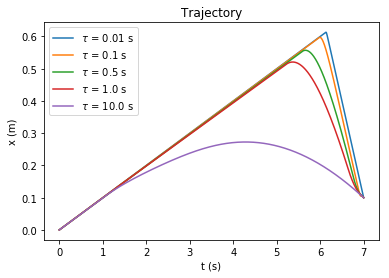

In [58]:
def acceleration(v,tf):
    acc = []
    dt = tf/len(v)
    for i in range(1,len(v)):
        acc.append((v[i]-v[i-1])/dt)
    return(acc)

# PARAMETERS FOR THE COMPUTATION
vtapis = 0.1
kxpenalty=100  # steepness of penalty cost (the higher the steeper: 100 very steep, 3 slightly, 1 very diffused)
x0 = 0.0     # initial position
xf = 0.1     # final position 
tf = 7.     # final time (duration of experiment)
sigma = 1.708
reward_max=10.0

tau_acc = []
tau = [0.01,0.1,0.5,1.0,10.0]

for toto in tau:
    xk,xdotk,tk,acck,tak = optimal_trajectory(tau_res=toto,sigma=sigma,x0=x0,xf=xf,tf=tf,vtapis=vtapis,kxpenalty=kxpenalty,reward_max=reward_max)
    acceleration_profile=acceleration(np.asarray(xdotk),tf)
    max_acc = np.min(acceleration_profile)
    tau_acc.append(max_acc)
    plt.plot(tk,xk,label=r'$\tau$ = '+str(toto)+' s')

plt.legend()
plt.ylabel('x (m)')
plt.xlabel('t (s)')
plt.title('Trajectory')
plt.savefig('tau_keller2.pdf')

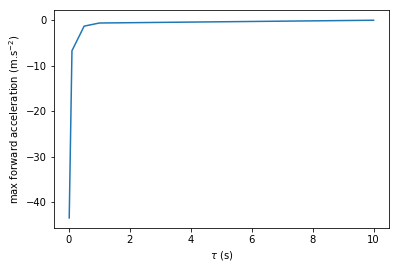

In [59]:
plt.plot(tau,tau_acc)
plt.xlabel(r'$\tau$ (s)')
plt.ylabel('max forward acceleration (m.s$^{-2})$')

plt.savefig('tau_keller_acc2.pdf')